In [1]:
import pandas as pd
import numpy as np
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
import os
from supervised.automl import AutoML
import category_encoders as ce
import math

# visualization
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from category_encoders import TargetEncoder
from sklearn.metrics import median_absolute_error
print('Imported sci-kit learn and automl libraries!')

Imported sci-kit learn and automl libraries!


# Irish Data - ML approach attempt 2
After our initial run of experiments I felt I needed to clean and process our Irish housing data more for better results. With our best performing algorithms returning only 17.5% accurate test predictions I tried to do more with the addresses provided. I extracted "neighbourhoods" from the addresses provided to focus in on an even smaller area than before and give more focused predictions in the hope of better results all around.

In [2]:
# new file containing rows with neighbourhoods occurring more than once
# this is to 1) cut out typos and 2) improve performance of our model.
# we still have ~250k rows to work with here
irl = pd.read_csv('unemploydata.csv', index_col='Unnamed: 0')

In [3]:
irl

,Address,Postal Code,County,Price (€),Not Full Market Price,VAT Exclusive,Description of Property,Property Size Description,Year,Month,Town,Region,Apartment,Neighbourhood,Province,Estate,Unemployment Number
0,"5 Braemor Drive, Churchtown",NaN,Dublin,343000.0,1,1,1,0,2010,1,Churchtown Dublin,Dublin,0,Braemor Drive Churchtown Dublin,Leinster,Estate,436936
1,"134 Ashewood Walk, Summerhill Lane, Portlaoise",NaN,Laois,185000.0,1,0,0,1,2010,1,Portlaoise,Midlands,0,Summerhill Lane Portlaoise,Leinster,Estate,436936
2,"1 The Haven, Mornington",NaN,Meath,400000.0,1,1,1,1,2010,1,Mornington,Mid-East,0,The Haven Mornington,Leinster,Estate,436936
3,"12 Sallymount Avenue, Ranelagh",NaN,Dublin,425000.0,1,1,1,1,2010,1,Ranelagh,Dublin,0,Sallymount Avenue Ranelagh,Leinster,Estate,436936
4,"15 Carriglawn, Waterpark, Carrigaline",NaN,Cork,180000.0,1,1,1,1,2010,1,Carrigaline,South-West (IE),0,Waterpark Carrigaline,Munster,Estate,436936
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
249380,"Farran, Feohanagh, Limerick",NaN,Limerick,200000.0,1,1,1,2,2021,9,Feohanagh,Mid-West,0,Farran Feohanagh,Munster,Other,162898
249381,"12 Oldtown Manor, Oldtown, Cavan",NaN,Cavan,210000.0,1,0,0,2,2021,9,Cavan,Border,0,Oldtown Cavan,Ulster,Estate,162898
249382,"2 Sandycove, Mountshannon, Clare",NaN,Clare,180000.0,1,1,1,2,2021,9,Mountshannon,Mid-West,0,Sandycove Mountshannon,Munster,Estate,162898
249383,"Bayview, Clonard, Wexford",NaN,Wexford,400000.0,1,1,1,2,2021,9,Wexford,South East (IE),0,Clonard Wexford,Leinster,Other,162898


In [4]:
irl['Apartment'] = irl['Apartment'].fillna(0.0)

In [5]:
irl.head()

,Address,Postal Code,County,Price (€),Not Full Market Price,VAT Exclusive,Description of Property,Property Size Description,Year,Month,Town,Region,Apartment,Neighbourhood,Province,Estate,Unemployment Number
0,"5 Braemor Drive, Churchtown",NaN,Dublin,343000.0,1,1,1,0,2010,1,Churchtown Dublin,Dublin,0,Braemor Drive Churchtown Dublin,Leinster,Estate,436936
1,"134 Ashewood Walk, Summerhill Lane, Portlaoise",NaN,Laois,185000.0,1,0,0,1,2010,1,Portlaoise,Midlands,0,Summerhill Lane Portlaoise,Leinster,Estate,436936
2,"1 The Haven, Mornington",NaN,Meath,400000.0,1,1,1,1,2010,1,Mornington,Mid-East,0,The Haven Mornington,Leinster,Estate,436936
3,"12 Sallymount Avenue, Ranelagh",NaN,Dublin,425000.0,1,1,1,1,2010,1,Ranelagh,Dublin,0,Sallymount Avenue Ranelagh,Leinster,Estate,436936
4,"15 Carriglawn, Waterpark, Carrigaline",NaN,Cork,180000.0,1,1,1,1,2010,1,Carrigaline,South-West (IE),0,Waterpark Carrigaline,Munster,Estate,436936


In [6]:
# this function finds all values that fall within internationally accepted +-10% of actual prices in our predictions
# we can modify the threshold as we feel the need to here
def accuracy_threshold(test, pred, num):
    test = np.array(test)
    pred = np.array(pred)
# get within x% of actual price , not within log price as this will be misleading / incorrect
    test = np.exp(test)
    pred = np.exp(pred)
    count = 0
    for i in range(len(pred)):
        if test[i] != 0:  
            ten = test[i] * num
            res = test[i] - pred[i]
        else:
            res = 0
            ten = 0
        
        if res < 0:
            res = res * -1
        else:
            res = res
            
        if res <= ten:
            count += 1
        else:
            continue
    return (count / len(test))

In [7]:
irl.drop(columns=['Postal Code'], inplace=True)
irl

,Address,County,Price (€),Not Full Market Price,VAT Exclusive,Description of Property,Property Size Description,Year,Month,Town,Region,Apartment,Neighbourhood,Province,Estate,Unemployment Number
0,"5 Braemor Drive, Churchtown",Dublin,343000.0,1,1,1,0,2010,1,Churchtown Dublin,Dublin,0,Braemor Drive Churchtown Dublin,Leinster,Estate,436936
1,"134 Ashewood Walk, Summerhill Lane, Portlaoise",Laois,185000.0,1,0,0,1,2010,1,Portlaoise,Midlands,0,Summerhill Lane Portlaoise,Leinster,Estate,436936
2,"1 The Haven, Mornington",Meath,400000.0,1,1,1,1,2010,1,Mornington,Mid-East,0,The Haven Mornington,Leinster,Estate,436936
3,"12 Sallymount Avenue, Ranelagh",Dublin,425000.0,1,1,1,1,2010,1,Ranelagh,Dublin,0,Sallymount Avenue Ranelagh,Leinster,Estate,436936
4,"15 Carriglawn, Waterpark, Carrigaline",Cork,180000.0,1,1,1,1,2010,1,Carrigaline,South-West (IE),0,Waterpark Carrigaline,Munster,Estate,436936
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
249380,"Farran, Feohanagh, Limerick",Limerick,200000.0,1,1,1,2,2021,9,Feohanagh,Mid-West,0,Farran Feohanagh,Munster,Other,162898
249381,"12 Oldtown Manor, Oldtown, Cavan",Cavan,210000.0,1,0,0,2,2021,9,Cavan,Border,0,Oldtown Cavan,Ulster,Estate,162898
249382,"2 Sandycove, Mountshannon, Clare",Clare,180000.0,1,1,1,2,2021,9,Mountshannon,Mid-West,0,Sandycove Mountshannon,Munster,Estate,162898
249383,"Bayview, Clonard, Wexford",Wexford,400000.0,1,1,1,2,2021,9,Wexford,South East (IE),0,Clonard Wexford,Leinster,Other,162898


In [8]:
encoder = TargetEncoder()
irl['Town'] = encoder.fit_transform(irl['Town'], irl['Price (€)'])

In [9]:
encoder = TargetEncoder()
irl['Region'] = encoder.fit_transform(irl['Region'], irl['Price (€)'])

In [10]:
encoder = TargetEncoder()
irl['County'] = encoder.fit_transform(irl['County'], irl['Price (€)'])

In [11]:
irl

,Address,County,Price (€),Not Full Market Price,VAT Exclusive,Description of Property,Property Size Description,Year,Month,Town,Region,Apartment,Neighbourhood,Province,Estate,Unemployment Number
0,"5 Braemor Drive, Churchtown",363311.258541,343000.0,1,1,1,0,2010,1,420564.880451,363311.258541,0,Braemor Drive Churchtown Dublin,Leinster,Estate,436936
1,"134 Ashewood Walk, Summerhill Lane, Portlaoise",143914.074354,185000.0,1,0,0,1,2010,1,146388.228701,137812.536269,0,Summerhill Lane Portlaoise,Leinster,Estate,436936
2,"1 The Haven, Mornington",236417.551281,400000.0,1,1,1,1,2010,1,247327.006696,263772.291871,0,The Haven Mornington,Leinster,Estate,436936
3,"12 Sallymount Avenue, Ranelagh",363311.258541,425000.0,1,1,1,1,2010,1,534155.362869,363311.258541,0,Sallymount Avenue Ranelagh,Leinster,Estate,436936
4,"15 Carriglawn, Waterpark, Carrigaline",215160.369898,180000.0,1,1,1,1,2010,1,255371.680067,203336.657684,0,Waterpark Carrigaline,Munster,Estate,436936
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
249380,"Farran, Feohanagh, Limerick",163525.267347,200000.0,1,1,1,2,2021,9,134423.546636,155565.894684,0,Farran Feohanagh,Munster,Other,162898
249381,"12 Oldtown Manor, Oldtown, Cavan",121527.310031,210000.0,1,0,0,2,2021,9,128744.566626,136425.390561,0,Oldtown Cavan,Ulster,Estate,162898
249382,"2 Sandycove, Mountshannon, Clare",150447.178778,180000.0,1,1,1,2,2021,9,131535.382083,155565.894684,0,Sandycove Mountshannon,Munster,Estate,162898
249383,"Bayview, Clonard, Wexford",155054.539366,400000.0,1,1,1,2,2021,9,158574.701242,152847.484716,0,Clonard Wexford,Leinster,Other,162898


In [12]:
encoder = TargetEncoder()
irl['Neighbourhood'] = encoder.fit_transform(irl['Neighbourhood'], irl['Price (€)'])

In [13]:
cleanup_nums_new = {"Estate": {"Other": 0, "Estate": 1}}
irl = irl.replace(cleanup_nums_new)
irl.head()

,Address,County,Price (€),Not Full Market Price,VAT Exclusive,Description of Property,Property Size Description,Year,Month,Town,Region,Apartment,Neighbourhood,Province,Estate,Unemployment Number
0,"5 Braemor Drive, Churchtown",363311.258541,343000.0,1,1,1,0,2010,1,420564.880451,363311.258541,0,419389.799500,Leinster,1,436936
1,"134 Ashewood Walk, Summerhill Lane, Portlaoise",143914.074354,185000.0,1,0,0,1,2010,1,146388.228701,137812.536269,0,198970.065714,Leinster,1,436936
2,"1 The Haven, Mornington",236417.551281,400000.0,1,1,1,1,2010,1,247327.006696,263772.291871,0,288274.989445,Leinster,1,436936
3,"12 Sallymount Avenue, Ranelagh",363311.258541,425000.0,1,1,1,1,2010,1,534155.362869,363311.258541,0,521096.081067,Leinster,1,436936
4,"15 Carriglawn, Waterpark, Carrigaline",215160.369898,180000.0,1,1,1,1,2010,1,255371.680067,203336.657684,0,203525.216226,Munster,1,436936


In [14]:
irl

,Address,County,Price (€),Not Full Market Price,VAT Exclusive,Description of Property,Property Size Description,Year,Month,Town,Region,Apartment,Neighbourhood,Province,Estate,Unemployment Number
0,"5 Braemor Drive, Churchtown",363311.258541,343000.0,1,1,1,0,2010,1,420564.880451,363311.258541,0,419389.799500,Leinster,1,436936
1,"134 Ashewood Walk, Summerhill Lane, Portlaoise",143914.074354,185000.0,1,0,0,1,2010,1,146388.228701,137812.536269,0,198970.065714,Leinster,1,436936
2,"1 The Haven, Mornington",236417.551281,400000.0,1,1,1,1,2010,1,247327.006696,263772.291871,0,288274.989445,Leinster,1,436936
3,"12 Sallymount Avenue, Ranelagh",363311.258541,425000.0,1,1,1,1,2010,1,534155.362869,363311.258541,0,521096.081067,Leinster,1,436936
4,"15 Carriglawn, Waterpark, Carrigaline",215160.369898,180000.0,1,1,1,1,2010,1,255371.680067,203336.657684,0,203525.216226,Munster,1,436936
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
249380,"Farran, Feohanagh, Limerick",163525.267347,200000.0,1,1,1,2,2021,9,134423.546636,155565.894684,0,191118.677980,Munster,0,162898
249381,"12 Oldtown Manor, Oldtown, Cavan",121527.310031,210000.0,1,0,0,2,2021,9,128744.566626,136425.390561,0,147985.930259,Ulster,1,162898
249382,"2 Sandycove, Mountshannon, Clare",150447.178778,180000.0,1,1,1,2,2021,9,131535.382083,155565.894684,0,129875.278372,Munster,1,162898
249383,"Bayview, Clonard, Wexford",155054.539366,400000.0,1,1,1,2,2021,9,158574.701242,152847.484716,0,161891.718049,Leinster,0,162898


In [15]:
irl.drop(columns=['Address', 'Province', 'Estate'], inplace=True)

In [16]:
irl

,County,Price (€),Not Full Market Price,VAT Exclusive,Description of Property,Property Size Description,Year,Month,Town,Region,Apartment,Neighbourhood,Unemployment Number
0,363311.258541,343000.0,1,1,1,0,2010,1,420564.880451,363311.258541,0,419389.799500,436936
1,143914.074354,185000.0,1,0,0,1,2010,1,146388.228701,137812.536269,0,198970.065714,436936
2,236417.551281,400000.0,1,1,1,1,2010,1,247327.006696,263772.291871,0,288274.989445,436936
3,363311.258541,425000.0,1,1,1,1,2010,1,534155.362869,363311.258541,0,521096.081067,436936
4,215160.369898,180000.0,1,1,1,1,2010,1,255371.680067,203336.657684,0,203525.216226,436936
...,...,...,...,...,...,...,...,...,...,...,...,...,...
249380,163525.267347,200000.0,1,1,1,2,2021,9,134423.546636,155565.894684,0,191118.677980,162898
249381,121527.310031,210000.0,1,0,0,2,2021,9,128744.566626,136425.390561,0,147985.930259,162898
249382,150447.178778,180000.0,1,1,1,2,2021,9,131535.382083,155565.894684,0,129875.278372,162898
249383,155054.539366,400000.0,1,1,1,2,2021,9,158574.701242,152847.484716,0,161891.718049,162898


In [17]:
irl['LogPrice (€)'] = np.log(irl['Price (€)'])

In [18]:
irl.drop(columns=['Price (€)', 'Description of Property'], inplace = True)

In [19]:
irl.head()

,County,Not Full Market Price,VAT Exclusive,Property Size Description,Year,Month,Town,Region,Apartment,Neighbourhood,Unemployment Number,LogPrice (€)
0,363311.258541,1,1,0,2010,1,420564.880451,363311.258541,0,419389.799500,436936,12.745486
1,143914.074354,1,0,1,2010,1,146388.228701,137812.536269,0,198970.065714,436936,12.128111
2,236417.551281,1,1,1,2010,1,247327.006696,263772.291871,0,288274.989445,436936,12.899220
3,363311.258541,1,1,1,2010,1,534155.362869,363311.258541,0,521096.081067,436936,12.959844
4,215160.369898,1,1,1,2010,1,255371.680067,203336.657684,0,203525.216226,436936,12.100712


In [20]:
x = irl.loc[:, irl.columns != 'LogPrice (€)']
y = irl['LogPrice (€)']

In [21]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.15)
automl = AutoML(total_time_limit = 5 * 60)
automl.fit(X_train, y_train)

Linear algorithm was disabled.
AutoML directory: AutoML_1
The task is regression with evaluation metric rmse
AutoML will use algorithms: ['Baseline', 'Decision Tree', 'Random Forest', 'Xgboost', 'Neural Network']
AutoML will ensemble available models
AutoML steps: ['simple_algorithms', 'default_algorithms', 'ensemble']
* Step simple_algorithms will try to check up to 2 models
1_Baseline rmse 0.764316 trained in 0.61 seconds
2_DecisionTree rmse 0.470397 trained in 19.66 seconds
* Step default_algorithms will try to check up to 3 models
3_Default_Xgboost rmse 0.405789 trained in 46.84 seconds
4_Default_NeuralNetwork rmse 0.418601 trained in 31.71 seconds
5_Default_RandomForest rmse 0.442722 trained in 16.07 seconds
* Step ensemble will try to check up to 1 model
Ensemble rmse 0.40568 trained in 0.34 seconds
AutoML fit time: 133.05 seconds
AutoML best model: Ensemble


AutoML(total_time_limit=300)

In [22]:
# calculated values
y_predicted = automl.predict(X_test)
  
# Calculation of Mean Squared Error (MSE)
mean_squared_error(y_test, y_predicted)

0.15946496263548093

In [23]:
accuracy_threshold(y_test, y_predicted, 0.1)

0.29942792985457656

In [24]:
median_se = np.square(np.subtract(y_test, y_predicted)).median() 
 
med = math.sqrt(median_se)
print("Median Absolute Error:\n")
print(med)

Median Absolute Error:

0.1881767616348322


### Let's try predict a specific years values given some historical data
We will look at using 3 years worth of data and use it to predict some data for a selected year, let's say 2021, now.

In [25]:
specific21 = irl[irl['Year'] > 2017]

A regular train to test split will not suffice here as we need only the years 2018, 2019 and 2020 in our training data, while only using the houses associated with 2021 in our test data.

In [26]:
specific21[specific21['Year'] == 2021]

,County,Not Full Market Price,VAT Exclusive,Property Size Description,Year,Month,Town,Region,Apartment,Neighbourhood,Unemployment Number,LogPrice (€)
232800,215160.369898,1,0,2,2021,1,147427.309669,203336.657684,0,174420.017636,188543,11.974079
232801,363311.258541,1,0,2,2021,1,136600.824751,363311.258541,0,193626.533333,188543,12.170192
232802,163525.267347,1,1,2,2021,1,125623.181410,155565.894684,0,197072.910803,188543,11.695247
232803,236417.551281,1,1,2,2021,1,227753.682745,263772.291871,0,270195.598590,188543,12.796633
232804,236417.551281,1,1,2,2021,1,264944.031465,263772.291871,0,404540.203738,188543,13.190022
...,...,...,...,...,...,...,...,...,...,...,...,...
249380,163525.267347,1,1,2,2021,9,134423.546636,155565.894684,0,191118.677980,162898,12.206073
249381,121527.310031,1,0,2,2021,9,128744.566626,136425.390561,0,147985.930259,162898,12.254863
249382,150447.178778,1,1,2,2021,9,131535.382083,155565.894684,0,129875.278372,162898,12.100712
249383,155054.539366,1,1,2,2021,9,158574.701242,152847.484716,0,161891.718049,162898,12.899220


In [27]:
specific21.shape[0]

94648

In [28]:
train_21 = specific21[specific21['Year'] < 2021]

In [29]:
#train_21 = train_21.sample(n = 80000)
train_21

,County,Not Full Market Price,VAT Exclusive,Property Size Description,Year,Month,Town,Region,Apartment,Neighbourhood,Unemployment Number,LogPrice (€)
154737,363311.258541,1,1,2,2018,1,373904.180835,363311.258541,0,355065.390599,237386,13.349070
154738,311830.754461,1,0,2,2018,1,324653.104870,263772.291871,0,385664.353896,237386,13.208541
154739,136238.546858,1,1,2,2018,1,151084.791077,152847.484716,0,170766.761682,237386,11.918391
154740,148534.124012,1,1,2,2018,1,155445.085356,137812.536269,0,137270.000471,237386,11.982929
154741,363311.258541,1,1,1,2018,1,322101.887699,363311.258541,0,400695.449020,237386,12.760008
...,...,...,...,...,...,...,...,...,...,...,...,...
232795,154744.301827,0,0,2,2020,12,136577.926622,152847.484716,0,195253.693125,189860,12.151761
232796,154744.301827,0,0,2,2020,12,136577.926622,152847.484716,0,195253.693125,189860,12.151761
232797,154744.301827,0,0,2,2020,12,136577.926622,152847.484716,0,195253.693125,189860,12.151761
232798,154744.301827,0,0,2,2020,12,136577.926622,152847.484716,0,195253.693125,189860,12.151761


In [30]:
test_21 = specific21[specific21['Year'] == 2021]

In [31]:
x_train_21 = train_21.loc[:, train_21.columns != 'LogPrice (€)']
y_train_21 = train_21['LogPrice (€)']

In [32]:
#test_21 = test_21.sample(n = 15000)
test_21

,County,Not Full Market Price,VAT Exclusive,Property Size Description,Year,Month,Town,Region,Apartment,Neighbourhood,Unemployment Number,LogPrice (€)
232800,215160.369898,1,0,2,2021,1,147427.309669,203336.657684,0,174420.017636,188543,11.974079
232801,363311.258541,1,0,2,2021,1,136600.824751,363311.258541,0,193626.533333,188543,12.170192
232802,163525.267347,1,1,2,2021,1,125623.181410,155565.894684,0,197072.910803,188543,11.695247
232803,236417.551281,1,1,2,2021,1,227753.682745,263772.291871,0,270195.598590,188543,12.796633
232804,236417.551281,1,1,2,2021,1,264944.031465,263772.291871,0,404540.203738,188543,13.190022
...,...,...,...,...,...,...,...,...,...,...,...,...
249380,163525.267347,1,1,2,2021,9,134423.546636,155565.894684,0,191118.677980,162898,12.206073
249381,121527.310031,1,0,2,2021,9,128744.566626,136425.390561,0,147985.930259,162898,12.254863
249382,150447.178778,1,1,2,2021,9,131535.382083,155565.894684,0,129875.278372,162898,12.100712
249383,155054.539366,1,1,2,2021,9,158574.701242,152847.484716,0,161891.718049,162898,12.899220


In [33]:
x_test_21 = test_21.loc[:, test_21.columns != 'LogPrice (€)']
y_test_21 = test_21['LogPrice (€)']

In [34]:
automl = AutoML(total_time_limit = 5 * 60)
automl.fit(x_train_21, y_train_21)

Linear algorithm was disabled.
AutoML directory: AutoML_2
The task is regression with evaluation metric rmse
AutoML will use algorithms: ['Baseline', 'Decision Tree', 'Random Forest', 'Xgboost', 'Neural Network']
AutoML will ensemble available models
AutoML steps: ['simple_algorithms', 'default_algorithms', 'ensemble']
* Step simple_algorithms will try to check up to 2 models
1_Baseline rmse 0.692338 trained in 1.2 seconds
2_DecisionTree rmse 0.409863 trained in 6.87 seconds
* Step default_algorithms will try to check up to 3 models
3_Default_Xgboost rmse 0.380085 trained in 14.26 seconds
4_Default_NeuralNetwork rmse 0.387799 trained in 5.84 seconds
5_Default_RandomForest rmse 0.395843 trained in 10.11 seconds
* Step ensemble will try to check up to 1 model
Ensemble rmse 0.379637 trained in 0.66 seconds
AutoML fit time: 53.73 seconds
AutoML best model: Ensemble


AutoML(total_time_limit=300)

In [35]:
# calculated values
y_predicted_21 = automl.predict(x_test_21)
  
# Calculation of Mean Squared Error (MSE)
mse = mean_squared_error(y_test_21, y_predicted_21)
print('MSE for AutoML 2021 is: ' + str(mse))

MSE for AutoML 2021 is: 0.14936750643500465


In [36]:
rmse = mean_squared_error(y_test_21, y_predicted_21, squared=False)
print('RMSE for AutoML 2021 is: ' + str(rmse))

RMSE for AutoML 2021 is: 0.38648092635342907


In [37]:
acc = accuracy_threshold(y_test_21, y_predicted_21, 0.1)
print('Accuracy of properties at +- 10% of actual prices is ' + str(acc))

Accuracy of properties at +- 10% of actual prices is 0.3033463973470003


In [38]:
median_se = np.square(np.subtract(y_test_21, y_predicted_21)).median() 
 
med = math.sqrt(median_se)
print("Median Absolute Error:\n")
print(med)

Median Absolute Error:

0.18236833388761475


In [39]:
from sklearn.metrics import mean_absolute_percentage_error
mape = mean_absolute_percentage_error(y_test_21, y_predicted_21)
print("MAPE for AutoML 2021 is: " + str(mape))

MAPE for AutoML 2021 is: 0.02201214248341247


In [40]:
cnames=['Algorithm', 'Year', 'RMSE', 'MSE', 'MEDAE', 'Accuracy', 'MAPE']
df11 = pd.DataFrame(columns=cnames)

df11 = df11.append({'Algorithm': 'AutoML',
            'Year': 2021,
           'RMSE': rmse,
           'MSE': mse,
           'MEDAE': med,
           'Accuracy': acc,
           'MAPE': mape         
          }, ignore_index=True)

### It seems our results are even more accurate when selecting a specific year to predict
It is interesting to note here our RMSE values are equal between XgBoost and Ensemble models. The results here across all our evaluation metrics are very strong it has to be said. We will now test 2020 and a couple of more years to robustly test our yearly predictions.

### 2020 predictions

In [41]:
specific20 = irl[irl['Year'] > 2016]

In [42]:
test_20 = specific20[specific20['Year'] == 2020]
train_20 = specific20[specific20['Year'] < 2020]

In [43]:
#train_20 = train_20.sample(n = 75000)

In [44]:
x_train_20 = train_20.loc[:, train_20.columns != 'LogPrice (€)']
y_train_20 = train_20['LogPrice (€)']

In [45]:
#test_20 = test_20.sample(n = 15000)

In [46]:
x_test_20 = test_20.loc[:, test_20.columns != 'LogPrice (€)']
y_test_20 = test_20['LogPrice (€)']

In [47]:
automl = AutoML(total_time_limit=5*60)
automl.fit(x_train_20, y_train_20)

Linear algorithm was disabled.
AutoML directory: AutoML_3
The task is regression with evaluation metric rmse
AutoML will use algorithms: ['Baseline', 'Decision Tree', 'Random Forest', 'Xgboost', 'Neural Network']
AutoML will ensemble available models
AutoML steps: ['simple_algorithms', 'default_algorithms', 'ensemble']
* Step simple_algorithms will try to check up to 2 models
1_Baseline rmse 0.710996 trained in 0.88 seconds
2_DecisionTree rmse 0.416989 trained in 6.57 seconds
* Step default_algorithms will try to check up to 3 models
3_Default_Xgboost rmse 0.38292 trained in 16.21 seconds
4_Default_NeuralNetwork rmse 0.391363 trained in 10.26 seconds
5_Default_RandomForest rmse 0.40072 trained in 18.09 seconds
* Step ensemble will try to check up to 1 model
Ensemble rmse 0.382471 trained in 0.32 seconds
AutoML fit time: 66.94 seconds
AutoML best model: Ensemble


AutoML(total_time_limit=300)

In [48]:
# calculated values
y_predicted_20 = automl.predict(x_test_20)
  
# Calculation of Mean Squared Error (MSE)
mse = mean_squared_error(y_test_20,y_predicted_20)
print('MSE for AutoML 2020 is: ' + str(mse))

MSE for AutoML 2020 is: 0.14563267928067355


In [49]:
rmse = mean_squared_error(y_test_20,y_predicted_20, squared=False)
print('RMSE for AutoML 2020 is: ' + str(rmse))

RMSE for AutoML 2020 is: 0.3816184996572802


In [50]:
acc = accuracy_threshold(y_test_20, y_predicted_20, 0.1)
print('Accuracy of properties at +- 10% of actual prices is ' + str(acc))

Accuracy of properties at +- 10% of actual prices is 0.3376177480412008


In [51]:
print("Median Absolute Error:\n")
print(median_absolute_error(y_test_20,y_predicted_20))

Median Absolute Error:

0.1659132634300562


In [52]:
mape = mean_absolute_percentage_error(y_test_20, y_predicted_20)
print("MAPE for AutoML 2020 is: " + str(mape))

MAPE for AutoML 2020 is: 0.021236246189673652


In [53]:
cnames=['Algorithm', 'Year', 'RMSE', 'MSE', 'MEDAE', 'Accuracy', 'MAPE']
df10 = pd.DataFrame(columns=cnames)

df10 = df10.append({'Algorithm': 'AutoML',
            'Year': 2020,
           'RMSE': rmse,
           'MSE': mse,
           'MEDAE': med,
           'Accuracy': acc,
           'MAPE': mape
          }, ignore_index=True)

### Multiple Linear Regression

Next, I will try implement some algorithms not specified in our autoML library which so far has only utilised XgBoost, Random Forest, Decison Tree and ensemble algorithms. I will attempt to implement other ML algorithms such as multiple linear regression and adaboost among others.

There is a couple of different libraries we can use here for linear regression:
- Sci-kit learn's linear model library
- Statsmodel

For the purpose of this I will remain consistent with the use of the sci-kit learn libraries.

In [54]:
from sklearn import linear_model

#### Let's try predict our 2021 values again using MLR

In [55]:
lm = linear_model.LinearRegression()
lm.fit(x_train_21, y_train_21) # fitting the model

LinearRegression()

In [56]:
y_pred_21 = lm.predict(x_test_21)
# Calculation of Mean Squared Error (MSE)
mse = mean_squared_error(y_test_21,y_pred_21)
print('MSE for MLR 2021 is: ' + str(mse))

MSE for MLR 2021 is: 0.19325284194826048


In [57]:
acc = accuracy_threshold(y_test_21, y_pred_21, 0.1)
print('Accuracy of properties at +- 10% of actual prices is ' + str(acc))

Accuracy of properties at +- 10% of actual prices is 0.25028640337654506


In [58]:
median_se = np.square(np.subtract(y_test_21,y_pred_21)).median() 
 
med = math.sqrt(median_se)
print("Median Absolute Error:\n")
print(med)

Median Absolute Error:

0.22251942366294308


In [59]:
mean = np.square(np.subtract(y_test_21,y_pred_21)).mean() 
 
mean = math.sqrt(mean)
print("Root Mean Square Error:\n")
print(mean)

Root Mean Square Error:

0.43960532520462087


In [60]:
mape = mean_absolute_percentage_error(y_test_21, y_pred_21)
print("MAPE for MLR 2021 is: " + str(mape))

MAPE for MLR 2021 is: 0.025557936991601138


In [61]:
cnames=['Algorithm', 'Year', 'RMSE', 'MSE', 'MEDAE', 'Accuracy', 'MAPE']
df9 = pd.DataFrame(columns=cnames)

df9 = df9.append({'Algorithm': 'MLR',
            'Year': 2021,
           'RMSE': mean,
           'MSE': mse,
           'MEDAE': med,
           'Accuracy': acc,
           'MAPE': mape       
          }, ignore_index=True)

### 2020 predictions

In [62]:
lm = linear_model.LinearRegression()
lm.fit(x_train_20, y_train_20) # fitting the model

LinearRegression()

In [63]:
y_pred_20 = lm.predict(x_test_20)
# Calculation of Mean Squared Error (MSE)
mse = mean_squared_error(y_test_20,y_pred_20)
print('MSE for MLR 2020 is: ' + str(mse))

MSE for MLR 2020 is: 0.1874910684571846


In [64]:
acc = accuracy_threshold(y_test_20, y_pred_20, 0.1)
print('Accuracy of properties at +- 10% of actual prices is ' + str(acc))

Accuracy of properties at +- 10% of actual prices is 0.2707104498635443


In [65]:
median_se = np.square(np.subtract(y_test_20,y_pred_20)).median() 
 
med = math.sqrt(median_se)
print("Median Absolute Error:\n")
print(med)

Median Absolute Error:

0.2024154193725496


In [66]:
mean = np.square(np.subtract(y_test_20,y_pred_20)).mean() 
 
mean = math.sqrt(mean)
print("Root Mean Square Error:\n")
print(mean)

Root Mean Square Error:

0.433002388512102


In [67]:
mape = mean_absolute_percentage_error(y_test_20, y_pred_20)
print("MAPE for MLR 2020 is: " + str(mape))

MAPE for MLR 2020 is: 0.02472057677089077


In [68]:
cnames=['Algorithm', 'Year', 'RMSE', 'MSE', 'MEDAE', 'Accuracy', 'MAPE']
df8 = pd.DataFrame(columns=cnames)

df8 = df8.append({'Algorithm': 'MLR',
            'Year': 2020,
           'RMSE': mean,
           'MSE': mse,
           'MEDAE': med,
           'Accuracy': acc,
           'MAPE': mape       
          }, ignore_index=True)

### Adaboost

#### 2021 Predictions

In [69]:
from sklearn.ensemble import AdaBoostRegressor
from sklearn.datasets import make_regression

In [70]:
model = AdaBoostRegressor()

In [71]:
model.fit(x_train_21, y_train_21)

AdaBoostRegressor()

In [72]:
y_pred_21 = model.predict(x_test_21)
# Calculation of Mean Squared Error (MSE)
mse = mean_squared_error(y_test_21,y_pred_21)
print('MSE for AdaBoost 2021 is: ' + str(mse))

MSE for AdaBoost 2021 is: 0.36923091779723016


In [73]:
acc = accuracy_threshold(y_test_21, y_pred_21, 0.1)
print('Accuracy of properties at +- 10% of actual prices is ' + str(acc))

Accuracy of properties at +- 10% of actual prices is 0.11293337353029846


In [74]:
median_se = np.square(np.subtract(y_test_21,y_pred_21)).median() 
 
med = math.sqrt(median_se)
print("Median Absolute Error:\n")
print(med)

Median Absolute Error:

0.44089747046947814


In [75]:
mean = np.square(np.subtract(y_test_21,y_pred_21)).mean() 
 
mean = math.sqrt(mean)
print("Root Mean Square Error:\n")
print(mean)

Root Mean Square Error:

0.6076437424982126


In [76]:
mape = mean_absolute_percentage_error(y_test_21, y_pred_21)
print("MAPE for AdaBoost 2021 is: " + str(mape))

MAPE for AdaBoost 2021 is: 0.04009960309692789


In [77]:
cnames=['Algorithm', 'Year', 'RMSE', 'MSE', 'MEDAE', 'Accuracy', 'MAPE']
df7 = pd.DataFrame(columns=cnames)

df7 = df7.append({'Algorithm': 'AdaBoost',
            'Year': 2021,
           'RMSE': mean,
           'MSE': mse,
           'MEDAE': med,
           'Accuracy': acc,
           'MAPE': mape       
          }, ignore_index=True)

#### 2020 Predictions

In [78]:
model = AdaBoostRegressor()
model.fit(x_train_20, y_train_20)

AdaBoostRegressor()

In [79]:
y_pred_20 = model.predict(x_test_20)
# Calculation of Mean Squared Error (MSE)
mse = mean_squared_error(y_test_20,y_pred_20)
print('MSE for AdaBoost 2020 is: ' + str(mse))

MSE for AdaBoost 2020 is: 0.3406671515654074


In [80]:
acc = accuracy_threshold(y_test_20, y_pred_20, 0.1)
print('Accuracy of properties at +- 10% of actual prices is ' + str(acc))

Accuracy of properties at +- 10% of actual prices is 0.10207764768025354


In [81]:
median_se = np.square(np.subtract(y_test_20,y_pred_20)).median() 
 
med = math.sqrt(median_se)
print("Median Absolute Error:\n")
print(med)

Median Absolute Error:

0.449959171398417


In [82]:
mean = np.square(np.subtract(y_test_20,y_pred_20)).mean() 
 
mean = math.sqrt(mean)
print("Root Mean Square Error:\n")
print(mean)

Root Mean Square Error:

0.5836669868729997


In [83]:
mape = mean_absolute_percentage_error(y_test_20, y_pred_20)
print("MAPE for AdaBoost 2020 is: " + str(mape))

MAPE for AdaBoost 2020 is: 0.039550017466400515


In [84]:
cnames=['Algorithm', 'Year', 'RMSE', 'MSE', 'MEDAE', 'Accuracy', 'MAPE']
df6 = pd.DataFrame(columns=cnames)

df6 = df6.append({'Algorithm': 'AdaBoost',
            'Year': 2020,
           'RMSE': mean,
           'MSE': mse,
           'MEDAE': med,
           'Accuracy': acc,
           'MAPE': mape       
          }, ignore_index=True)

## Let's now try a selection of other algorithms on our data
### LightGBM

In [85]:
from sklearn.datasets import make_regression
from lightgbm import LGBMRegressor

### 2020 House Price Prediction Using LightGBM

In [86]:
model = LGBMRegressor()
model.fit(x_train_20, y_train_20)

LGBMRegressor()

In [87]:
y_pred_20 = model.predict(x_test_20)
# Calculation of Mean Squared Error (MSE)
mse = mean_squared_error(y_test_20,y_pred_20)
print('MSE for LightGBM 2020 is: ' + str(mse))

MSE for LightGBM 2020 is: 0.14482001247332507


In [88]:
acc = accuracy_threshold(y_test_20, y_pred_20, 0.1)
print('Accuracy of properties at +- 10% of actual prices is ' + str(acc))

Accuracy of properties at +- 10% of actual prices is 0.32925433576899377


In [89]:
median_se = np.square(np.subtract(y_test_20,y_pred_20)).median() 
 
med = math.sqrt(median_se)
print("Median Absolute Error:\n")
print(med)

Median Absolute Error:

0.1688845929271154


In [90]:
mean = np.square(np.subtract(y_test_20,y_pred_20)).mean() 
 
mean = math.sqrt(mean)
print("Root Mean Square Error:\n")
print(mean)

Root Mean Square Error:

0.38055224670644855


In [91]:
mape = mean_absolute_percentage_error(y_test_20, y_pred_20)
print("MAPE for LightGBM 2020 is: " + str(mape))

MAPE for LightGBM 2020 is: 0.021295358524322395


In [92]:
cnames=['Algorithm', 'Year', 'RMSE', 'MSE', 'MEDAE', 'Accuracy', 'MAPE']
df5 = pd.DataFrame(columns=cnames)

df5 = df5.append({'Algorithm': 'LightGBM',
            'Year': 2020,
           'RMSE': mean,
           'MSE': mse,
           'MEDAE': med,
           'Accuracy': acc,
           'MAPE': mape       
          }, ignore_index=True)

### 2021

In [93]:
model = LGBMRegressor()
model.fit(x_train_21, y_train_21)

LGBMRegressor()

In [94]:
y_pred_21 = model.predict(x_test_21)
# Calculation of Mean Squared Error (MSE)
mse = mean_squared_error(y_test_21,y_pred_21)
print('MSE for LightGBM 2021 is: ' + str(mse))

MSE for LightGBM 2021 is: 0.14924558296402984


In [95]:
acc = accuracy_threshold(y_test_21, y_pred_21, 0.1)
print('Accuracy of properties at +- 10% of actual prices is ' + str(acc))

Accuracy of properties at +- 10% of actual prices is 0.2981609888453422


In [96]:
median_se = np.square(np.subtract(y_test_21, y_pred_21)).median() 
 
med = math.sqrt(median_se)
print("Median Absolute Error:\n")
print(med)

Median Absolute Error:

0.18477072371763725


In [97]:
mean = np.square(np.subtract(y_test_21, y_pred_21)).mean() 
 
mean = math.sqrt(mean)
print("Root Mean Square Error:\n")
print(mean)

Root Mean Square Error:

0.38632315872081835


In [98]:
mape = mean_absolute_percentage_error(y_test_21, y_pred_21)
print("MAPE for LightGBM 2021 is: " + str(mape))

MAPE for LightGBM 2021 is: 0.02216491909195455


In [99]:
cnames=['Algorithm', 'Year', 'RMSE', 'MSE', 'MEDAE', 'Accuracy', 'MAPE']
df4 = pd.DataFrame(columns=cnames)

df4 = df4.append({'Algorithm': 'LightGBM',
            'Year': 2021,
           'RMSE': mean,
           'MSE': mse,
           'MEDAE': med,
           'Accuracy': acc,
           'MAPE': mape       
          }, ignore_index=True)

### CatBoost

#### 2021 Prediction

In [100]:
from catboost import CatBoostRegressor

In [101]:
model = CatBoostRegressor()
model.fit(x_train_21, y_train_21)

Learning rate set to 0.081505
0:	learn: 0.6543234	total: 182ms	remaining: 3m 1s
1:	learn: 0.6232449	total: 216ms	remaining: 1m 47s
2:	learn: 0.5954336	total: 253ms	remaining: 1m 24s
3:	learn: 0.5702947	total: 291ms	remaining: 1m 12s
4:	learn: 0.5479253	total: 331ms	remaining: 1m 5s
5:	learn: 0.5284837	total: 373ms	remaining: 1m 1s
6:	learn: 0.5108749	total: 426ms	remaining: 1m
7:	learn: 0.4963835	total: 460ms	remaining: 57s
8:	learn: 0.4825332	total: 504ms	remaining: 55.5s
9:	learn: 0.4707369	total: 547ms	remaining: 54.1s
10:	learn: 0.4602422	total: 584ms	remaining: 52.5s
11:	learn: 0.4509852	total: 619ms	remaining: 51s
12:	learn: 0.4432100	total: 650ms	remaining: 49.4s
13:	learn: 0.4360690	total: 671ms	remaining: 47.2s
14:	learn: 0.4299651	total: 691ms	remaining: 45.4s
15:	learn: 0.4247861	total: 712ms	remaining: 43.8s
16:	learn: 0.4200104	total: 730ms	remaining: 42.2s
17:	learn: 0.4156929	total: 746ms	remaining: 40.7s
18:	learn: 0.4119275	total: 761ms	remaining: 39.3s
19:	learn: 0.40

166:	learn: 0.3760886	total: 3.38s	remaining: 16.9s
167:	learn: 0.3760477	total: 3.4s	remaining: 16.8s
168:	learn: 0.3760206	total: 3.42s	remaining: 16.8s
169:	learn: 0.3759618	total: 3.44s	remaining: 16.8s
170:	learn: 0.3759162	total: 3.47s	remaining: 16.8s
171:	learn: 0.3758793	total: 3.5s	remaining: 16.8s
172:	learn: 0.3758413	total: 3.52s	remaining: 16.8s
173:	learn: 0.3757638	total: 3.54s	remaining: 16.8s
174:	learn: 0.3757157	total: 3.56s	remaining: 16.8s
175:	learn: 0.3756721	total: 3.58s	remaining: 16.8s
176:	learn: 0.3756288	total: 3.6s	remaining: 16.8s
177:	learn: 0.3756113	total: 3.62s	remaining: 16.7s
178:	learn: 0.3755874	total: 3.64s	remaining: 16.7s
179:	learn: 0.3755357	total: 3.65s	remaining: 16.6s
180:	learn: 0.3754907	total: 3.66s	remaining: 16.6s
181:	learn: 0.3754424	total: 3.68s	remaining: 16.5s
182:	learn: 0.3754074	total: 3.69s	remaining: 16.5s
183:	learn: 0.3753662	total: 3.7s	remaining: 16.4s
184:	learn: 0.3753241	total: 3.71s	remaining: 16.4s
185:	learn: 0.37

328:	learn: 0.3706978	total: 5.59s	remaining: 11.4s
329:	learn: 0.3706588	total: 5.62s	remaining: 11.4s
330:	learn: 0.3706336	total: 5.66s	remaining: 11.4s
331:	learn: 0.3705895	total: 5.7s	remaining: 11.5s
332:	learn: 0.3705434	total: 5.74s	remaining: 11.5s
333:	learn: 0.3705110	total: 5.78s	remaining: 11.5s
334:	learn: 0.3704744	total: 5.81s	remaining: 11.5s
335:	learn: 0.3704565	total: 5.86s	remaining: 11.6s
336:	learn: 0.3704352	total: 5.89s	remaining: 11.6s
337:	learn: 0.3704150	total: 5.92s	remaining: 11.6s
338:	learn: 0.3703924	total: 5.95s	remaining: 11.6s
339:	learn: 0.3703640	total: 5.99s	remaining: 11.6s
340:	learn: 0.3703261	total: 6.02s	remaining: 11.6s
341:	learn: 0.3702918	total: 6.06s	remaining: 11.7s
342:	learn: 0.3702655	total: 6.09s	remaining: 11.7s
343:	learn: 0.3702328	total: 6.12s	remaining: 11.7s
344:	learn: 0.3702059	total: 6.14s	remaining: 11.7s
345:	learn: 0.3701844	total: 6.17s	remaining: 11.7s
346:	learn: 0.3701487	total: 6.2s	remaining: 11.7s
347:	learn: 0.

492:	learn: 0.3662712	total: 8.15s	remaining: 8.38s
493:	learn: 0.3662343	total: 8.16s	remaining: 8.36s
494:	learn: 0.3662123	total: 8.18s	remaining: 8.34s
495:	learn: 0.3661676	total: 8.19s	remaining: 8.32s
496:	learn: 0.3661490	total: 8.21s	remaining: 8.31s
497:	learn: 0.3661211	total: 8.22s	remaining: 8.29s
498:	learn: 0.3660987	total: 8.23s	remaining: 8.27s
499:	learn: 0.3660829	total: 8.25s	remaining: 8.25s
500:	learn: 0.3660682	total: 8.26s	remaining: 8.22s
501:	learn: 0.3660494	total: 8.27s	remaining: 8.2s
502:	learn: 0.3660339	total: 8.28s	remaining: 8.18s
503:	learn: 0.3659991	total: 8.29s	remaining: 8.15s
504:	learn: 0.3659679	total: 8.3s	remaining: 8.13s
505:	learn: 0.3659462	total: 8.31s	remaining: 8.11s
506:	learn: 0.3659279	total: 8.32s	remaining: 8.09s
507:	learn: 0.3659094	total: 8.33s	remaining: 8.07s
508:	learn: 0.3658936	total: 8.35s	remaining: 8.05s
509:	learn: 0.3658717	total: 8.36s	remaining: 8.04s
510:	learn: 0.3658460	total: 8.38s	remaining: 8.02s
511:	learn: 0.

664:	learn: 0.3623386	total: 10.3s	remaining: 5.2s
665:	learn: 0.3623240	total: 10.3s	remaining: 5.18s
666:	learn: 0.3623032	total: 10.3s	remaining: 5.17s
667:	learn: 0.3622862	total: 10.4s	remaining: 5.15s
668:	learn: 0.3622640	total: 10.4s	remaining: 5.14s
669:	learn: 0.3622328	total: 10.4s	remaining: 5.12s
670:	learn: 0.3622149	total: 10.4s	remaining: 5.11s
671:	learn: 0.3621964	total: 10.4s	remaining: 5.09s
672:	learn: 0.3621786	total: 10.4s	remaining: 5.07s
673:	learn: 0.3621495	total: 10.5s	remaining: 5.05s
674:	learn: 0.3621184	total: 10.5s	remaining: 5.04s
675:	learn: 0.3621009	total: 10.5s	remaining: 5.02s
676:	learn: 0.3620850	total: 10.5s	remaining: 5s
677:	learn: 0.3620661	total: 10.5s	remaining: 4.98s
678:	learn: 0.3620399	total: 10.5s	remaining: 4.97s
679:	learn: 0.3620012	total: 10.5s	remaining: 4.95s
680:	learn: 0.3619857	total: 10.5s	remaining: 4.93s
681:	learn: 0.3619698	total: 10.5s	remaining: 4.92s
682:	learn: 0.3619503	total: 10.6s	remaining: 4.9s
683:	learn: 0.361

826:	learn: 0.3591267	total: 12.9s	remaining: 2.7s
827:	learn: 0.3591153	total: 12.9s	remaining: 2.69s
828:	learn: 0.3590996	total: 12.9s	remaining: 2.67s
829:	learn: 0.3590886	total: 13s	remaining: 2.65s
830:	learn: 0.3590742	total: 13s	remaining: 2.64s
831:	learn: 0.3590397	total: 13s	remaining: 2.62s
832:	learn: 0.3590209	total: 13s	remaining: 2.61s
833:	learn: 0.3590092	total: 13s	remaining: 2.59s
834:	learn: 0.3589868	total: 13s	remaining: 2.58s
835:	learn: 0.3589576	total: 13.1s	remaining: 2.56s
836:	learn: 0.3589453	total: 13.1s	remaining: 2.54s
837:	learn: 0.3589280	total: 13.1s	remaining: 2.53s
838:	learn: 0.3589135	total: 13.1s	remaining: 2.52s
839:	learn: 0.3588905	total: 13.1s	remaining: 2.5s
840:	learn: 0.3588651	total: 13.1s	remaining: 2.48s
841:	learn: 0.3588474	total: 13.2s	remaining: 2.47s
842:	learn: 0.3588255	total: 13.2s	remaining: 2.45s
843:	learn: 0.3588019	total: 13.2s	remaining: 2.44s
844:	learn: 0.3587886	total: 13.2s	remaining: 2.42s
845:	learn: 0.3587742	tota

987:	learn: 0.3562057	total: 15.2s	remaining: 185ms
988:	learn: 0.3561801	total: 15.3s	remaining: 170ms
989:	learn: 0.3561603	total: 15.3s	remaining: 154ms
990:	learn: 0.3561455	total: 15.3s	remaining: 139ms
991:	learn: 0.3561260	total: 15.3s	remaining: 123ms
992:	learn: 0.3561064	total: 15.3s	remaining: 108ms
993:	learn: 0.3560843	total: 15.3s	remaining: 92.5ms
994:	learn: 0.3560686	total: 15.3s	remaining: 77.1ms
995:	learn: 0.3560522	total: 15.4s	remaining: 61.7ms
996:	learn: 0.3560402	total: 15.4s	remaining: 46.2ms
997:	learn: 0.3560282	total: 15.4s	remaining: 30.8ms
998:	learn: 0.3560104	total: 15.4s	remaining: 15.4ms
999:	learn: 0.3559901	total: 15.4s	remaining: 0us


In [102]:
y_pred_21 = model.predict(x_test_21)
# Calculation of Mean Squared Error (MSE)
mse = mean_squared_error(y_test_21, y_pred_21)
print('MSE for CatBoost 2021 is: ' + str(mse))

MSE for CatBoost 2021 is: 0.15012086241278225


In [103]:
acc = accuracy_threshold(y_test_21, y_pred_21, 0.1)
print('Accuracy of properties at +- 10% of actual prices is ' + str(acc))

Accuracy of properties at +- 10% of actual prices is 0.30105517033463974


In [104]:
median_se = np.square(np.subtract(y_test_21, y_pred_21)).median() 
 
med = math.sqrt(median_se)
print("Median Absolute Error:\n")
print(med)

Median Absolute Error:

0.1857644926325186


In [105]:
mean = np.square(np.subtract(y_test_21, y_pred_21)).mean() 
 
mean = math.sqrt(mean)
print("Root Mean Square Error:\n")
print(mean)

Root Mean Square Error:

0.38745433590654527


In [106]:
mape = mean_absolute_percentage_error(y_test_21, y_pred_21)
print("MAPE for CatBoost 2021 is: " + str(mape))

MAPE for CatBoost 2021 is: 0.022152953350936845


In [107]:
cnames=['Algorithm', 'Year', 'RMSE', 'MSE', 'MEDAE', 'Accuracy', 'MAPE']
df3 = pd.DataFrame(columns=cnames)

df3 = df3.append({'Algorithm': 'CatBoost',
            'Year': 2021,
           'RMSE': mean,
           'MSE': mse,
           'MEDAE': med,
           'Accuracy': acc,
           'MAPE': mape       
          }, ignore_index=True)

#### 2020

In [108]:
model = CatBoostRegressor()
model.fit(x_train_20, y_train_20)

Learning rate set to 0.082131
0:	learn: 0.6780377	total: 22.1ms	remaining: 22s
1:	learn: 0.6454150	total: 40.6ms	remaining: 20.3s
2:	learn: 0.6160732	total: 58.3ms	remaining: 19.4s
3:	learn: 0.5896539	total: 77.6ms	remaining: 19.3s
4:	learn: 0.5663687	total: 93.7ms	remaining: 18.6s
5:	learn: 0.5457775	total: 109ms	remaining: 18.1s
6:	learn: 0.5271033	total: 126ms	remaining: 17.8s
7:	learn: 0.5112217	total: 141ms	remaining: 17.4s
8:	learn: 0.4964765	total: 156ms	remaining: 17.1s
9:	learn: 0.4837158	total: 170ms	remaining: 16.9s
10:	learn: 0.4727919	total: 195ms	remaining: 17.5s
11:	learn: 0.4631914	total: 214ms	remaining: 17.6s
12:	learn: 0.4543617	total: 240ms	remaining: 18.2s
13:	learn: 0.4468683	total: 265ms	remaining: 18.6s
14:	learn: 0.4401871	total: 291ms	remaining: 19.1s
15:	learn: 0.4342260	total: 313ms	remaining: 19.3s
16:	learn: 0.4292108	total: 338ms	remaining: 19.5s
17:	learn: 0.4246127	total: 359ms	remaining: 19.6s
18:	learn: 0.4206801	total: 380ms	remaining: 19.6s
19:	lear

165:	learn: 0.3834142	total: 3.48s	remaining: 17.5s
166:	learn: 0.3833888	total: 3.49s	remaining: 17.4s
167:	learn: 0.3833492	total: 3.51s	remaining: 17.4s
168:	learn: 0.3832854	total: 3.52s	remaining: 17.3s
169:	learn: 0.3832571	total: 3.54s	remaining: 17.3s
170:	learn: 0.3832056	total: 3.55s	remaining: 17.2s
171:	learn: 0.3831730	total: 3.56s	remaining: 17.2s
172:	learn: 0.3831469	total: 3.58s	remaining: 17.1s
173:	learn: 0.3831098	total: 3.59s	remaining: 17.1s
174:	learn: 0.3830880	total: 3.61s	remaining: 17s
175:	learn: 0.3830500	total: 3.62s	remaining: 17s
176:	learn: 0.3830051	total: 3.64s	remaining: 16.9s
177:	learn: 0.3829596	total: 3.65s	remaining: 16.9s
178:	learn: 0.3829300	total: 3.66s	remaining: 16.8s
179:	learn: 0.3828836	total: 3.68s	remaining: 16.8s
180:	learn: 0.3828270	total: 3.69s	remaining: 16.7s
181:	learn: 0.3827879	total: 3.71s	remaining: 16.7s
182:	learn: 0.3827352	total: 3.72s	remaining: 16.6s
183:	learn: 0.3826908	total: 3.74s	remaining: 16.6s
184:	learn: 0.38

326:	learn: 0.3778860	total: 5.86s	remaining: 12.1s
327:	learn: 0.3778605	total: 5.87s	remaining: 12s
328:	learn: 0.3778408	total: 5.89s	remaining: 12s
329:	learn: 0.3778115	total: 5.9s	remaining: 12s
330:	learn: 0.3777741	total: 5.92s	remaining: 12s
331:	learn: 0.3777520	total: 5.93s	remaining: 11.9s
332:	learn: 0.3777379	total: 5.95s	remaining: 11.9s
333:	learn: 0.3777138	total: 5.96s	remaining: 11.9s
334:	learn: 0.3776729	total: 5.97s	remaining: 11.9s
335:	learn: 0.3776460	total: 5.99s	remaining: 11.8s
336:	learn: 0.3776250	total: 6s	remaining: 11.8s
337:	learn: 0.3775994	total: 6.02s	remaining: 11.8s
338:	learn: 0.3775886	total: 6.03s	remaining: 11.8s
339:	learn: 0.3775660	total: 6.05s	remaining: 11.7s
340:	learn: 0.3775377	total: 6.06s	remaining: 11.7s
341:	learn: 0.3775119	total: 6.08s	remaining: 11.7s
342:	learn: 0.3774854	total: 6.09s	remaining: 11.7s
343:	learn: 0.3774521	total: 6.11s	remaining: 11.6s
344:	learn: 0.3774263	total: 6.12s	remaining: 11.6s
345:	learn: 0.3774037	to

490:	learn: 0.3736234	total: 8.43s	remaining: 8.74s
491:	learn: 0.3736000	total: 8.45s	remaining: 8.72s
492:	learn: 0.3735893	total: 8.46s	remaining: 8.7s
493:	learn: 0.3735689	total: 8.47s	remaining: 8.68s
494:	learn: 0.3735565	total: 8.48s	remaining: 8.65s
495:	learn: 0.3735388	total: 8.49s	remaining: 8.63s
496:	learn: 0.3735171	total: 8.51s	remaining: 8.61s
497:	learn: 0.3734927	total: 8.52s	remaining: 8.59s
498:	learn: 0.3734306	total: 8.53s	remaining: 8.56s
499:	learn: 0.3733898	total: 8.54s	remaining: 8.54s
500:	learn: 0.3733690	total: 8.55s	remaining: 8.52s
501:	learn: 0.3733503	total: 8.57s	remaining: 8.5s
502:	learn: 0.3733288	total: 8.58s	remaining: 8.47s
503:	learn: 0.3733138	total: 8.59s	remaining: 8.45s
504:	learn: 0.3732796	total: 8.6s	remaining: 8.43s
505:	learn: 0.3732477	total: 8.61s	remaining: 8.4s
506:	learn: 0.3732119	total: 8.62s	remaining: 8.38s
507:	learn: 0.3731984	total: 8.63s	remaining: 8.36s
508:	learn: 0.3731635	total: 8.65s	remaining: 8.34s
509:	learn: 0.37

663:	learn: 0.3697941	total: 10.7s	remaining: 5.41s
664:	learn: 0.3697822	total: 10.7s	remaining: 5.39s
665:	learn: 0.3697588	total: 10.7s	remaining: 5.37s
666:	learn: 0.3697402	total: 10.7s	remaining: 5.36s
667:	learn: 0.3697213	total: 10.7s	remaining: 5.34s
668:	learn: 0.3696915	total: 10.8s	remaining: 5.32s
669:	learn: 0.3696730	total: 10.8s	remaining: 5.3s
670:	learn: 0.3696615	total: 10.8s	remaining: 5.29s
671:	learn: 0.3696451	total: 10.8s	remaining: 5.27s
672:	learn: 0.3696220	total: 10.8s	remaining: 5.25s
673:	learn: 0.3696010	total: 10.8s	remaining: 5.23s
674:	learn: 0.3695796	total: 10.8s	remaining: 5.21s
675:	learn: 0.3695571	total: 10.8s	remaining: 5.19s
676:	learn: 0.3695388	total: 10.9s	remaining: 5.18s
677:	learn: 0.3695224	total: 10.9s	remaining: 5.16s
678:	learn: 0.3695012	total: 10.9s	remaining: 5.14s
679:	learn: 0.3694867	total: 10.9s	remaining: 5.12s
680:	learn: 0.3694504	total: 10.9s	remaining: 5.11s
681:	learn: 0.3694394	total: 10.9s	remaining: 5.09s
682:	learn: 0

827:	learn: 0.3665232	total: 13.2s	remaining: 2.74s
828:	learn: 0.3664867	total: 13.2s	remaining: 2.72s
829:	learn: 0.3664750	total: 13.2s	remaining: 2.7s
830:	learn: 0.3664514	total: 13.2s	remaining: 2.69s
831:	learn: 0.3664327	total: 13.2s	remaining: 2.67s
832:	learn: 0.3664116	total: 13.2s	remaining: 2.65s
833:	learn: 0.3663987	total: 13.3s	remaining: 2.64s
834:	learn: 0.3663893	total: 13.3s	remaining: 2.62s
835:	learn: 0.3663699	total: 13.3s	remaining: 2.61s
836:	learn: 0.3663582	total: 13.3s	remaining: 2.59s
837:	learn: 0.3663337	total: 13.3s	remaining: 2.57s
838:	learn: 0.3663209	total: 13.3s	remaining: 2.56s
839:	learn: 0.3663119	total: 13.3s	remaining: 2.54s
840:	learn: 0.3662900	total: 13.4s	remaining: 2.52s
841:	learn: 0.3662738	total: 13.4s	remaining: 2.51s
842:	learn: 0.3662556	total: 13.4s	remaining: 2.49s
843:	learn: 0.3662357	total: 13.4s	remaining: 2.48s
844:	learn: 0.3662211	total: 13.4s	remaining: 2.46s
845:	learn: 0.3662041	total: 13.4s	remaining: 2.44s
846:	learn: 0

996:	learn: 0.3635551	total: 15.6s	remaining: 46.9ms
997:	learn: 0.3635481	total: 15.6s	remaining: 31.3ms
998:	learn: 0.3635350	total: 15.6s	remaining: 15.7ms
999:	learn: 0.3635253	total: 15.7s	remaining: 0us


In [109]:
y_pred_20 = model.predict(x_test_20)
# Calculation of Mean Squared Error (MSE)
mse = mean_squared_error(y_test_20, y_pred_20)
print(mse)

0.1459559003256177


In [110]:
acc = accuracy_threshold(y_test_20, y_pred_20, 0.1)
print(acc)

0.3374856941632186


In [111]:
median_se = np.square(np.subtract(y_test_20, y_pred_20)).median() 
 
med = math.sqrt(median_se)
print("Median Absolute Error:\n")
print(med)

Median Absolute Error:

0.16654605915671958


In [112]:
mean = np.square(np.subtract(y_test_20, y_pred_20)).mean() 
 
mean = math.sqrt(mean)
print("Root Mean Square Error:\n")
print(mean)

Root Mean Square Error:

0.38204175207118385


In [113]:
mape = mean_absolute_percentage_error(y_test_20, y_pred_20)
print("MAPE for CatBoost 2020 is: " + str(mape))

MAPE for CatBoost 2020 is: 0.02123713055242033


In [114]:
cnames=['Algorithm', 'Year', 'RMSE', 'MSE', 'MEDAE', 'Accuracy', 'MAPE']
df2 = pd.DataFrame(columns=cnames)

df2 = df2.append({'Algorithm': 'CatBoost',
            'Year': 2020,
           'RMSE': mean,
           'MSE': mse,
           'MEDAE': med,
           'Accuracy': acc,
           'MAPE': mape       
          }, ignore_index=True)

### Bayesian Ridge

#### 2021

In [115]:
from sklearn.linear_model import BayesianRidge, LinearRegression

In [116]:
clf = BayesianRidge()
clf.fit(x_train_21, y_train_21)

BayesianRidge()

In [117]:
y_pred_21 = clf.predict(x_test_21)
# Calculation of Mean Squared Error (MSE)
mse = mean_squared_error(y_test_21, y_pred_21)
print(mse)

0.19325953080206767


In [118]:
acc = accuracy_threshold(y_test_21, y_pred_21, 0.1)
print(acc)

0.25028640337654506


In [119]:
median_se = np.square(np.subtract(y_test_21, y_pred_21)).median() 
 
med = math.sqrt(median_se)
print("Median Absolute Error:\n")
print(med)

Median Absolute Error:

0.22237766933155712


In [120]:
mean = np.square(np.subtract(y_test_21, y_pred_21)).mean() 
 
mean = math.sqrt(mean)
print("Root Mean Square Error:\n")
print(mean)

Root Mean Square Error:

0.43961293293312836


In [121]:
mape = mean_absolute_percentage_error(y_test_21, y_pred_21)
print("MAPE for BayesianRidge 2021 is: " + str(mape))

MAPE for BayesianRidge 2021 is: 0.02555843567054715


In [122]:
cnames=['Algorithm', 'Year', 'RMSE', 'MSE', 'MEDAE', 'Accuracy', 'MAPE']
df1 = pd.DataFrame(columns=cnames)

df1 = df1.append({'Algorithm': 'Bayesian',
            'Year': 2021,
           'RMSE': mean,
           'MSE': mse,
           'MEDAE': med,
           'Accuracy': acc,
           'MAPE': mape       
          }, ignore_index=True)

#### 2020

In [123]:
clf = BayesianRidge()
clf.fit(x_train_20, y_train_20)

BayesianRidge()

In [124]:
y_pred_20 = clf.predict(x_test_20)
# Calculation of Mean Squared Error (MSE)
mse = mean_squared_error(y_test_20, y_pred_20)
print(mse)

0.18747690534902522


In [125]:
mse = mean_squared_error(y_test_20, y_pred_20)
print(mse)

0.18747690534902522


In [126]:
acc = accuracy_threshold(y_test_20, y_pred_20, 0.1)
print(acc)

0.2709305396601814


In [127]:
median_se = np.square(np.subtract(y_test_20, y_pred_20)).median() 
 
med = math.sqrt(median_se)
print("Median Absolute Error:\n")
print(med)

Median Absolute Error:

0.20247808147642168


In [128]:
mean = np.square(np.subtract(y_test_20, y_pred_20)).mean() 
 
mean = math.sqrt(mean)
print("Root Mean Square Error:\n")
print(mean)

Root Mean Square Error:

0.4329860336650886


In [129]:
mape = mean_absolute_percentage_error(y_test_20, y_pred_20)
print("MAPE for BayesianRidge 2021 is: " + str(mape))

MAPE for BayesianRidge 2021 is: 0.024720554036448687


In [130]:
cnames=['Algorithm', 'Year', 'RMSE', 'MSE', 'MEDAE', 'Accuracy', 'MAPE']
df = pd.DataFrame(columns=cnames)

df = df.append({'Algorithm': 'Bayesian',
           'Year': 2020,
           'RMSE': mean,
           'MSE': mse,
           'MEDAE': med,
           'Accuracy': acc,
           'MAPE': mape     
          }, ignore_index=True)

In [131]:
vis = pd.concat([df, df1, df2, df3, df4, df5, df6, df7, df8, df9, df10, df11], ignore_index=True)

## Let's test on more years of data now
### 2019

In [132]:
specific19 = irl[irl['Year'] > 2015]

In [133]:
test_19 = specific19[specific19['Year'] == 2019]
train_19 = specific19[specific19['Year'] < 2019]

#train_19 = train_19.sample(n = 80000)
#test_19 = test_19.sample(n = 20000)

In [134]:
x_train_19 = train_19.loc[:, train_19.columns != 'LogPrice (€)']
y_train_19 = train_19['LogPrice (€)']
x_test_19 = test_19.loc[:, test_19.columns != 'LogPrice (€)']
y_test_19 = test_19['LogPrice (€)']

#### AutoML

In [135]:
automl = AutoML(total_time_limit = 5 * 60)
automl.fit(x_train_19, y_train_19)

Linear algorithm was disabled.
AutoML directory: AutoML_4
The task is regression with evaluation metric rmse
AutoML will use algorithms: ['Baseline', 'Decision Tree', 'Random Forest', 'Xgboost', 'Neural Network']
AutoML will ensemble available models
AutoML steps: ['simple_algorithms', 'default_algorithms', 'ensemble']
* Step simple_algorithms will try to check up to 2 models
1_Baseline rmse 0.753103 trained in 1.5 seconds
2_DecisionTree rmse 0.432419 trained in 5.26 seconds
* Step default_algorithms will try to check up to 3 models
3_Default_Xgboost rmse 0.396561 trained in 14.99 seconds
4_Default_NeuralNetwork rmse 0.406768 trained in 6.59 seconds
5_Default_RandomForest rmse 0.415322 trained in 13.49 seconds
* Step ensemble will try to check up to 1 model
Ensemble rmse 0.396415 trained in 0.43 seconds
AutoML fit time: 56.45 seconds
AutoML best model: Ensemble


AutoML(total_time_limit=300)

In [136]:
y_pred_19 = automl.predict(x_test_19)
# Calculation of Mean Squared Error (MSE)
mse = mean_squared_error(y_test_19, y_pred_19)
print('MSE for AutoML 2019 is: ' + str(mse))

MSE for AutoML 2019 is: 0.1482488910483979


In [137]:
acc = accuracy_threshold(y_test_19, y_pred_19, 0.1)
print('Accuracy of properties at +- 10% of actual prices is ' + str(acc))

Accuracy of properties at +- 10% of actual prices is 0.3247985675917637


In [138]:
rmse = mean_squared_error(y_test_19, y_pred_19, squared=False)
print('RMSE for AutoML 2019 is: ' + str(rmse))

RMSE for AutoML 2019 is: 0.38503102608542844


In [139]:
median_se = np.square(np.subtract(y_test_19, y_pred_19)).median() 
 
med = math.sqrt(median_se)
print("Median Absolute Error:\n")
print(med)

Median Absolute Error:

0.167513835442076


In [140]:
mape = mean_absolute_percentage_error(y_test_19, y_pred_19)
print("MAPE for AutoML 2019 is: " + str(mape))

MAPE for AutoML 2019 is: 0.021586399043208995


In [141]:
cnames = ['Algorithm', 'Year', 'RMSE', 'MSE', 'MEDAE', 'Accuracy', 'MAPE']
df12 = pd.DataFrame(columns = cnames)

df12 = df12.append({'Algorithm': 'AutoML',
           'Year': 2019,
           'RMSE': rmse,
           'MSE': mse,
           'MEDAE': med,
           'Accuracy': acc,
           'MAPE': mape         
          }, ignore_index = True)

### MLR

In [142]:
lm = linear_model.LinearRegression()
lm.fit(x_train_19, y_train_19) # fitting the model
y_pred_19 = lm.predict(x_test_19)
# Calculation of Mean Squared Error (MSE)
mse = mean_squared_error(y_test_19, y_pred_19)
print('MSE for MLR 2019 is: ' + str(mse))

MSE for MLR 2019 is: 0.19280360568205646


In [143]:
rmse = mean_squared_error(y_test_19, y_pred_19, squared = False)
print('RMSE for MLR 2019 is: ' + str(rmse))

RMSE for MLR 2019 is: 0.4390940738407391


In [144]:
median_se = np.square(np.subtract(y_test_19, y_pred_19)).median() 
 
med = math.sqrt(median_se)
print("Median Absolute Error:\n")
print(med)

Median Absolute Error:

0.20710296505355963


In [145]:
acc = accuracy_threshold(y_test_19, y_pred_19, 0.1)
print('Accuracy of properties at +- 10% of actual prices is ' + str(acc))

Accuracy of properties at +- 10% of actual prices is 0.2661056401074306


In [146]:
mape = mean_absolute_percentage_error(y_test_19, y_pred_19)
print("MAPE for MLR 2021 is: " + str(mape))

MAPE for MLR 2021 is: 0.025190479632299347


In [147]:
cnames = ['Algorithm', 'Year', 'RMSE', 'MSE', 'MEDAE', 'Accuracy', 'MAPE']
df13 = pd.DataFrame(columns = cnames)

df13 = df13.append({'Algorithm': 'MLR',
           'Year': 2019,
           'RMSE': rmse,
           'MSE': mse,
           'MEDAE': med,
           'Accuracy': acc,
           'MAPE': mape         
          }, ignore_index = True)

### AdaBoost

In [148]:
model = AdaBoostRegressor()
model.fit(x_train_19, y_train_19)
y_pred_19 = model.predict(x_test_19)
# Calculation of Mean Squared Error (MSE)
mse = mean_squared_error(y_test_19, y_pred_19)
print('MSE for AdaBoost 2019 is: ' + str(mse))

MSE for AdaBoost 2019 is: 0.27706769053785185


In [149]:
rmse = mean_squared_error(y_test_19, y_pred_19, squared = False)
print('RMSE for MLR 2019 is: ' + str(rmse))

RMSE for MLR 2019 is: 0.5263721977250051


In [150]:
median_se = np.square(np.subtract(y_test_19, y_pred_19)).median() 
 
med = math.sqrt(median_se)
print("Median Absolute Error:\n")
print(med)

Median Absolute Error:

0.3873608537220079


In [151]:
acc = accuracy_threshold(y_test_19, y_pred_19, 0.1)
print('Accuracy of properties at +- 10% of actual prices is ' + str(acc))

Accuracy of properties at +- 10% of actual prices is 0.11706356311548792


In [152]:
mape = mean_absolute_percentage_error(y_test_19, y_pred_19)
print("MAPE for AdaBoost 2019 is: " + str(mape))

MAPE for AdaBoost 2019 is: 0.035293827863860545


In [153]:
cnames = ['Algorithm', 'Year', 'RMSE', 'MSE', 'MEDAE', 'Accuracy', 'MAPE']
df14 = pd.DataFrame(columns = cnames)

df14 = df14.append({'Algorithm': 'AdaBoost',
           'Year': 2019,
           'RMSE': rmse,
           'MSE': mse,
           'MEDAE': med,
           'Accuracy': acc,
           'MAPE': mape         
          }, ignore_index = True)

### LightGBM

In [154]:
model = LGBMRegressor()
model.fit(x_train_19, y_train_19)
y_pred_19 = model.predict(x_test_19)
# Calculation of Mean Squared Error (MSE)
mse = mean_squared_error(y_test_19, y_pred_19)
print('MSE for LightGBM 2019 is: ' + str(mse))

MSE for LightGBM 2019 is: 0.14705208810851433


In [155]:
rmse = mean_squared_error(y_test_19, y_pred_19, squared = False)
print('RMSE for LightGBM 2019 is: ' + str(rmse))

RMSE for LightGBM 2019 is: 0.3834737124087052


In [156]:
median_se = np.square(np.subtract(y_test_19, y_pred_19)).median() 
 
med = math.sqrt(median_se)
print("Median Absolute Error:\n")
print(med)

Median Absolute Error:

0.16908472425664556


In [157]:
acc = accuracy_threshold(y_test_19, y_pred_19, 0.1)
print('Accuracy of properties at +- 10% of actual prices is ' + str(acc))

Accuracy of properties at +- 10% of actual prices is 0.3233303491495076


In [158]:
mape = mean_absolute_percentage_error(y_test_19, y_pred_19)
print("MAPE for LightGBM 2019 is: " + str(mape))

MAPE for LightGBM 2019 is: 0.021546058728677705


In [159]:
cnames = ['Algorithm', 'Year', 'RMSE', 'MSE', 'MEDAE', 'Accuracy', 'MAPE']
df15 = pd.DataFrame(columns = cnames)

df15 = df15.append({'Algorithm': 'LightGBM',
           'Year': 2019,
           'RMSE': rmse,
           'MSE': mse,
           'MEDAE': med,
           'Accuracy': acc,
           'MAPE': mape         
          }, ignore_index = True)

### CatBoost

In [160]:
model = CatBoostRegressor()
model.fit(x_train_19, y_train_19)
y_pred_19 = model.predict(x_test_19)
# Calculation of Mean Squared Error (MSE)
mse = mean_squared_error(y_test_19, y_pred_19)
print('MSE for CatBoost 2019 is: ' + str(mse))

Learning rate set to 0.081655
0:	learn: 0.7132847	total: 14.5ms	remaining: 14.5s
1:	learn: 0.6785904	total: 27.9ms	remaining: 13.9s
2:	learn: 0.6479290	total: 41.5ms	remaining: 13.8s
3:	learn: 0.6194399	total: 54.6ms	remaining: 13.6s
4:	learn: 0.5939370	total: 74.4ms	remaining: 14.8s
5:	learn: 0.5716441	total: 92.8ms	remaining: 15.4s
6:	learn: 0.5515391	total: 109ms	remaining: 15.5s
7:	learn: 0.5341148	total: 123ms	remaining: 15.3s
8:	learn: 0.5183028	total: 137ms	remaining: 15.1s
9:	learn: 0.5043739	total: 150ms	remaining: 14.9s
10:	learn: 0.4923488	total: 163ms	remaining: 14.7s
11:	learn: 0.4813973	total: 178ms	remaining: 14.6s
12:	learn: 0.4722566	total: 197ms	remaining: 15s
13:	learn: 0.4642947	total: 213ms	remaining: 15s
14:	learn: 0.4571046	total: 229ms	remaining: 15s
15:	learn: 0.4506679	total: 246ms	remaining: 15.1s
16:	learn: 0.4449586	total: 262ms	remaining: 15.1s
17:	learn: 0.4398539	total: 279ms	remaining: 15.2s
18:	learn: 0.4354524	total: 297ms	remaining: 15.3s
19:	learn: 

161:	learn: 0.3944625	total: 2.71s	remaining: 14s
162:	learn: 0.3944076	total: 2.72s	remaining: 14s
163:	learn: 0.3943699	total: 2.74s	remaining: 14s
164:	learn: 0.3943253	total: 2.76s	remaining: 14s
165:	learn: 0.3942666	total: 2.77s	remaining: 13.9s
166:	learn: 0.3942327	total: 2.79s	remaining: 13.9s
167:	learn: 0.3941996	total: 2.81s	remaining: 13.9s
168:	learn: 0.3941705	total: 2.82s	remaining: 13.9s
169:	learn: 0.3941263	total: 2.83s	remaining: 13.8s
170:	learn: 0.3940952	total: 2.84s	remaining: 13.8s
171:	learn: 0.3940311	total: 2.85s	remaining: 13.7s
172:	learn: 0.3939800	total: 2.86s	remaining: 13.7s
173:	learn: 0.3939564	total: 2.87s	remaining: 13.6s
174:	learn: 0.3939233	total: 2.88s	remaining: 13.6s
175:	learn: 0.3938818	total: 2.89s	remaining: 13.6s
176:	learn: 0.3938128	total: 2.91s	remaining: 13.5s
177:	learn: 0.3937693	total: 2.92s	remaining: 13.5s
178:	learn: 0.3937190	total: 2.94s	remaining: 13.5s
179:	learn: 0.3936747	total: 2.95s	remaining: 13.4s
180:	learn: 0.393617

322:	learn: 0.3888029	total: 4.98s	remaining: 10.4s
323:	learn: 0.3887737	total: 5s	remaining: 10.4s
324:	learn: 0.3887573	total: 5.01s	remaining: 10.4s
325:	learn: 0.3887422	total: 5.03s	remaining: 10.4s
326:	learn: 0.3887130	total: 5.04s	remaining: 10.4s
327:	learn: 0.3886753	total: 5.06s	remaining: 10.4s
328:	learn: 0.3886521	total: 5.07s	remaining: 10.3s
329:	learn: 0.3886218	total: 5.09s	remaining: 10.3s
330:	learn: 0.3885759	total: 5.1s	remaining: 10.3s
331:	learn: 0.3885509	total: 5.12s	remaining: 10.3s
332:	learn: 0.3885296	total: 5.13s	remaining: 10.3s
333:	learn: 0.3885019	total: 5.15s	remaining: 10.3s
334:	learn: 0.3884657	total: 5.17s	remaining: 10.3s
335:	learn: 0.3884437	total: 5.18s	remaining: 10.2s
336:	learn: 0.3884051	total: 5.2s	remaining: 10.2s
337:	learn: 0.3883571	total: 5.21s	remaining: 10.2s
338:	learn: 0.3883294	total: 5.23s	remaining: 10.2s
339:	learn: 0.3882977	total: 5.24s	remaining: 10.2s
340:	learn: 0.3882768	total: 5.25s	remaining: 10.2s
341:	learn: 0.388

484:	learn: 0.3845812	total: 7.3s	remaining: 7.75s
485:	learn: 0.3845444	total: 7.32s	remaining: 7.74s
486:	learn: 0.3845150	total: 7.33s	remaining: 7.72s
487:	learn: 0.3845054	total: 7.35s	remaining: 7.71s
488:	learn: 0.3844870	total: 7.37s	remaining: 7.7s
489:	learn: 0.3844556	total: 7.38s	remaining: 7.68s
490:	learn: 0.3844280	total: 7.4s	remaining: 7.67s
491:	learn: 0.3844074	total: 7.42s	remaining: 7.66s
492:	learn: 0.3843856	total: 7.44s	remaining: 7.65s
493:	learn: 0.3843646	total: 7.46s	remaining: 7.64s
494:	learn: 0.3843463	total: 7.48s	remaining: 7.63s
495:	learn: 0.3843195	total: 7.53s	remaining: 7.65s
496:	learn: 0.3842859	total: 7.57s	remaining: 7.66s
497:	learn: 0.3842588	total: 7.6s	remaining: 7.66s
498:	learn: 0.3842288	total: 7.62s	remaining: 7.65s
499:	learn: 0.3842083	total: 7.65s	remaining: 7.65s
500:	learn: 0.3841865	total: 7.69s	remaining: 7.66s
501:	learn: 0.3841660	total: 7.72s	remaining: 7.66s
502:	learn: 0.3841356	total: 7.76s	remaining: 7.67s
503:	learn: 0.38

644:	learn: 0.3812044	total: 9.87s	remaining: 5.43s
645:	learn: 0.3811869	total: 9.89s	remaining: 5.42s
646:	learn: 0.3811612	total: 9.91s	remaining: 5.4s
647:	learn: 0.3811484	total: 9.92s	remaining: 5.39s
648:	learn: 0.3811403	total: 9.94s	remaining: 5.38s
649:	learn: 0.3811106	total: 9.96s	remaining: 5.36s
650:	learn: 0.3810846	total: 9.97s	remaining: 5.35s
651:	learn: 0.3810519	total: 9.99s	remaining: 5.33s
652:	learn: 0.3810340	total: 10s	remaining: 5.32s
653:	learn: 0.3810222	total: 10s	remaining: 5.3s
654:	learn: 0.3809857	total: 10s	remaining: 5.29s
655:	learn: 0.3809592	total: 10s	remaining: 5.27s
656:	learn: 0.3809440	total: 10.1s	remaining: 5.25s
657:	learn: 0.3809197	total: 10.1s	remaining: 5.23s
658:	learn: 0.3808975	total: 10.1s	remaining: 5.22s
659:	learn: 0.3808806	total: 10.1s	remaining: 5.2s
660:	learn: 0.3808574	total: 10.1s	remaining: 5.18s
661:	learn: 0.3808429	total: 10.1s	remaining: 5.17s
662:	learn: 0.3808232	total: 10.1s	remaining: 5.15s
663:	learn: 0.3808068	t

810:	learn: 0.3779625	total: 12s	remaining: 2.8s
811:	learn: 0.3779421	total: 12s	remaining: 2.78s
812:	learn: 0.3779263	total: 12s	remaining: 2.77s
813:	learn: 0.3778960	total: 12s	remaining: 2.75s
814:	learn: 0.3778852	total: 12.1s	remaining: 2.74s
815:	learn: 0.3778711	total: 12.1s	remaining: 2.72s
816:	learn: 0.3778538	total: 12.1s	remaining: 2.71s
817:	learn: 0.3778389	total: 12.1s	remaining: 2.69s
818:	learn: 0.3778229	total: 12.1s	remaining: 2.67s
819:	learn: 0.3777944	total: 12.1s	remaining: 2.66s
820:	learn: 0.3777814	total: 12.1s	remaining: 2.64s
821:	learn: 0.3777694	total: 12.1s	remaining: 2.63s
822:	learn: 0.3777512	total: 12.1s	remaining: 2.61s
823:	learn: 0.3777335	total: 12.2s	remaining: 2.6s
824:	learn: 0.3777138	total: 12.2s	remaining: 2.58s
825:	learn: 0.3777025	total: 12.2s	remaining: 2.56s
826:	learn: 0.3776789	total: 12.2s	remaining: 2.55s
827:	learn: 0.3776522	total: 12.2s	remaining: 2.53s
828:	learn: 0.3776357	total: 12.2s	remaining: 2.52s
829:	learn: 0.3776182	

980:	learn: 0.3750051	total: 14.6s	remaining: 283ms
981:	learn: 0.3749905	total: 14.6s	remaining: 268ms
982:	learn: 0.3749785	total: 14.7s	remaining: 253ms
983:	learn: 0.3749680	total: 14.7s	remaining: 238ms
984:	learn: 0.3749443	total: 14.7s	remaining: 224ms
985:	learn: 0.3749257	total: 14.7s	remaining: 209ms
986:	learn: 0.3749145	total: 14.7s	remaining: 194ms
987:	learn: 0.3748948	total: 14.7s	remaining: 179ms
988:	learn: 0.3748752	total: 14.7s	remaining: 164ms
989:	learn: 0.3748615	total: 14.7s	remaining: 149ms
990:	learn: 0.3748391	total: 14.8s	remaining: 134ms
991:	learn: 0.3748229	total: 14.8s	remaining: 119ms
992:	learn: 0.3748060	total: 14.8s	remaining: 104ms
993:	learn: 0.3747944	total: 14.8s	remaining: 89.4ms
994:	learn: 0.3747882	total: 14.8s	remaining: 74.5ms
995:	learn: 0.3747781	total: 14.8s	remaining: 59.6ms
996:	learn: 0.3747583	total: 14.9s	remaining: 44.7ms
997:	learn: 0.3747490	total: 14.9s	remaining: 29.8ms
998:	learn: 0.3747362	total: 14.9s	remaining: 14.9ms
999:	l

In [161]:
rmse = mean_squared_error(y_test_19, y_pred_19, squared = False)
print('RMSE for LightGBM 2019 is: ' + str(rmse))

RMSE for LightGBM 2019 is: 0.38638052140258994


In [162]:
median_se = np.square(np.subtract(y_test_19, y_pred_19)).median() 
 
med = math.sqrt(median_se)
print("Median Absolute Error:\n")
print(med)

Median Absolute Error:

0.17065172760309544


In [163]:
acc = accuracy_threshold(y_test_19, y_pred_19, 0.1)
print('Accuracy of properties at +- 10% of actual prices is ' + str(acc))

Accuracy of properties at +- 10% of actual prices is 0.32386750223813787


In [164]:
mape = mean_absolute_percentage_error(y_test_19, y_pred_19)
print("MAPE for CatBoost 2019 is: " + str(mape))

MAPE for CatBoost 2019 is: 0.021770931217462205


In [165]:
cnames = ['Algorithm', 'Year', 'RMSE', 'MSE', 'MEDAE', 'Accuracy', 'MAPE']
df16 = pd.DataFrame(columns = cnames)

df16 = df16.append({'Algorithm': 'CatBoost',
           'Year': 2019,
           'RMSE': rmse,
           'MSE': mse,
           'MEDAE': med,
           'Accuracy': acc,
           'MAPE': mape         
          }, ignore_index = True)

### BayesianRidge

In [166]:
clf = BayesianRidge()
clf.fit(x_train_19, y_train_19)
y_pred_19 = clf.predict(x_test_19)
# Calculation of Mean Squared Error (MSE)
mse = mean_squared_error(y_test_19, y_pred_19)
print('MSE for BayesianRidge 2019 is: ' + str(mse))

MSE for BayesianRidge 2019 is: 0.1927861268393507


In [167]:
rmse = mean_squared_error(y_test_19, y_pred_19, squared = False)
print('RMSE for LightGBM 2019 is: ' + str(rmse))

RMSE for LightGBM 2019 is: 0.4390741700890075


In [168]:
median_se = np.square(np.subtract(y_test_19, y_pred_19)).median() 
 
med = math.sqrt(median_se)
print("Median Absolute Error:\n")
print(med)

Median Absolute Error:

0.207079119381941


In [169]:
acc = accuracy_threshold(y_test_19, y_pred_19, 0.1)
print('Accuracy of properties at +- 10% of actual prices is ' + str(acc))

Accuracy of properties at +- 10% of actual prices is 0.2661056401074306


In [170]:
mape = mean_absolute_percentage_error(y_test_19, y_pred_19)
print("MAPE for BayesianRidge 2019 is: " + str(mape))

MAPE for BayesianRidge 2019 is: 0.025189588176108155


In [171]:
cnames = ['Algorithm', 'Year', 'RMSE', 'MSE', 'MEDAE', 'Accuracy', 'MAPE']
df17 = pd.DataFrame(columns = cnames)

df17 = df17.append({'Algorithm': 'Bayesian',
           'Year': 2019,
           'RMSE': rmse,
           'MSE': mse,
           'MEDAE': med,
           'Accuracy': acc,
           'MAPE': mape         
          }, ignore_index = True)

## 2018

In [172]:
specific18 = irl[irl['Year'] > 2014]
test_18 = specific18[specific18['Year'] == 2018]
train_18 = specific18[specific18['Year'] < 2018]

#train_18 = train_18.sample(n = 80000)
#test_18 = test_18.sample(n = 20000)

x_train_18 = train_18.loc[:, train_18.columns != 'LogPrice (€)']
y_train_18 = train_18['LogPrice (€)']
x_test_18 = test_18.loc[:, test_18.columns != 'LogPrice (€)']
y_test_18 = test_18['LogPrice (€)']

### AutoML

In [173]:
automl = AutoML(total_time_limit = 5 * 60)
automl.fit(x_train_18, y_train_18)

Linear algorithm was disabled.
AutoML directory: AutoML_5
The task is regression with evaluation metric rmse
AutoML will use algorithms: ['Baseline', 'Decision Tree', 'Random Forest', 'Xgboost', 'Neural Network']
AutoML will ensemble available models
AutoML steps: ['simple_algorithms', 'default_algorithms', 'ensemble']
* Step simple_algorithms will try to check up to 2 models
1_Baseline rmse 0.785264 trained in 1.02 seconds
2_DecisionTree rmse 0.448248 trained in 6.82 seconds
* Step default_algorithms will try to check up to 3 models
3_Default_Xgboost rmse 0.409026 trained in 15.3 seconds
4_Default_NeuralNetwork rmse 0.418968 trained in 7.71 seconds
5_Default_RandomForest rmse 0.428034 trained in 15.29 seconds
* Step ensemble will try to check up to 1 model
Ensemble rmse 0.408824 trained in 0.38 seconds
AutoML fit time: 60.42 seconds
AutoML best model: Ensemble


AutoML(total_time_limit=300)

In [174]:
y_pred_18 = automl.predict(x_test_18)
# Calculation of Mean Squared Error (MSE)
mse = mean_squared_error(y_test_18, y_pred_18)
print('MSE for AutoML 2018 is: ' + str(mse))

MSE for AutoML 2018 is: 0.15347365052320652


In [175]:
acc = accuracy_threshold(y_test_18, y_pred_18, 0.1)
print('Accuracy of properties at +- 10% of actual prices is ' + str(acc))

Accuracy of properties at +- 10% of actual prices is 0.3083880379285193


In [176]:
rmse = mean_squared_error(y_test_18, y_pred_18, squared = False)
print('RMSE for AutoML 2018 is: ' + str(rmse))

RMSE for AutoML 2018 is: 0.3917571320642504


In [177]:
median_se = np.square(np.subtract(y_test_18, y_pred_18)).median() 
 
med = math.sqrt(median_se)
print("Median Absolute Error:\n")
print(med)

Median Absolute Error:

0.18265911221988462


In [178]:
mape = mean_absolute_percentage_error(y_test_18, y_pred_18)
print("MAPE for AutoML 2018 is: " + str(mape))

MAPE for AutoML 2018 is: 0.02267841433276886


In [179]:
cnames = ['Algorithm', 'Year', 'RMSE', 'MSE', 'MEDAE', 'Accuracy','MAPE']
df18 = pd.DataFrame(columns = cnames)

df18 = df18.append({'Algorithm': 'AutoML',
           'Year': 2018,
           'RMSE': rmse,
           'MSE': mse,
           'MEDAE': med,
           'Accuracy': acc,
           'MAPE': mape         
          }, ignore_index = True)

### MLR

In [180]:
lm = linear_model.LinearRegression()
lm.fit(x_train_18, y_train_18) # fitting the model
y_pred_18 = lm.predict(x_test_18)
# Calculation of Mean Squared Error (MSE)
mse = mean_squared_error(y_test_18, y_pred_18)
print('MSE for MLR 2018 is: ' + str(mse))

MSE for MLR 2018 is: 0.20563329076165313


In [181]:
acc = accuracy_threshold(y_test_18, y_pred_18, 0.1)
print('Accuracy of properties at +- 10% of actual prices is ' + str(acc))

Accuracy of properties at +- 10% of actual prices is 0.2314369073668855


In [182]:
rmse = mean_squared_error(y_test_18, y_pred_18, squared = False)
print('RMSE for MLR 2018 is: ' + str(rmse))

RMSE for MLR 2018 is: 0.45346807027799996


In [183]:
median_se = np.square(np.subtract(y_test_18, y_pred_18)).median() 
 
med = math.sqrt(median_se)
print("Median Absolute Error:\n")
print(med)

Median Absolute Error:

0.2368266003283752


In [184]:
mape = mean_absolute_percentage_error(y_test_18, y_pred_18)
print("MAPE for MLR 2018 is: " + str(mape))

MAPE for MLR 2018 is: 0.027053296641094796


In [185]:
cnames = ['Algorithm', 'Year', 'RMSE', 'MSE', 'MEDAE', 'Accuracy', 'MAPE']
df19 = pd.DataFrame(columns = cnames)

df19 = df19.append({'Algorithm': 'MLR',
           'Year': 2018,
           'RMSE': rmse,
           'MSE': mse,
           'MEDAE': med,
           'Accuracy': acc,
           'MAPE': mape         
          }, ignore_index = True)

### AdaBoost

In [186]:
model = AdaBoostRegressor()
model.fit(x_train_18, y_train_18)
y_pred_18 = model.predict(x_test_18)
# Calculation of Mean Squared Error (MSE)
mse = mean_squared_error(y_test_18, y_pred_18)
print('MSE for AdaBoost 2018 is: ' + str(mse))

MSE for AdaBoost 2018 is: 0.3592808178169668


In [187]:
acc = accuracy_threshold(y_test_18, y_pred_18, 0.1)
print('Accuracy of properties at +- 10% of actual prices is ' + str(acc))

Accuracy of properties at +- 10% of actual prices is 0.075018234865062


In [188]:
median_se = np.square(np.subtract(y_test_18, y_pred_18)).median() 
 
med = math.sqrt(median_se)
print("Median Absolute Error:\n")
print(med)

Median Absolute Error:

0.4827564492139992


In [189]:
rmse = mean_squared_error(y_test_18, y_pred_18, squared = False)
print('RMSE for MLR 2018 is: ' + str(rmse))

RMSE for MLR 2018 is: 0.5994003818959134


In [190]:
mape = mean_absolute_percentage_error(y_test_18, y_pred_18)
print("MAPE for MLR 2018 is: " + str(mape))

MAPE for MLR 2018 is: 0.04186796143928661


In [191]:
cnames = ['Algorithm', 'Year', 'RMSE', 'MSE', 'MEDAE', 'Accuracy', 'MAPE']
df20 = pd.DataFrame(columns = cnames)

df20 = df20.append({'Algorithm': 'AdaBoost',
           'Year': 2018,
           'RMSE': rmse,
           'MSE': mse,
           'MEDAE': med,
           'Accuracy': acc,
           'MAPE': mape         
          }, ignore_index = True)

### LightGBM

In [192]:
model = LGBMRegressor()
model.fit(x_train_18, y_train_18)
y_pred_18 = model.predict(x_test_18)
# Calculation of Mean Squared Error (MSE)
mse = mean_squared_error(y_test_18, y_pred_18)
print('MSE for LightGBM 2018 is: ' + str(mse))

MSE for LightGBM 2018 is: 0.15349186930794573


In [193]:
acc = accuracy_threshold(y_test_18, y_pred_18, 0.1)
print('Accuracy of properties at +- 10% of actual prices is ' + str(acc))

Accuracy of properties at +- 10% of actual prices is 0.2923778264040846


In [194]:
median_se = np.square(np.subtract(y_test_18, y_pred_18)).median() 
 
med = math.sqrt(median_se)
print("Median Absolute Error:\n")
print(med)

Median Absolute Error:

0.19284045581663034


In [195]:
rmse = mean_squared_error(y_test_18, y_pred_18, squared = False)
print('RMSE for LightGBM 2018 is: ' + str(rmse))

RMSE for LightGBM 2018 is: 0.39178038402649223


In [196]:
mape = mean_absolute_percentage_error(y_test_18, y_pred_18)
print("MAPE for LightGBM 2021 is: " + str(mape))

MAPE for LightGBM 2021 is: 0.02295669304992697


In [197]:
cnames = ['Algorithm', 'Year', 'RMSE', 'MSE', 'MEDAE', 'Accuracy', 'MAPE']
df21 = pd.DataFrame(columns = cnames)

df21 = df21.append({'Algorithm': 'LightGBM',
           'Year': 2018,
           'RMSE': rmse,
           'MSE': mse,
           'MEDAE': med,
           'Accuracy': acc,
           'MAPE': mape         
          }, ignore_index = True)

### CatBoost

In [198]:
model = CatBoostRegressor()
model.fit(x_train_18, y_train_18)
y_pred_18 = model.predict(x_test_18)

Learning rate set to 0.081364
0:	learn: 0.7413222	total: 13ms	remaining: 13s
1:	learn: 0.7048215	total: 27.7ms	remaining: 13.8s
2:	learn: 0.6722208	total: 43.5ms	remaining: 14.5s
3:	learn: 0.6426103	total: 55.9ms	remaining: 13.9s
4:	learn: 0.6162398	total: 67.5ms	remaining: 13.4s
5:	learn: 0.5926519	total: 82.7ms	remaining: 13.7s
6:	learn: 0.5715758	total: 99.2ms	remaining: 14.1s
7:	learn: 0.5534283	total: 164ms	remaining: 20.3s
8:	learn: 0.5367504	total: 183ms	remaining: 20.1s
9:	learn: 0.5219880	total: 204ms	remaining: 20.2s
10:	learn: 0.5094042	total: 224ms	remaining: 20.2s
11:	learn: 0.4977405	total: 242ms	remaining: 19.9s
12:	learn: 0.4875303	total: 256ms	remaining: 19.5s
13:	learn: 0.4788182	total: 271ms	remaining: 19.1s
14:	learn: 0.4712141	total: 284ms	remaining: 18.7s
15:	learn: 0.4643308	total: 299ms	remaining: 18.4s
16:	learn: 0.4583752	total: 311ms	remaining: 18s
17:	learn: 0.4531018	total: 326ms	remaining: 17.8s
18:	learn: 0.4484438	total: 339ms	remaining: 17.5s
19:	learn:

161:	learn: 0.4054824	total: 2.26s	remaining: 11.7s
162:	learn: 0.4054558	total: 2.28s	remaining: 11.7s
163:	learn: 0.4054111	total: 2.29s	remaining: 11.7s
164:	learn: 0.4053584	total: 2.3s	remaining: 11.7s
165:	learn: 0.4053082	total: 2.31s	remaining: 11.6s
166:	learn: 0.4052664	total: 2.32s	remaining: 11.6s
167:	learn: 0.4052255	total: 2.34s	remaining: 11.6s
168:	learn: 0.4051992	total: 2.35s	remaining: 11.5s
169:	learn: 0.4051699	total: 2.36s	remaining: 11.5s
170:	learn: 0.4051313	total: 2.37s	remaining: 11.5s
171:	learn: 0.4051017	total: 2.38s	remaining: 11.4s
172:	learn: 0.4050586	total: 2.39s	remaining: 11.4s
173:	learn: 0.4050344	total: 2.41s	remaining: 11.4s
174:	learn: 0.4050031	total: 2.42s	remaining: 11.4s
175:	learn: 0.4049682	total: 2.43s	remaining: 11.4s
176:	learn: 0.4049263	total: 2.45s	remaining: 11.4s
177:	learn: 0.4048492	total: 2.46s	remaining: 11.4s
178:	learn: 0.4047903	total: 2.48s	remaining: 11.4s
179:	learn: 0.4047658	total: 2.49s	remaining: 11.3s
180:	learn: 0

325:	learn: 0.3998125	total: 4.33s	remaining: 8.96s
326:	learn: 0.3997799	total: 4.34s	remaining: 8.94s
327:	learn: 0.3997488	total: 4.36s	remaining: 8.93s
328:	learn: 0.3997134	total: 4.37s	remaining: 8.91s
329:	learn: 0.3996821	total: 4.39s	remaining: 8.91s
330:	learn: 0.3996580	total: 4.41s	remaining: 8.91s
331:	learn: 0.3996265	total: 4.43s	remaining: 8.91s
332:	learn: 0.3996162	total: 4.45s	remaining: 8.9s
333:	learn: 0.3995970	total: 4.46s	remaining: 8.9s
334:	learn: 0.3995798	total: 4.48s	remaining: 8.9s
335:	learn: 0.3995697	total: 4.5s	remaining: 8.88s
336:	learn: 0.3995480	total: 4.52s	remaining: 8.89s
337:	learn: 0.3995155	total: 4.54s	remaining: 8.88s
338:	learn: 0.3994950	total: 4.55s	remaining: 8.87s
339:	learn: 0.3994800	total: 4.57s	remaining: 8.87s
340:	learn: 0.3994431	total: 4.59s	remaining: 8.87s
341:	learn: 0.3994086	total: 4.61s	remaining: 8.87s
342:	learn: 0.3993856	total: 4.63s	remaining: 8.87s
343:	learn: 0.3993567	total: 4.65s	remaining: 8.87s
344:	learn: 0.39

488:	learn: 0.3956739	total: 6.33s	remaining: 6.61s
489:	learn: 0.3956476	total: 6.34s	remaining: 6.6s
490:	learn: 0.3956053	total: 6.35s	remaining: 6.59s
491:	learn: 0.3955800	total: 6.37s	remaining: 6.57s
492:	learn: 0.3955507	total: 6.38s	remaining: 6.56s
493:	learn: 0.3955207	total: 6.39s	remaining: 6.55s
494:	learn: 0.3955075	total: 6.4s	remaining: 6.53s
495:	learn: 0.3954827	total: 6.42s	remaining: 6.52s
496:	learn: 0.3954580	total: 6.43s	remaining: 6.5s
497:	learn: 0.3954269	total: 6.44s	remaining: 6.49s
498:	learn: 0.3954105	total: 6.45s	remaining: 6.48s
499:	learn: 0.3953875	total: 6.46s	remaining: 6.46s
500:	learn: 0.3953771	total: 6.48s	remaining: 6.45s
501:	learn: 0.3953447	total: 6.49s	remaining: 6.44s
502:	learn: 0.3953250	total: 6.5s	remaining: 6.42s
503:	learn: 0.3953034	total: 6.51s	remaining: 6.41s
504:	learn: 0.3952892	total: 6.52s	remaining: 6.39s
505:	learn: 0.3952664	total: 6.53s	remaining: 6.38s
506:	learn: 0.3952333	total: 6.54s	remaining: 6.36s
507:	learn: 0.39

654:	learn: 0.3920159	total: 8.91s	remaining: 4.69s
655:	learn: 0.3919959	total: 8.92s	remaining: 4.68s
656:	learn: 0.3919513	total: 8.93s	remaining: 4.66s
657:	learn: 0.3919346	total: 8.94s	remaining: 4.65s
658:	learn: 0.3919221	total: 8.96s	remaining: 4.64s
659:	learn: 0.3919020	total: 8.97s	remaining: 4.62s
660:	learn: 0.3918854	total: 8.98s	remaining: 4.61s
661:	learn: 0.3918618	total: 8.99s	remaining: 4.59s
662:	learn: 0.3918345	total: 9s	remaining: 4.58s
663:	learn: 0.3918154	total: 9.01s	remaining: 4.56s
664:	learn: 0.3917948	total: 9.03s	remaining: 4.55s
665:	learn: 0.3917754	total: 9.04s	remaining: 4.53s
666:	learn: 0.3917575	total: 9.05s	remaining: 4.52s
667:	learn: 0.3917324	total: 9.06s	remaining: 4.5s
668:	learn: 0.3917176	total: 9.07s	remaining: 4.49s
669:	learn: 0.3917043	total: 9.09s	remaining: 4.48s
670:	learn: 0.3916914	total: 9.1s	remaining: 4.46s
671:	learn: 0.3916731	total: 9.12s	remaining: 4.45s
672:	learn: 0.3916582	total: 9.13s	remaining: 4.44s
673:	learn: 0.391

823:	learn: 0.3886403	total: 11.3s	remaining: 2.42s
824:	learn: 0.3886267	total: 11.3s	remaining: 2.4s
825:	learn: 0.3886063	total: 11.3s	remaining: 2.39s
826:	learn: 0.3885903	total: 11.3s	remaining: 2.37s
827:	learn: 0.3885725	total: 11.4s	remaining: 2.36s
828:	learn: 0.3885572	total: 11.4s	remaining: 2.35s
829:	learn: 0.3885342	total: 11.4s	remaining: 2.33s
830:	learn: 0.3885157	total: 11.4s	remaining: 2.32s
831:	learn: 0.3884923	total: 11.4s	remaining: 2.31s
832:	learn: 0.3884766	total: 11.4s	remaining: 2.29s
833:	learn: 0.3884628	total: 11.5s	remaining: 2.28s
834:	learn: 0.3884472	total: 11.5s	remaining: 2.27s
835:	learn: 0.3884271	total: 11.5s	remaining: 2.25s
836:	learn: 0.3884144	total: 11.5s	remaining: 2.24s
837:	learn: 0.3883968	total: 11.5s	remaining: 2.23s
838:	learn: 0.3883771	total: 11.5s	remaining: 2.21s
839:	learn: 0.3883572	total: 11.5s	remaining: 2.2s
840:	learn: 0.3883416	total: 11.6s	remaining: 2.19s
841:	learn: 0.3883213	total: 11.6s	remaining: 2.17s
842:	learn: 0.

990:	learn: 0.3857770	total: 13.7s	remaining: 125ms
991:	learn: 0.3857591	total: 13.7s	remaining: 111ms
992:	learn: 0.3857451	total: 13.8s	remaining: 97ms
993:	learn: 0.3857262	total: 13.8s	remaining: 83.1ms
994:	learn: 0.3857146	total: 13.8s	remaining: 69.3ms
995:	learn: 0.3856923	total: 13.8s	remaining: 55.4ms
996:	learn: 0.3856776	total: 13.8s	remaining: 41.5ms
997:	learn: 0.3856668	total: 13.8s	remaining: 27.7ms
998:	learn: 0.3856516	total: 13.8s	remaining: 13.8ms
999:	learn: 0.3856334	total: 13.8s	remaining: 0us


In [199]:
# Calculation of Mean Squared Error (MSE)
mse = mean_squared_error(y_test_18, y_pred_18)
print('MSE for CatBoost 2018 is: ' + str(mse))

MSE for CatBoost 2018 is: 0.1559509829710834


In [200]:
acc = accuracy_threshold(y_test_18, y_pred_18, 0.1)
print('Accuracy of properties at +- 10% of actual prices is ' + str(acc))

Accuracy of properties at +- 10% of actual prices is 0.2965353756382203


In [201]:
median_se = np.square(np.subtract(y_test_18, y_pred_18)).median() 
 
med = math.sqrt(median_se)
print("Median Absolute Error:\n")
print(med)

Median Absolute Error:

0.19046813295700507


In [202]:
rmse = mean_squared_error(y_test_18, y_pred_18, squared = False)
print('RMSE for CatBoost 2018 is: ' + str(rmse))

RMSE for CatBoost 2018 is: 0.3949062964439582


In [203]:
mape = mean_absolute_percentage_error(y_test_18, y_pred_18)
print("MAPE for CatBoost 2018 is: " + str(mape))

MAPE for CatBoost 2018 is: 0.023047461295072864


In [204]:
cnames = ['Algorithm', 'Year', 'RMSE', 'MSE', 'MEDAE', 'Accuracy', 'MAPE']
df22 = pd.DataFrame(columns = cnames)

df22 = df22.append({'Algorithm': 'CatBoost',
           'Year': 2018,
           'RMSE': rmse,
           'MSE': mse,
           'MEDAE': med,
           'Accuracy': acc,
           'MAPE': mape         
          }, ignore_index = True)

### BayesianRidge

In [205]:
clf = BayesianRidge()
clf.fit(x_train_18, y_train_18)
y_pred_18 = clf.predict(x_test_18)
# Calculation of Mean Squared Error (MSE)
mse = mean_squared_error(y_test_18, y_pred_18)
print('MSE for BayesianRidge 2018 is: ' + str(mse))

MSE for BayesianRidge 2018 is: 0.2056278205980807


In [206]:
acc = accuracy_threshold(y_test_18, y_pred_18, 0.1)
print('Accuracy of properties at +- 10% of actual prices is ' + str(acc))

Accuracy of properties at +- 10% of actual prices is 0.2314369073668855


In [207]:
mape = mean_absolute_percentage_error(y_test_18, y_pred_18)
print("MAPE for BayesianRidge 2018 is: " + str(mape))

MAPE for BayesianRidge 2018 is: 0.027053205506851197


In [208]:
median_se = np.square(np.subtract(y_test_18, y_pred_18)).median() 
 
med = math.sqrt(median_se)
print("Median Absolute Error:\n")
print(med)

Median Absolute Error:

0.23677682727817403


In [209]:
rmse = mean_squared_error(y_test_18, y_pred_18, squared = False)
print('RMSE for MLR 2018 is: ' + str(rmse))

RMSE for MLR 2018 is: 0.45346203876187996


In [210]:
cnames = ['Algorithm', 'Year', 'RMSE', 'MSE', 'MEDAE', 'Accuracy', 'MAPE']
df23 = pd.DataFrame(columns = cnames)

df23 = df23.append({'Algorithm': 'Bayesian',
           'Year': 2018,
           'RMSE': rmse,
           'MSE': mse,
           'MEDAE': med,
           'Accuracy': acc,
           'MAPE': mape         
          }, ignore_index = True)

## 2017

In [211]:
specific17 = irl[irl['Year'] > 2013]
test_17 = specific17[specific17['Year'] == 2017]
train_17 = specific17[specific17['Year'] < 2017]

#train_17 = train_17.sample(n = 80000)
#test_17 = test_17.sample(n = 20000)

x_train_17 = train_17.loc[:, train_17.columns != 'LogPrice (€)']
y_train_17 = train_17['LogPrice (€)']
x_test_17 = test_17.loc[:, test_17.columns != 'LogPrice (€)']
y_test_17 = test_17['LogPrice (€)']

In [212]:
automl = AutoML(total_time_limit = 5 * 60)
automl.fit(x_train_17, y_train_17)

Linear algorithm was disabled.
AutoML directory: AutoML_6
The task is regression with evaluation metric rmse
AutoML will use algorithms: ['Baseline', 'Decision Tree', 'Random Forest', 'Xgboost', 'Neural Network']
AutoML will ensemble available models
AutoML steps: ['simple_algorithms', 'default_algorithms', 'ensemble']
* Step simple_algorithms will try to check up to 2 models
1_Baseline rmse 0.79929 trained in 0.87 seconds
2_DecisionTree rmse 0.46208 trained in 5.24 seconds
* Step default_algorithms will try to check up to 3 models
3_Default_Xgboost rmse 0.41906 trained in 14.76 seconds
4_Default_NeuralNetwork rmse 0.429576 trained in 8.72 seconds
5_Default_RandomForest rmse 0.441033 trained in 21.39 seconds
* Step ensemble will try to check up to 1 model
Ensemble rmse 0.41906 trained in 0.36 seconds
AutoML fit time: 67.52 seconds
AutoML best model: 3_Default_Xgboost


AutoML(total_time_limit=300)

In [213]:
y_pred_17 = automl.predict(x_test_17)
# Calculation of Mean Squared Error (MSE)
mse = mean_squared_error(y_test_17, y_pred_17)
print('MSE for AutoML 2017 is: ' + str(mse))

MSE for AutoML 2017 is: 0.1684549970434223


In [214]:
rmse = mean_squared_error(y_test_17, y_pred_17, squared = False)
print('RMSE for AutoML 2017 is: ' + str(rmse))

RMSE for AutoML 2017 is: 0.4104326949006649


In [215]:
acc = accuracy_threshold(y_test_17, y_pred_17, 0.1)
print('Accuracy of properties at +- 10% of actual prices is ' + str(acc))

Accuracy of properties at +- 10% of actual prices is 0.2703546312662179


In [216]:
median_se = np.square(np.subtract(y_test_17, y_pred_17)).median() 
 
med = math.sqrt(median_se)
print("Median Absolute Error:\n")
print(med)

Median Absolute Error:

0.2062731319091533


In [217]:
mape = mean_absolute_percentage_error(y_test_17, y_pred_17)
print("MAPE for AutoML 2017 is: " + str(mape))

MAPE for AutoML 2017 is: 0.024447167254653537


In [218]:
cnames = ['Algorithm', 'Year', 'RMSE', 'MSE', 'MEDAE', 'Accuracy', 'MAPE']
df24 = pd.DataFrame(columns = cnames)

df24 = df24.append({'Algorithm': 'AutoML',
           'Year': 2017,
           'RMSE': rmse,
           'MSE': mse,
           'MEDAE': med,
           'Accuracy': acc,
           'MAPE': mape         
          }, ignore_index = True)

### MLR

In [219]:
lm = linear_model.LinearRegression()
lm.fit(x_train_17, y_train_17) # fitting the model
y_pred_17 = lm.predict(x_test_17)
# Calculation of Mean Squared Error (MSE)
mse = mean_squared_error(y_test_17, y_pred_17)
print('MSE for MLR 2017 is: ' + str(mse))

MSE for MLR 2017 is: 0.22713871627235444


In [220]:
rmse = mean_squared_error(y_test_17, y_pred_17, squared = False)
print('RMSE for MLR 2017 is: ' + str(rmse))

RMSE for MLR 2017 is: 0.4765907219746881


In [221]:
acc = accuracy_threshold(y_test_17, y_pred_17, 0.1)
print('Accuracy of properties at +- 10% of actual prices is ' + str(acc))

Accuracy of properties at +- 10% of actual prices is 0.20706253995712834


In [222]:
median_se = np.square(np.subtract(y_test_17, y_pred_17)).median() 
 
med = math.sqrt(median_se)
print("Median Absolute Error:\n")
print(med)

Median Absolute Error:

0.2588451770821454


In [223]:
mape = mean_absolute_percentage_error(y_test_17, y_pred_17)
print("MAPE for MLR 2017 is: " + str(mape))

MAPE for MLR 2017 is: 0.0292464092758564


In [224]:
cnames = ['Algorithm', 'Year', 'RMSE', 'MSE', 'MEDAE', 'Accuracy', 'MAPE']
df25 = pd.DataFrame(columns = cnames)

df25 = df25.append({'Algorithm': 'MLR',
           'Year': 2017,
           'RMSE': rmse,
           'MSE': mse,
           'MEDAE': med,
           'Accuracy': acc,
           'MAPE': mape         
          }, ignore_index = True)

### AdaBoost

In [225]:
model = AdaBoostRegressor()
model.fit(x_train_17, y_train_17)
y_pred_17 = model.predict(x_test_17)
# Calculation of Mean Squared Error (MSE)
mse = mean_squared_error(y_test_17, y_pred_17)
print('MSE for AdaBoost 2017 is: ' + str(mse))

MSE for AdaBoost 2017 is: 0.3044929083437675


In [226]:
rmse = mean_squared_error(y_test_17, y_pred_17, squared = False)
print('RMSE for Adaboost 2017 is: ' + str(rmse))

RMSE for Adaboost 2017 is: 0.5518087606623943


In [227]:
acc = accuracy_threshold(y_test_17, y_pred_17, 0.1)
print('Accuracy of properties at +- 10% of actual prices is ' + str(acc))

Accuracy of properties at +- 10% of actual prices is 0.095220187281411


In [228]:
median_se = np.square(np.subtract(y_test_17, y_pred_17)).median() 
 
med = math.sqrt(median_se)
print("Median Absolute Error:\n")
print(med)

Median Absolute Error:

0.4066660979454415


In [229]:
mape = mean_absolute_percentage_error(y_test_17, y_pred_17)
print("MAPE for AdaBoost 2017 is: " + str(mape))

MAPE for AdaBoost 2017 is: 0.037678623694912115


In [230]:
cnames = ['Algorithm', 'Year', 'RMSE', 'MSE', 'MEDAE', 'Accuracy', 'MAPE']
df26 = pd.DataFrame(columns = cnames)

df26 = df26.append({'Algorithm': 'AdaBoost',
           'Year': 2017,
           'RMSE': rmse,
           'MSE': mse,
           'MEDAE': med,
           'Accuracy': acc,
           'MAPE': mape         
          }, ignore_index = True)

### LightGBM

In [231]:
model = LGBMRegressor()
model.fit(x_train_17, y_train_17)
y_pred_17 = model.predict(x_test_17)
# Calculation of Mean Squared Error (MSE)
mse = mean_squared_error(y_test_17, y_pred_17)
print('MSE for LightGBM 2017 is: ' + str(mse))

MSE for LightGBM 2017 is: 0.16743232363047114


In [232]:
rmse = mean_squared_error(y_test_17, y_pred_17, squared = False)
print('RMSE for LightGBM 2017 is: ' + str(rmse))

RMSE for LightGBM 2017 is: 0.40918495039587066


In [233]:
acc = accuracy_threshold(y_test_17, y_pred_17, 0.1)
print('Accuracy of properties at +- 10% of actual prices is ' + str(acc))

Accuracy of properties at +- 10% of actual prices is 0.26666917378060245


In [234]:
median_se = np.square(np.subtract(y_test_17, y_pred_17)).median() 
 
med = math.sqrt(median_se)
print("Median Absolute Error:\n")
print(med)

Median Absolute Error:

0.2103577052018526


In [235]:
mape = mean_absolute_percentage_error(y_test_17, y_pred_17)
print("MAPE for LightGBM 2017 is: " + str(mape))

MAPE for LightGBM 2017 is: 0.024514216196519636


In [236]:
cnames = ['Algorithm', 'Year', 'RMSE', 'MSE', 'MEDAE', 'Accuracy', 'MAPE']
df27 = pd.DataFrame(columns = cnames)

df27 = df27.append({'Algorithm': 'LightGBM',
           'Year': 2017,
           'RMSE': rmse,
           'MSE': mse,
           'MEDAE': med,
           'Accuracy': acc,
           'MAPE': mape         
          }, ignore_index = True)

### CatBoost

In [237]:
model = CatBoostRegressor()
model.fit(x_train_17, y_train_17)
y_pred_17 = model.predict(x_test_17)

Learning rate set to 0.08074
0:	learn: 0.7555344	total: 13.4ms	remaining: 13.4s
1:	learn: 0.7187138	total: 26.8ms	remaining: 13.4s
2:	learn: 0.6853501	total: 39.6ms	remaining: 13.1s
3:	learn: 0.6550901	total: 63.7ms	remaining: 15.9s
4:	learn: 0.6280982	total: 87.1ms	remaining: 17.3s
5:	learn: 0.6042770	total: 110ms	remaining: 18.3s
6:	learn: 0.5831463	total: 129ms	remaining: 18.4s
7:	learn: 0.5646500	total: 150ms	remaining: 18.6s
8:	learn: 0.5479608	total: 173ms	remaining: 19.1s
9:	learn: 0.5335194	total: 193ms	remaining: 19.1s
10:	learn: 0.5203030	total: 211ms	remaining: 19s
11:	learn: 0.5086880	total: 225ms	remaining: 18.5s
12:	learn: 0.4985681	total: 238ms	remaining: 18.1s
13:	learn: 0.4896336	total: 251ms	remaining: 17.7s
14:	learn: 0.4817284	total: 267ms	remaining: 17.5s
15:	learn: 0.4744987	total: 282ms	remaining: 17.3s
16:	learn: 0.4684384	total: 294ms	remaining: 17s
17:	learn: 0.4630837	total: 305ms	remaining: 16.6s
18:	learn: 0.4583358	total: 316ms	remaining: 16.3s
19:	learn: 

161:	learn: 0.4137924	total: 2.76s	remaining: 14.3s
162:	learn: 0.4137433	total: 2.77s	remaining: 14.2s
163:	learn: 0.4136754	total: 2.78s	remaining: 14.2s
164:	learn: 0.4136290	total: 2.79s	remaining: 14.1s
165:	learn: 0.4136106	total: 2.8s	remaining: 14.1s
166:	learn: 0.4135709	total: 2.81s	remaining: 14s
167:	learn: 0.4135270	total: 2.83s	remaining: 14s
168:	learn: 0.4134914	total: 2.84s	remaining: 13.9s
169:	learn: 0.4134745	total: 2.85s	remaining: 13.9s
170:	learn: 0.4134468	total: 2.86s	remaining: 13.9s
171:	learn: 0.4134083	total: 2.87s	remaining: 13.8s
172:	learn: 0.4133686	total: 2.88s	remaining: 13.8s
173:	learn: 0.4133404	total: 2.89s	remaining: 13.7s
174:	learn: 0.4133024	total: 2.9s	remaining: 13.7s
175:	learn: 0.4132597	total: 2.91s	remaining: 13.6s
176:	learn: 0.4132298	total: 2.92s	remaining: 13.6s
177:	learn: 0.4132026	total: 2.94s	remaining: 13.6s
178:	learn: 0.4131617	total: 2.95s	remaining: 13.5s
179:	learn: 0.4130678	total: 2.96s	remaining: 13.5s
180:	learn: 0.4130

320:	learn: 0.4077647	total: 5.83s	remaining: 12.3s
321:	learn: 0.4077414	total: 5.85s	remaining: 12.3s
322:	learn: 0.4076990	total: 5.87s	remaining: 12.3s
323:	learn: 0.4076469	total: 5.89s	remaining: 12.3s
324:	learn: 0.4076203	total: 5.91s	remaining: 12.3s
325:	learn: 0.4075893	total: 5.93s	remaining: 12.3s
326:	learn: 0.4075603	total: 5.94s	remaining: 12.2s
327:	learn: 0.4075387	total: 6s	remaining: 12.3s
328:	learn: 0.4075028	total: 6.05s	remaining: 12.3s
329:	learn: 0.4074593	total: 6.1s	remaining: 12.4s
330:	learn: 0.4074318	total: 6.16s	remaining: 12.4s
331:	learn: 0.4073801	total: 6.19s	remaining: 12.5s
332:	learn: 0.4073483	total: 6.25s	remaining: 12.5s
333:	learn: 0.4073162	total: 6.29s	remaining: 12.5s
334:	learn: 0.4072917	total: 6.33s	remaining: 12.6s
335:	learn: 0.4072614	total: 6.38s	remaining: 12.6s
336:	learn: 0.4072323	total: 6.41s	remaining: 12.6s
337:	learn: 0.4072102	total: 6.44s	remaining: 12.6s
338:	learn: 0.4071626	total: 6.53s	remaining: 12.7s
339:	learn: 0.40

479:	learn: 0.4031704	total: 11.1s	remaining: 12s
480:	learn: 0.4031464	total: 11.1s	remaining: 12s
481:	learn: 0.4031154	total: 11.1s	remaining: 12s
482:	learn: 0.4030891	total: 11.2s	remaining: 11.9s
483:	learn: 0.4030661	total: 11.2s	remaining: 11.9s
484:	learn: 0.4030413	total: 11.2s	remaining: 11.9s
485:	learn: 0.4030144	total: 11.2s	remaining: 11.9s
486:	learn: 0.4029934	total: 11.2s	remaining: 11.8s
487:	learn: 0.4029773	total: 11.2s	remaining: 11.8s
488:	learn: 0.4029550	total: 11.3s	remaining: 11.8s
489:	learn: 0.4029298	total: 11.3s	remaining: 11.7s
490:	learn: 0.4028988	total: 11.4s	remaining: 11.8s
491:	learn: 0.4028735	total: 11.5s	remaining: 11.9s
492:	learn: 0.4028369	total: 11.6s	remaining: 11.9s
493:	learn: 0.4028012	total: 11.6s	remaining: 11.9s
494:	learn: 0.4027804	total: 11.7s	remaining: 11.9s
495:	learn: 0.4027531	total: 11.8s	remaining: 12s
496:	learn: 0.4027249	total: 11.8s	remaining: 12s
497:	learn: 0.4027037	total: 11.9s	remaining: 12s
498:	learn: 0.4026783	to

639:	learn: 0.3995330	total: 15.3s	remaining: 8.62s
640:	learn: 0.3995058	total: 15.4s	remaining: 8.61s
641:	learn: 0.3994841	total: 15.4s	remaining: 8.61s
642:	learn: 0.3994605	total: 15.5s	remaining: 8.62s
643:	learn: 0.3994421	total: 15.6s	remaining: 8.61s
644:	learn: 0.3994269	total: 15.6s	remaining: 8.58s
645:	learn: 0.3994076	total: 15.6s	remaining: 8.55s
646:	learn: 0.3993827	total: 15.6s	remaining: 8.53s
647:	learn: 0.3993600	total: 15.7s	remaining: 8.5s
648:	learn: 0.3993437	total: 15.7s	remaining: 8.47s
649:	learn: 0.3993344	total: 15.7s	remaining: 8.45s
650:	learn: 0.3993025	total: 15.7s	remaining: 8.43s
651:	learn: 0.3992856	total: 15.7s	remaining: 8.4s
652:	learn: 0.3992726	total: 15.8s	remaining: 8.38s
653:	learn: 0.3992486	total: 15.8s	remaining: 8.35s
654:	learn: 0.3992174	total: 15.8s	remaining: 8.33s
655:	learn: 0.3991996	total: 15.8s	remaining: 8.31s
656:	learn: 0.3991778	total: 15.9s	remaining: 8.29s
657:	learn: 0.3991536	total: 15.9s	remaining: 8.26s
658:	learn: 0.

802:	learn: 0.3962249	total: 18.3s	remaining: 4.5s
803:	learn: 0.3961999	total: 18.3s	remaining: 4.47s
804:	learn: 0.3961826	total: 18.4s	remaining: 4.45s
805:	learn: 0.3961710	total: 18.4s	remaining: 4.42s
806:	learn: 0.3961393	total: 18.4s	remaining: 4.39s
807:	learn: 0.3961236	total: 18.4s	remaining: 4.37s
808:	learn: 0.3960930	total: 18.4s	remaining: 4.34s
809:	learn: 0.3960673	total: 18.4s	remaining: 4.32s
810:	learn: 0.3960500	total: 18.4s	remaining: 4.29s
811:	learn: 0.3960371	total: 18.4s	remaining: 4.26s
812:	learn: 0.3960195	total: 18.4s	remaining: 4.24s
813:	learn: 0.3960023	total: 18.4s	remaining: 4.21s
814:	learn: 0.3959779	total: 18.5s	remaining: 4.19s
815:	learn: 0.3959650	total: 18.5s	remaining: 4.17s
816:	learn: 0.3959431	total: 18.5s	remaining: 4.15s
817:	learn: 0.3959266	total: 18.6s	remaining: 4.13s
818:	learn: 0.3959015	total: 18.6s	remaining: 4.12s
819:	learn: 0.3958820	total: 18.7s	remaining: 4.1s
820:	learn: 0.3958673	total: 18.7s	remaining: 4.07s
821:	learn: 0.

970:	learn: 0.3930982	total: 20.9s	remaining: 624ms
971:	learn: 0.3930837	total: 20.9s	remaining: 603ms
972:	learn: 0.3930475	total: 20.9s	remaining: 581ms
973:	learn: 0.3930204	total: 21s	remaining: 559ms
974:	learn: 0.3930068	total: 21s	remaining: 538ms
975:	learn: 0.3929929	total: 21s	remaining: 516ms
976:	learn: 0.3929690	total: 21s	remaining: 494ms
977:	learn: 0.3929532	total: 21s	remaining: 473ms
978:	learn: 0.3929357	total: 21s	remaining: 451ms
979:	learn: 0.3929169	total: 21s	remaining: 429ms
980:	learn: 0.3929046	total: 21.1s	remaining: 408ms
981:	learn: 0.3928893	total: 21.1s	remaining: 386ms
982:	learn: 0.3928768	total: 21.1s	remaining: 365ms
983:	learn: 0.3928551	total: 21.1s	remaining: 343ms
984:	learn: 0.3928357	total: 21.1s	remaining: 321ms
985:	learn: 0.3928219	total: 21.1s	remaining: 300ms
986:	learn: 0.3928037	total: 21.1s	remaining: 278ms
987:	learn: 0.3927819	total: 21.1s	remaining: 257ms
988:	learn: 0.3927611	total: 21.2s	remaining: 235ms
989:	learn: 0.3927494	tota

In [238]:
mse = mean_squared_error(y_test_17, y_pred_17)
print('MSE for CatBoost 2017 is: ' + str(mse))

MSE for CatBoost 2017 is: 0.1675288458542822


In [239]:
rmse = mean_squared_error(y_test_17, y_pred_17, squared = False)
print('RMSE for CatBoost 2017 is: ' + str(rmse))

RMSE for CatBoost 2017 is: 0.4093028778964084


In [240]:
acc = accuracy_threshold(y_test_17, y_pred_17, 0.1)
print('Accuracy of properties at +- 10% of actual prices is ' + str(acc))

Accuracy of properties at +- 10% of actual prices is 0.27005377759392274


In [241]:
median_se = np.square(np.subtract(y_test_17, y_pred_17)).median() 
 
med = math.sqrt(median_se)
print("Median Absolute Error:\n")
print(med)

Median Absolute Error:

0.204744643221769


In [242]:
mape = mean_absolute_percentage_error(y_test_17, y_pred_17)
print("MAPE for CatBoost 2017 is: " + str(mape))

MAPE for CatBoost 2017 is: 0.02438824952585984


In [243]:
cnames = ['Algorithm', 'Year', 'RMSE', 'MSE', 'MEDAE', 'Accuracy', 'MAPE']
df28 = pd.DataFrame(columns = cnames)

df28 = df28.append({'Algorithm': 'CatBoost',
           'Year': 2017,
           'RMSE': rmse,
           'MSE': mse,
           'MEDAE': med,
           'Accuracy': acc,
           'MAPE': mape         
          }, ignore_index = True)

### BayesianRidge

In [244]:
clf = BayesianRidge()
clf.fit(x_train_17, y_train_17)
y_pred_17 = clf.predict(x_test_17)
# Calculation of Mean Squared Error (MSE)
mse = mean_squared_error(y_test_17, y_pred_17)
print('MSE for BayesianRidge 2017 is: ' + str(mse))

MSE for BayesianRidge 2017 is: 0.22714909609050343


In [245]:
rmse = mean_squared_error(y_test_17, y_pred_17, squared = False)
print('RMSE for BayesianRidge 2017 is: ' + str(rmse))

RMSE for BayesianRidge 2017 is: 0.4766016115064063


In [246]:
acc = accuracy_threshold(y_test_17, y_pred_17, 0.1)
print('Accuracy of properties at +- 10% of actual prices is ' + str(acc))

Accuracy of properties at +- 10% of actual prices is 0.20713775337520213


In [247]:
median_se = np.square(np.subtract(y_test_17, y_pred_17)).median() 
 
med = math.sqrt(median_se)
print("Median Absolute Error:\n")
print(med)

Median Absolute Error:

0.2588780145754157


In [248]:
mape = mean_absolute_percentage_error(y_test_17, y_pred_17)
print("MAPE for BayesianRidge 2017 is: " + str(mape))

MAPE for BayesianRidge 2017 is: 0.029246948806703553


In [249]:
cnames = ['Algorithm', 'Year', 'RMSE', 'MSE', 'MEDAE', 'Accuracy', 'MAPE']
df29 = pd.DataFrame(columns = cnames)

df29 = df29.append({'Algorithm': 'Bayesian',
           'Year': 2017,
           'RMSE': rmse,
           'MSE': mse,
           'MEDAE': med,
           'Accuracy': acc,
           'MAPE': mape         
          }, ignore_index = True)

## 2016

### AutoML

In [250]:
specific16 = irl[irl['Year'] > 2012]
test_16 = specific16[specific16['Year'] == 2016]
train_16 = specific16[specific16['Year'] < 2016]

#test_16 = test_16.sample(n = 15000)

x_train_16 = train_16.loc[:, train_16.columns != 'LogPrice (€)']
y_train_16 = train_16['LogPrice (€)']
x_test_16 = test_16.loc[:, test_16.columns != 'LogPrice (€)']
y_test_16 = test_16['LogPrice (€)']

In [251]:
automl = AutoML(total_time_limit = 5 * 60)
automl.fit(x_train_16, y_train_16)

Linear algorithm was disabled.
AutoML directory: AutoML_7
The task is regression with evaluation metric rmse
AutoML will use algorithms: ['Baseline', 'Decision Tree', 'Random Forest', 'Xgboost', 'Neural Network']
AutoML will ensemble available models
AutoML steps: ['simple_algorithms', 'default_algorithms', 'ensemble']
* Step simple_algorithms will try to check up to 2 models
1_Baseline rmse 0.813854 trained in 1.62 seconds
2_DecisionTree rmse 0.472797 trained in 10.77 seconds
* Step default_algorithms will try to check up to 3 models
3_Default_Xgboost rmse 0.416407 trained in 23.64 seconds
4_Default_NeuralNetwork rmse 0.426899 trained in 15.53 seconds
5_Default_RandomForest rmse 0.443665 trained in 13.91 seconds
* Step ensemble will try to check up to 1 model
Ensemble rmse 0.416059 trained in 0.37 seconds
AutoML fit time: 85.55 seconds
AutoML best model: Ensemble


AutoML(total_time_limit=300)

In [252]:
y_pred_16 = automl.predict(x_test_16)
# Calculation of Mean Squared Error (MSE)
mse = mean_squared_error(y_test_16, y_pred_16)
print('MSE for AutoML 2016 is: ' + str(mse))

MSE for AutoML 2016 is: 0.1790669822030159


In [253]:
rmse = mean_squared_error(y_test_16, y_pred_16, squared = False)
print('RMSE for AutoML 2016 is: ' + str(rmse))

RMSE for AutoML 2016 is: 0.42316306809906734


In [254]:
acc = accuracy_threshold(y_test_16, y_pred_16, 0.1)
print('Accuracy of properties at +- 10% of actual prices is ' + str(acc))

Accuracy of properties at +- 10% of actual prices is 0.2617264169837773


In [255]:
median_se = np.square(np.subtract(y_test_16, y_pred_16)).median() 
 
med = math.sqrt(median_se)
print("Median Absolute Error:\n")
print(med)

Median Absolute Error:

0.21441994303079426


In [256]:
mape = mean_absolute_percentage_error(y_test_16, y_pred_16)
print("MAPE for AutoML 2016 is: " + str(mape))

MAPE for AutoML 2016 is: 0.025701590995230558


In [257]:
cnames = ['Algorithm', 'Year', 'RMSE', 'MSE', 'MEDAE', 'Accuracy', 'MAPE']
df30 = pd.DataFrame(columns = cnames)

df30 = df30.append({'Algorithm': 'AutoML',
           'Year': 2016,
           'RMSE': rmse,
           'MSE': mse,
           'MEDAE': med,
           'Accuracy': acc,
           'MAPE': mape         
          }, ignore_index = True)

### MLR

In [258]:
lm = linear_model.LinearRegression()
lm.fit(x_train_16, y_train_16) # fitting the model
y_pred_16 = lm.predict(x_test_16)
# Calculation of Mean Squared Error (MSE)
mse = mean_squared_error(y_test_16, y_pred_16)
print('MSE for MLR 2016 is: ' + str(mse))

MSE for MLR 2016 is: 0.24479392001367062


In [259]:
rmse = mean_squared_error(y_test_16, y_pred_16, squared = False)
print('RMSE for MLR 2016 is: ' + str(rmse))

RMSE for MLR 2016 is: 0.4947665308139493


In [260]:
acc = accuracy_threshold(y_test_16, y_pred_16, 0.1)
print('Accuracy of properties at +- 10% of actual prices is ' + str(acc))

Accuracy of properties at +- 10% of actual prices is 0.20240336471059484


In [261]:
median_se = np.square(np.subtract(y_test_16, y_pred_16)).median() 
 
med = math.sqrt(median_se)
print("Median Absolute Error:\n")
print(med)

Median Absolute Error:

0.27063843896216255


In [262]:
mape = mean_absolute_percentage_error(y_test_16, y_pred_16)
print("MAPE for MLR 2016 is: " + str(mape))

MAPE for MLR 2016 is: 0.03102357184881156


In [263]:
cnames = ['Algorithm', 'Year', 'RMSE', 'MSE', 'MEDAE', 'Accuracy', 'MAPE']
df31 = pd.DataFrame(columns = cnames)

df31 = df31.append({'Algorithm': 'MLR',
           'Year': 2016,
           'RMSE': rmse,
           'MSE': mse,
           'MEDAE': med,
           'Accuracy': acc,
           'MAPE': mape         
          }, ignore_index = True)

### AdaBoost

In [264]:
model = AdaBoostRegressor()
model.fit(x_train_16, y_train_16)
y_pred_16 = model.predict(x_test_16)
# Calculation of Mean Squared Error (MSE)
mse = mean_squared_error(y_test_16, y_pred_16)
print('MSE for AdaBoost 2016 is: ' + str(mse))

MSE for AdaBoost 2016 is: 0.316656536347379


In [265]:
rmse = mean_squared_error(y_test_16, y_pred_16, squared = False)
print('RMSE for AdaBoost 2016 is: ' + str(rmse))

RMSE for AdaBoost 2016 is: 0.5627224327742577


In [266]:
acc = accuracy_threshold(y_test_16, y_pred_16, 0.1)
print('Accuracy of properties at +- 10% of actual prices is ' + str(acc))

Accuracy of properties at +- 10% of actual prices is 0.09981974764670538


In [267]:
median_se = np.square(np.subtract(y_test_16, y_pred_16)).median() 
 
med = math.sqrt(median_se)
print("Median Absolute Error:\n")
print(med)

Median Absolute Error:

0.40743655561927383


In [268]:
mape = mean_absolute_percentage_error(y_test_16, y_pred_16)
print("MAPE for AdaBoost 2016 is: " + str(mape))

MAPE for AdaBoost 2016 is: 0.038362828139371995


In [269]:
cnames = ['Algorithm', 'Year', 'RMSE', 'MSE', 'MEDAE', 'Accuracy', 'MAPE']
df32 = pd.DataFrame(columns = cnames)

df32 = df32.append({'Algorithm': 'AdaBoost',
           'Year': 2016,
           'RMSE': rmse,
           'MSE': mse,
           'MEDAE': med,
           'Accuracy': acc,
           'MAPE': mape         
          }, ignore_index = True)

### LightGBM

In [270]:
model = LGBMRegressor()
model.fit(x_train_16, y_train_16)
y_pred_16 = model.predict(x_test_16)
# Calculation of Mean Squared Error (MSE)
mse = mean_squared_error(y_test_16, y_pred_16)
print('MSE for LightGBM 2016 is: ' + str(mse))

MSE for LightGBM 2016 is: 0.17875112730278542


In [271]:
rmse = mean_squared_error(y_test_16, y_pred_16, squared = False)
print('RMSE for LightGBM 2016 is: ' + str(rmse))

RMSE for LightGBM 2016 is: 0.42278969630631424


In [272]:
acc = accuracy_threshold(y_test_16, y_pred_16, 0.1)
print('Accuracy of properties at +- 10% of actual prices is ' + str(acc))

Accuracy of properties at +- 10% of actual prices is 0.25643901462046864


In [273]:
median_se = np.square(np.subtract(y_test_16, y_pred_16)).median() 
 
med = math.sqrt(median_se)
print("Median Absolute Error:\n")
print(med)

Median Absolute Error:

0.21593631975160044


In [274]:
mape = mean_absolute_percentage_error(y_test_16, y_pred_16)
print("MAPE for LightGBM 2016 is: " + str(mape))

MAPE for LightGBM 2016 is: 0.025741531552246927


In [275]:
cnames = ['Algorithm', 'Year', 'RMSE', 'MSE', 'MEDAE', 'Accuracy', 'MAPE']
df33 = pd.DataFrame(columns = cnames)

df33 = df33.append({'Algorithm': 'LightGBM',
           'Year': 2016,
           'RMSE': rmse,
           'MSE': mse,
           'MEDAE': med,
           'Accuracy': acc,
           'MAPE': mape         
          }, ignore_index = True)

### CatBoost

In [276]:
model = CatBoostRegressor()
model.fit(x_train_16, y_train_16)
y_pred_16 = model.predict(x_test_16)

Learning rate set to 0.079241
0:	learn: 0.7743242	total: 10.4ms	remaining: 10.4s
1:	learn: 0.7384377	total: 20.1ms	remaining: 10s
2:	learn: 0.7054702	total: 29.9ms	remaining: 9.94s
3:	learn: 0.6752765	total: 39.4ms	remaining: 9.81s
4:	learn: 0.6482209	total: 48.5ms	remaining: 9.66s
5:	learn: 0.6240602	total: 58.1ms	remaining: 9.62s
6:	learn: 0.6027002	total: 69.7ms	remaining: 9.88s
7:	learn: 0.5841076	total: 79.1ms	remaining: 9.81s
8:	learn: 0.5665053	total: 88.9ms	remaining: 9.79s
9:	learn: 0.5513501	total: 101ms	remaining: 9.98s
10:	learn: 0.5383047	total: 114ms	remaining: 10.2s
11:	learn: 0.5262227	total: 123ms	remaining: 10.2s
12:	learn: 0.5159052	total: 134ms	remaining: 10.2s
13:	learn: 0.5066772	total: 145ms	remaining: 10.2s
14:	learn: 0.4984368	total: 154ms	remaining: 10.1s
15:	learn: 0.4909784	total: 164ms	remaining: 10.1s
16:	learn: 0.4843378	total: 175ms	remaining: 10.1s
17:	learn: 0.4784705	total: 185ms	remaining: 10.1s
18:	learn: 0.4734538	total: 195ms	remaining: 10s
19:	le

167:	learn: 0.4209548	total: 1.77s	remaining: 8.79s
168:	learn: 0.4209160	total: 1.78s	remaining: 8.78s
169:	learn: 0.4208861	total: 1.79s	remaining: 8.76s
170:	learn: 0.4207963	total: 1.8s	remaining: 8.74s
171:	learn: 0.4207451	total: 1.81s	remaining: 8.72s
172:	learn: 0.4206698	total: 1.82s	remaining: 8.7s
173:	learn: 0.4206087	total: 1.83s	remaining: 8.68s
174:	learn: 0.4205467	total: 1.84s	remaining: 8.67s
175:	learn: 0.4204435	total: 1.85s	remaining: 8.65s
176:	learn: 0.4203403	total: 1.86s	remaining: 8.64s
177:	learn: 0.4202727	total: 1.87s	remaining: 8.63s
178:	learn: 0.4201895	total: 1.88s	remaining: 8.62s
179:	learn: 0.4201243	total: 1.89s	remaining: 8.6s
180:	learn: 0.4200741	total: 1.9s	remaining: 8.59s
181:	learn: 0.4200318	total: 1.91s	remaining: 8.56s
182:	learn: 0.4199846	total: 1.92s	remaining: 8.56s
183:	learn: 0.4199285	total: 1.93s	remaining: 8.54s
184:	learn: 0.4198730	total: 1.93s	remaining: 8.52s
185:	learn: 0.4197810	total: 1.94s	remaining: 8.5s
186:	learn: 0.419

326:	learn: 0.4139470	total: 3.71s	remaining: 7.64s
327:	learn: 0.4139230	total: 3.72s	remaining: 7.63s
328:	learn: 0.4138943	total: 3.73s	remaining: 7.61s
329:	learn: 0.4138682	total: 3.74s	remaining: 7.59s
330:	learn: 0.4138243	total: 3.75s	remaining: 7.58s
331:	learn: 0.4137871	total: 3.76s	remaining: 7.56s
332:	learn: 0.4137592	total: 3.77s	remaining: 7.55s
333:	learn: 0.4137295	total: 3.78s	remaining: 7.53s
334:	learn: 0.4136953	total: 3.79s	remaining: 7.52s
335:	learn: 0.4136597	total: 3.8s	remaining: 7.5s
336:	learn: 0.4136313	total: 3.81s	remaining: 7.49s
337:	learn: 0.4136133	total: 3.82s	remaining: 7.47s
338:	learn: 0.4135757	total: 3.82s	remaining: 7.46s
339:	learn: 0.4135375	total: 3.83s	remaining: 7.44s
340:	learn: 0.4134822	total: 3.84s	remaining: 7.43s
341:	learn: 0.4134480	total: 3.85s	remaining: 7.41s
342:	learn: 0.4134230	total: 3.86s	remaining: 7.4s
343:	learn: 0.4133903	total: 3.87s	remaining: 7.38s
344:	learn: 0.4133545	total: 3.88s	remaining: 7.37s
345:	learn: 0.4

486:	learn: 0.4092335	total: 5.32s	remaining: 5.61s
487:	learn: 0.4092101	total: 5.33s	remaining: 5.6s
488:	learn: 0.4091933	total: 5.34s	remaining: 5.58s
489:	learn: 0.4091730	total: 5.36s	remaining: 5.57s
490:	learn: 0.4091378	total: 5.37s	remaining: 5.56s
491:	learn: 0.4091067	total: 5.38s	remaining: 5.55s
492:	learn: 0.4090830	total: 5.39s	remaining: 5.54s
493:	learn: 0.4090618	total: 5.4s	remaining: 5.53s
494:	learn: 0.4090420	total: 5.41s	remaining: 5.52s
495:	learn: 0.4090263	total: 5.42s	remaining: 5.51s
496:	learn: 0.4089927	total: 5.43s	remaining: 5.49s
497:	learn: 0.4089753	total: 5.44s	remaining: 5.48s
498:	learn: 0.4089541	total: 5.45s	remaining: 5.47s
499:	learn: 0.4089385	total: 5.46s	remaining: 5.46s
500:	learn: 0.4089026	total: 5.46s	remaining: 5.44s
501:	learn: 0.4088700	total: 5.47s	remaining: 5.43s
502:	learn: 0.4088386	total: 5.48s	remaining: 5.42s
503:	learn: 0.4088240	total: 5.49s	remaining: 5.4s
504:	learn: 0.4087987	total: 5.5s	remaining: 5.39s
505:	learn: 0.40

649:	learn: 0.4050575	total: 7.06s	remaining: 3.8s
650:	learn: 0.4050205	total: 7.07s	remaining: 3.79s
651:	learn: 0.4050049	total: 7.08s	remaining: 3.78s
652:	learn: 0.4049812	total: 7.09s	remaining: 3.77s
653:	learn: 0.4049550	total: 7.11s	remaining: 3.76s
654:	learn: 0.4049405	total: 7.12s	remaining: 3.75s
655:	learn: 0.4049127	total: 7.13s	remaining: 3.74s
656:	learn: 0.4048929	total: 7.14s	remaining: 3.73s
657:	learn: 0.4048760	total: 7.15s	remaining: 3.72s
658:	learn: 0.4048551	total: 7.17s	remaining: 3.71s
659:	learn: 0.4048096	total: 7.18s	remaining: 3.7s
660:	learn: 0.4047926	total: 7.19s	remaining: 3.69s
661:	learn: 0.4047796	total: 7.2s	remaining: 3.68s
662:	learn: 0.4047433	total: 7.21s	remaining: 3.67s
663:	learn: 0.4047221	total: 7.22s	remaining: 3.65s
664:	learn: 0.4046998	total: 7.24s	remaining: 3.64s
665:	learn: 0.4046657	total: 7.25s	remaining: 3.63s
666:	learn: 0.4046496	total: 7.26s	remaining: 3.62s
667:	learn: 0.4046262	total: 7.27s	remaining: 3.61s
668:	learn: 0.4

809:	learn: 0.4014242	total: 9.77s	remaining: 2.29s
810:	learn: 0.4014092	total: 9.78s	remaining: 2.28s
811:	learn: 0.4013912	total: 9.8s	remaining: 2.27s
812:	learn: 0.4013575	total: 9.81s	remaining: 2.26s
813:	learn: 0.4013315	total: 9.82s	remaining: 2.24s
814:	learn: 0.4013006	total: 9.84s	remaining: 2.23s
815:	learn: 0.4012763	total: 9.85s	remaining: 2.22s
816:	learn: 0.4012506	total: 9.87s	remaining: 2.21s
817:	learn: 0.4012350	total: 9.88s	remaining: 2.2s
818:	learn: 0.4011952	total: 9.9s	remaining: 2.19s
819:	learn: 0.4011754	total: 9.91s	remaining: 2.17s
820:	learn: 0.4011355	total: 9.93s	remaining: 2.16s
821:	learn: 0.4011161	total: 9.94s	remaining: 2.15s
822:	learn: 0.4011047	total: 9.96s	remaining: 2.14s
823:	learn: 0.4010820	total: 9.97s	remaining: 2.13s
824:	learn: 0.4010504	total: 9.99s	remaining: 2.12s
825:	learn: 0.4010247	total: 10s	remaining: 2.11s
826:	learn: 0.4010105	total: 10s	remaining: 2.1s
827:	learn: 0.4009904	total: 10s	remaining: 2.08s
828:	learn: 0.4009736	

977:	learn: 0.3979817	total: 12.1s	remaining: 273ms
978:	learn: 0.3979655	total: 12.1s	remaining: 261ms
979:	learn: 0.3979448	total: 12.2s	remaining: 248ms
980:	learn: 0.3979104	total: 12.2s	remaining: 236ms
981:	learn: 0.3978937	total: 12.2s	remaining: 223ms
982:	learn: 0.3978734	total: 12.2s	remaining: 211ms
983:	learn: 0.3978468	total: 12.2s	remaining: 198ms
984:	learn: 0.3978271	total: 12.2s	remaining: 186ms
985:	learn: 0.3978103	total: 12.2s	remaining: 174ms
986:	learn: 0.3977921	total: 12.2s	remaining: 161ms
987:	learn: 0.3977717	total: 12.3s	remaining: 149ms
988:	learn: 0.3977551	total: 12.3s	remaining: 136ms
989:	learn: 0.3977334	total: 12.3s	remaining: 124ms
990:	learn: 0.3977193	total: 12.3s	remaining: 112ms
991:	learn: 0.3977047	total: 12.3s	remaining: 99.2ms
992:	learn: 0.3976866	total: 12.3s	remaining: 86.8ms
993:	learn: 0.3976662	total: 12.3s	remaining: 74.4ms
994:	learn: 0.3976419	total: 12.3s	remaining: 62ms
995:	learn: 0.3976240	total: 12.3s	remaining: 49.6ms
996:	lear

In [277]:
mse = mean_squared_error(y_test_16, y_pred_16)
print('MSE for CatBoost 2016 is: ' + str(mse))

MSE for CatBoost 2016 is: 0.18138540928723162


In [278]:
rmse = mean_squared_error(y_test_16, y_pred_16, squared = False)
print('RMSE for CatBoost 2016 is: ' + str(rmse))

RMSE for CatBoost 2016 is: 0.4258936595997076


In [279]:
acc = accuracy_threshold(y_test_16, y_pred_16, 0.1)
print('Accuracy of properties at +- 10% of actual prices is ' + str(acc))

Accuracy of properties at +- 10% of actual prices is 0.2541958742239135


In [280]:
mape = mean_absolute_percentage_error(y_test_16, y_pred_16)
print("MAPE for CatBoost 2016 is: " + str(mape))

MAPE for CatBoost 2016 is: 0.026018434443733543


In [281]:
median_se = np.square(np.subtract(y_test_16, y_pred_16)).median() 
 
med = math.sqrt(median_se)
print("Median Absolute Error:\n")
print(med)

Median Absolute Error:

0.2202826159402136


In [282]:
cnames = ['Algorithm', 'Year', 'RMSE', 'MSE', 'MEDAE', 'Accuracy', 'MAPE']
df34 = pd.DataFrame(columns = cnames)

df34 = df34.append({'Algorithm': 'CatBoost',
           'Year': 2016,
           'RMSE': rmse,
           'MSE': mse,
           'MEDAE': med,
           'Accuracy': acc,
           'MAPE': mape         
          }, ignore_index = True)

### BayesianRidge

In [283]:
clf = BayesianRidge()
clf.fit(x_train_16, y_train_16)
y_pred_16 = clf.predict(x_test_16)
# Calculation of Mean Squared Error (MSE)
mse = mean_squared_error(y_test_16, y_pred_16)
print('MSE for BayesianRidge 2016 is: ' + str(mse))

MSE for BayesianRidge 2016 is: 0.24476122258716004


In [284]:
rmse = mean_squared_error(y_test_16, y_pred_16, squared = False)
print('RMSE for BayesianRidge 2016 is: ' + str(rmse))

RMSE for BayesianRidge 2016 is: 0.49473348642189163


In [285]:
acc = accuracy_threshold(y_test_16, y_pred_16, 0.1)
print('Accuracy of properties at +- 10% of actual prices is ' + str(acc))

Accuracy of properties at +- 10% of actual prices is 0.20252353294612457


In [286]:
median_se = np.square(np.subtract(y_test_16, y_pred_16)).median() 
 
med = math.sqrt(median_se)
print("Median Absolute Error:\n")
print(med)

Median Absolute Error:

0.27065689189293707


In [287]:
mape = mean_absolute_percentage_error(y_test_16, y_pred_16)
print("MAPE for BayesianRidge 2016 is: " + str(mape))

MAPE for BayesianRidge 2016 is: 0.031021597371339894


In [288]:
cnames = ['Algorithm', 'Year', 'RMSE', 'MSE', 'MEDAE', 'Accuracy', 'MAPE']
df35 = pd.DataFrame(columns = cnames)

df35 = df35.append({'Algorithm': 'Bayesian',
           'Year': 2016,
           'RMSE': rmse,
           'MSE': mse,
           'MEDAE': med,
           'Accuracy': acc,
           'MAPE': mape         
          }, ignore_index = True)

## 2015

### AutoML

In [289]:
specific15 = irl[irl['Year'] > 2011]
test_15 = specific15[specific15['Year'] == 2015]
train_15 = specific15[specific15['Year'] < 2015]

#test_15 = test_15.sample(n = 20000)

x_train_15 = train_15.loc[:, train_15.columns != 'LogPrice (€)']
y_train_15 = train_15['LogPrice (€)']
x_test_15 = test_15.loc[:, test_15.columns != 'LogPrice (€)']
y_test_15 = test_15['LogPrice (€)']

In [290]:
train_15.shape

(54142, 12)

In [291]:
automl = AutoML(total_time_limit = 5 * 60)
automl.fit(x_train_15, y_train_15)

Linear algorithm was disabled.
AutoML directory: AutoML_8
The task is regression with evaluation metric rmse
AutoML will use algorithms: ['Baseline', 'Decision Tree', 'Random Forest', 'Xgboost', 'Neural Network']
AutoML will ensemble available models
AutoML steps: ['simple_algorithms', 'default_algorithms', 'ensemble']
* Step simple_algorithms will try to check up to 2 models
1_Baseline rmse 0.799175 trained in 1.85 seconds
2_DecisionTree rmse 0.483428 trained in 5.99 seconds
* Step default_algorithms will try to check up to 3 models
3_Default_Xgboost rmse 0.423984 trained in 13.24 seconds
4_Default_NeuralNetwork rmse 0.4348 trained in 7.01 seconds
5_Default_RandomForest rmse 0.450595 trained in 7.92 seconds
* Step ensemble will try to check up to 1 model
Ensemble rmse 0.423648 trained in 1.19 seconds
AutoML fit time: 50.92 seconds
AutoML best model: Ensemble


AutoML(total_time_limit=300)

In [292]:
y_pred_15 = automl.predict(x_test_15)
# Calculation of Mean Squared Error (MSE)
mse = mean_squared_error(y_test_15, y_pred_15)
print('MSE for AutoML 2015 is: ' + str(mse))

MSE for AutoML 2015 is: 0.18655972499482074


In [293]:
rmse = mean_squared_error(y_test_15, y_pred_15, squared = False)
print('RMSE for AutoML 2015 is: ' + str(rmse))

RMSE for AutoML 2015 is: 0.4319256012264389


In [294]:
acc = accuracy_threshold(y_test_15, y_pred_15, 0.1)
print('Accuracy of properties at +- 10% of actual prices is ' + str(acc))

Accuracy of properties at +- 10% of actual prices is 0.2346314271235333


In [295]:
mape = mean_absolute_percentage_error(y_test_15, y_pred_15)
print("MAPE for AutoML 2015 is: " + str(mape))

MAPE for AutoML 2015 is: 0.026995666275642063


In [296]:
median_se = np.square(np.subtract(y_test_15, y_pred_15)).median() 
 
med = math.sqrt(median_se)
print("Median Absolute Error:\n")
print(med)

Median Absolute Error:

0.23313672065978785


In [297]:
cnames = ['Algorithm', 'Year', 'RMSE', 'MSE', 'MEDAE', 'Accuracy', 'MAPE']
df36 = pd.DataFrame(columns = cnames)

df36 = df36.append({'Algorithm': 'AutoML',
           'Year': 2015,
           'RMSE': rmse,
           'MSE': mse,
           'MEDAE': med,
           'Accuracy': acc,
           'MAPE': mape         
          }, ignore_index = True)

### MLR

In [298]:
lm = linear_model.LinearRegression()
lm.fit(x_train_15, y_train_15) # fitting the model
y_pred_15 = lm.predict(x_test_15)
# Calculation of Mean Squared Error (MSE)
mse = mean_squared_error(y_test_15, y_pred_15)
print('MSE for MLR 2015 is: ' + str(mse))

MSE for MLR 2015 is: 0.2616385750267737


In [299]:
rmse = mean_squared_error(y_test_15, y_pred_15, squared = False)
print('RMSE for MLR 2015 is: ' + str(rmse))

RMSE for MLR 2015 is: 0.5115061827845033


In [300]:
acc = accuracy_threshold(y_test_15, y_pred_15, 0.1)
print('Accuracy of properties at +- 10% of actual prices is ' + str(acc))

Accuracy of properties at +- 10% of actual prices is 0.1513663119323276


In [301]:
median_se = np.square(np.subtract(y_test_15, y_pred_15)).median() 
 
med = math.sqrt(median_se)
print("Median Absolute Error:\n")
print(med)

Median Absolute Error:

0.32295887667093837


In [302]:
mape = mean_absolute_percentage_error(y_test_15, y_pred_15)
print("MAPE for MLR 2015 is: " + str(mape))

MAPE for MLR 2015 is: 0.03377985674098672


In [303]:
cnames = ['Algorithm', 'Year', 'RMSE', 'MSE', 'MEDAE', 'Accuracy', 'MAPE']
df37 = pd.DataFrame(columns = cnames)

df37 = df37.append({'Algorithm': 'MLR',
           'Year': 2015,
           'RMSE': rmse,
           'MSE': mse,
           'MEDAE': med,
           'Accuracy': acc,
           'MAPE': mape         
          }, ignore_index = True)

### AdaBoost

In [304]:
model = AdaBoostRegressor()
model.fit(x_train_15, y_train_15)
y_pred_15 = model.predict(x_test_15)
# Calculation of Mean Squared Error (MSE)
mse = mean_squared_error(y_test_15, y_pred_15)
print('MSE for AdaBoost 2015 is: ' + str(mse))

MSE for AdaBoost 2015 is: 0.29590109533255887


In [305]:
rmse = mean_squared_error(y_test_15, y_pred_15, squared = False)
print('RMSE for AdaBoost 2015 is: ' + str(rmse))

RMSE for AdaBoost 2015 is: 0.5439679175581579


In [306]:
acc = accuracy_threshold(y_test_15, y_pred_15, 0.1)
print('Accuracy of properties at +- 10% of actual prices is ' + str(acc))

Accuracy of properties at +- 10% of actual prices is 0.1169453865045024


In [307]:
median_se = np.square(np.subtract(y_test_15, y_pred_15)).median() 
 
med = math.sqrt(median_se)
print("Median Absolute Error:\n")
print(med)

Median Absolute Error:

0.40544877346462194


In [308]:
mape = mean_absolute_percentage_error(y_test_15, y_pred_15)
print("MAPE for AdaBoost 2015 is: " + str(mape))

MAPE for AdaBoost 2015 is: 0.03732189030453094


In [309]:
cnames = ['Algorithm', 'Year', 'RMSE', 'MSE', 'MEDAE', 'Accuracy', 'MAPE']
df38 = pd.DataFrame(columns = cnames)

df38 = df38.append({'Algorithm': 'AdaBoost',
           'Year': 2015,
           'RMSE': rmse,
           'MSE': mse,
           'MEDAE': med,
           'Accuracy': acc,
           'MAPE': mape         
          }, ignore_index = True)

### LightGBM

In [310]:
model = LGBMRegressor()
model.fit(x_train_15, y_train_15)
y_pred_15 = model.predict(x_test_15)
# Calculation of Mean Squared Error (MSE)
mse = mean_squared_error(y_test_15, y_pred_15)
print('MSE for LightGBM 2015 is: ' + str(mse))

MSE for LightGBM 2015 is: 0.18811077664525064


In [311]:
rmse = mean_squared_error(y_test_15, y_pred_15, squared = False)
print('RMSE for LightGBM 2015 is: ' + str(rmse))

RMSE for LightGBM 2015 is: 0.4337173926017386


In [312]:
acc = accuracy_threshold(y_test_15, y_pred_15, 0.1)
print('Accuracy of properties at +- 10% of actual prices is ' + str(acc))

Accuracy of properties at +- 10% of actual prices is 0.22153354383502905


In [313]:
median_se = np.square(np.subtract(y_test_15, y_pred_15)).median() 
 
med = math.sqrt(median_se)
print("Median Absolute Error:\n")
print(med)

Median Absolute Error:

0.24158412325581047


In [314]:
mape = mean_absolute_percentage_error(y_test_15, y_pred_15)
print("MAPE for LightGBM 2015 is: " + str(mape))

MAPE for LightGBM 2015 is: 0.02737635095970652


In [315]:
cnames = ['Algorithm', 'Year', 'RMSE', 'MSE', 'MEDAE', 'Accuracy', 'MAPE']
df39 = pd.DataFrame(columns = cnames)

df39 = df39.append({'Algorithm': 'LightGBM',
           'Year': 2015,
           'RMSE': rmse,
           'MSE': mse,
           'MEDAE': med,
           'Accuracy': acc,
           'MAPE': mape         
          }, ignore_index = True)

### CatBoost

In [316]:
model = CatBoostRegressor()
model.fit(x_train_15, y_train_15)
y_pred_15 = model.predict(x_test_15)

Learning rate set to 0.076927
0:	learn: 0.7691301	total: 17.9ms	remaining: 17.9s
1:	learn: 0.7347456	total: 32.8ms	remaining: 16.4s
2:	learn: 0.7029466	total: 47.1ms	remaining: 15.7s
3:	learn: 0.6741042	total: 58.3ms	remaining: 14.5s
4:	learn: 0.6478412	total: 70.4ms	remaining: 14s
5:	learn: 0.6248677	total: 80.5ms	remaining: 13.3s
6:	learn: 0.6044523	total: 91.2ms	remaining: 12.9s
7:	learn: 0.5864533	total: 103ms	remaining: 12.8s
8:	learn: 0.5701435	total: 118ms	remaining: 13s
9:	learn: 0.5550838	total: 128ms	remaining: 12.7s
10:	learn: 0.5422872	total: 139ms	remaining: 12.5s
11:	learn: 0.5306834	total: 149ms	remaining: 12.3s
12:	learn: 0.5210303	total: 159ms	remaining: 12s
13:	learn: 0.5116668	total: 168ms	remaining: 11.8s
14:	learn: 0.5035008	total: 180ms	remaining: 11.8s
15:	learn: 0.4967500	total: 190ms	remaining: 11.7s
16:	learn: 0.4902820	total: 199ms	remaining: 11.5s
17:	learn: 0.4846545	total: 217ms	remaining: 11.8s
18:	learn: 0.4799253	total: 228ms	remaining: 11.8s
19:	learn:

180:	learn: 0.4256172	total: 2.13s	remaining: 9.62s
181:	learn: 0.4255510	total: 2.14s	remaining: 9.6s
182:	learn: 0.4255116	total: 2.15s	remaining: 9.58s
183:	learn: 0.4254763	total: 2.16s	remaining: 9.56s
184:	learn: 0.4254156	total: 2.17s	remaining: 9.54s
185:	learn: 0.4253534	total: 2.18s	remaining: 9.53s
186:	learn: 0.4253208	total: 2.19s	remaining: 9.52s
187:	learn: 0.4252752	total: 2.2s	remaining: 9.51s
188:	learn: 0.4252248	total: 2.21s	remaining: 9.48s
189:	learn: 0.4251734	total: 2.22s	remaining: 9.46s
190:	learn: 0.4250938	total: 2.23s	remaining: 9.44s
191:	learn: 0.4250414	total: 2.24s	remaining: 9.43s
192:	learn: 0.4249895	total: 2.25s	remaining: 9.41s
193:	learn: 0.4249469	total: 2.26s	remaining: 9.39s
194:	learn: 0.4249070	total: 2.27s	remaining: 9.38s
195:	learn: 0.4248523	total: 2.28s	remaining: 9.36s
196:	learn: 0.4247764	total: 2.29s	remaining: 9.34s
197:	learn: 0.4247008	total: 2.3s	remaining: 9.33s
198:	learn: 0.4246324	total: 2.32s	remaining: 9.32s
199:	learn: 0.4

346:	learn: 0.4180024	total: 3.7s	remaining: 6.96s
347:	learn: 0.4179590	total: 3.71s	remaining: 6.95s
348:	learn: 0.4179158	total: 3.72s	remaining: 6.94s
349:	learn: 0.4178706	total: 3.73s	remaining: 6.93s
350:	learn: 0.4178285	total: 3.75s	remaining: 6.92s
351:	learn: 0.4178035	total: 3.76s	remaining: 6.92s
352:	learn: 0.4177428	total: 3.77s	remaining: 6.91s
353:	learn: 0.4176877	total: 3.78s	remaining: 6.9s
354:	learn: 0.4176345	total: 3.81s	remaining: 6.92s
355:	learn: 0.4175885	total: 3.84s	remaining: 6.95s
356:	learn: 0.4175509	total: 3.87s	remaining: 6.97s
357:	learn: 0.4175059	total: 3.89s	remaining: 6.98s
358:	learn: 0.4174599	total: 3.92s	remaining: 7s
359:	learn: 0.4174217	total: 3.96s	remaining: 7.04s
360:	learn: 0.4173931	total: 3.98s	remaining: 7.04s
361:	learn: 0.4173489	total: 4s	remaining: 7.06s
362:	learn: 0.4173252	total: 4.03s	remaining: 7.07s
363:	learn: 0.4172783	total: 4.05s	remaining: 7.07s
364:	learn: 0.4172368	total: 4.07s	remaining: 7.09s
365:	learn: 0.417209

521:	learn: 0.4117119	total: 5.83s	remaining: 5.34s
522:	learn: 0.4116821	total: 5.84s	remaining: 5.33s
523:	learn: 0.4116485	total: 5.85s	remaining: 5.32s
524:	learn: 0.4116203	total: 5.86s	remaining: 5.3s
525:	learn: 0.4115802	total: 5.87s	remaining: 5.29s
526:	learn: 0.4115554	total: 5.88s	remaining: 5.28s
527:	learn: 0.4115307	total: 5.89s	remaining: 5.27s
528:	learn: 0.4114609	total: 5.9s	remaining: 5.26s
529:	learn: 0.4113990	total: 5.92s	remaining: 5.25s
530:	learn: 0.4113642	total: 5.93s	remaining: 5.24s
531:	learn: 0.4113378	total: 5.94s	remaining: 5.22s
532:	learn: 0.4113111	total: 5.95s	remaining: 5.22s
533:	learn: 0.4112742	total: 5.96s	remaining: 5.2s
534:	learn: 0.4112467	total: 5.97s	remaining: 5.19s
535:	learn: 0.4112249	total: 5.99s	remaining: 5.18s
536:	learn: 0.4111950	total: 6s	remaining: 5.17s
537:	learn: 0.4111555	total: 6.01s	remaining: 5.16s
538:	learn: 0.4111399	total: 6.02s	remaining: 5.15s
539:	learn: 0.4111232	total: 6.03s	remaining: 5.14s
540:	learn: 0.4110

697:	learn: 0.4066627	total: 7.58s	remaining: 3.28s
698:	learn: 0.4066472	total: 7.59s	remaining: 3.27s
699:	learn: 0.4066319	total: 7.6s	remaining: 3.26s
700:	learn: 0.4065950	total: 7.61s	remaining: 3.25s
701:	learn: 0.4065781	total: 7.62s	remaining: 3.23s
702:	learn: 0.4065570	total: 7.63s	remaining: 3.22s
703:	learn: 0.4065354	total: 7.64s	remaining: 3.21s
704:	learn: 0.4065040	total: 7.65s	remaining: 3.2s
705:	learn: 0.4064749	total: 7.66s	remaining: 3.19s
706:	learn: 0.4064452	total: 7.67s	remaining: 3.18s
707:	learn: 0.4064106	total: 7.68s	remaining: 3.17s
708:	learn: 0.4063835	total: 7.69s	remaining: 3.16s
709:	learn: 0.4063607	total: 7.7s	remaining: 3.15s
710:	learn: 0.4063348	total: 7.71s	remaining: 3.13s
711:	learn: 0.4063111	total: 7.72s	remaining: 3.12s
712:	learn: 0.4062825	total: 7.74s	remaining: 3.11s
713:	learn: 0.4062332	total: 7.75s	remaining: 3.1s
714:	learn: 0.4062178	total: 7.76s	remaining: 3.09s
715:	learn: 0.4061914	total: 7.77s	remaining: 3.08s
716:	learn: 0.40

860:	learn: 0.4026947	total: 9.13s	remaining: 1.47s
861:	learn: 0.4026769	total: 9.16s	remaining: 1.47s
862:	learn: 0.4026555	total: 9.19s	remaining: 1.46s
863:	learn: 0.4026241	total: 9.21s	remaining: 1.45s
864:	learn: 0.4026078	total: 9.23s	remaining: 1.44s
865:	learn: 0.4025935	total: 9.26s	remaining: 1.43s
866:	learn: 0.4025727	total: 9.29s	remaining: 1.43s
867:	learn: 0.4025622	total: 9.32s	remaining: 1.42s
868:	learn: 0.4025242	total: 9.36s	remaining: 1.41s
869:	learn: 0.4025044	total: 9.39s	remaining: 1.4s
870:	learn: 0.4024898	total: 9.41s	remaining: 1.39s
871:	learn: 0.4024754	total: 9.44s	remaining: 1.39s
872:	learn: 0.4024484	total: 9.47s	remaining: 1.38s
873:	learn: 0.4024207	total: 9.49s	remaining: 1.37s
874:	learn: 0.4023976	total: 9.51s	remaining: 1.36s
875:	learn: 0.4023655	total: 9.54s	remaining: 1.35s
876:	learn: 0.4023533	total: 9.57s	remaining: 1.34s
877:	learn: 0.4023222	total: 9.6s	remaining: 1.33s
878:	learn: 0.4022781	total: 9.62s	remaining: 1.32s
879:	learn: 0.

In [317]:
mse = mean_squared_error(y_test_15, y_pred_15)
print('MSE for CatBoost 2015 is: ' + str(mse))

MSE for CatBoost 2015 is: 0.18885187721615115


In [318]:
rmse = mean_squared_error(y_test_15, y_pred_15, squared = False)
print('RMSE for CatBoost 2015 is: ' + str(rmse))

RMSE for CatBoost 2015 is: 0.43457091160839467


In [319]:
acc = accuracy_threshold(y_test_15, y_pred_15, 0.1)
print('Accuracy of properties at +- 10% of actual prices is ' + str(acc))

Accuracy of properties at +- 10% of actual prices is 0.22644525006821814


In [320]:
median_se = np.square(np.subtract(y_test_15, y_pred_15)).median() 
 
med = math.sqrt(median_se)
print("Median Absolute Error:\n")
print(med)

Median Absolute Error:

0.2413085003294153


In [321]:
mape = mean_absolute_percentage_error(y_test_15, y_pred_15)
print("MAPE for CatBoost 2015 is: " + str(mape))

MAPE for CatBoost 2015 is: 0.027375370061651968


In [322]:
cnames = ['Algorithm', 'Year', 'RMSE', 'MSE', 'MEDAE', 'Accuracy', 'MAPE']
df40 = pd.DataFrame(columns = cnames)

df40 = df40.append({'Algorithm': 'CatBoost',
           'Year': 2015,
           'RMSE': rmse,
           'MSE': mse,
           'MEDAE': med,
           'Accuracy': acc,
           'MAPE': mape         
          }, ignore_index = True)

### BayesianRidge

In [323]:
clf = BayesianRidge()
clf.fit(x_train_15, y_train_15)
y_pred_15 = clf.predict(x_test_15)
# Calculation of Mean Squared Error (MSE)
mse = mean_squared_error(y_test_15, y_pred_15)
print('MSE for BayesianRidge 2015 is: ' + str(mse))

MSE for BayesianRidge 2015 is: 0.261612742980108


In [324]:
rmse = mean_squared_error(y_test_15, y_pred_15, squared = False)
print('RMSE for BayesianRidge 2015 is: ' + str(rmse))

RMSE for BayesianRidge 2015 is: 0.5114809311989138


In [325]:
acc = accuracy_threshold(y_test_15, y_pred_15, 0.1)
print('Accuracy of properties at +- 10% of actual prices is ' + str(acc))

Accuracy of properties at +- 10% of actual prices is 0.1515222391143336


In [326]:
median_se = np.square(np.subtract(y_test_15, y_pred_15)).median() 
 
med = math.sqrt(median_se)
print("Median Absolute Error:\n")
print(med)

Median Absolute Error:

0.3230375986224292


In [327]:
mape = mean_absolute_percentage_error(y_test_15, y_pred_15)
print("MAPE for BayesianRidge 2015 is: " + str(mape))

MAPE for BayesianRidge 2015 is: 0.03377875455513528


In [328]:
cnames = ['Algorithm', 'Year', 'RMSE', 'MSE', 'MEDAE', 'Accuracy', 'MAPE']
df41 = pd.DataFrame(columns = cnames)

df41 = df41.append({'Algorithm': 'Bayesian',
           'Year': 2015,
           'RMSE': rmse,
           'MSE': mse,
           'MEDAE': med,
           'Accuracy': acc,
           'MAPE': mape         
          }, ignore_index = True)

## 2014

### AutoML

In [329]:
specific14 = irl[irl['Year'] > 2010]
test_14 = specific14[specific14['Year'] == 2014]
train_14 = specific14[specific14['Year'] < 2014]

#test_14 = test_14.sample(n = 20000)

x_train_14 = train_14.loc[:, train_14.columns != 'LogPrice (€)']
y_train_14 = train_14['LogPrice (€)']
x_test_14 = test_14.loc[:, test_14.columns != 'LogPrice (€)']
y_test_14 = test_14['LogPrice (€)']

In [330]:
automl = AutoML(total_time_limit = 5 * 60)
automl.fit(x_train_14, y_train_14)

Linear algorithm was disabled.
AutoML directory: AutoML_9
The task is regression with evaluation metric rmse
AutoML will use algorithms: ['Baseline', 'Decision Tree', 'Random Forest', 'Xgboost', 'Neural Network']
AutoML will ensemble available models
AutoML steps: ['simple_algorithms', 'default_algorithms', 'ensemble']
* Step simple_algorithms will try to check up to 2 models
1_Baseline rmse 0.79477 trained in 1.3 seconds
2_DecisionTree rmse 0.497869 trained in 6.13 seconds
* Step default_algorithms will try to check up to 3 models
3_Default_Xgboost rmse 0.437065 trained in 15.07 seconds
4_Default_NeuralNetwork rmse 0.449794 trained in 3.42 seconds
5_Default_RandomForest rmse 0.460774 trained in 12.16 seconds
* Step ensemble will try to check up to 1 model
Ensemble rmse 0.436016 trained in 0.41 seconds
AutoML fit time: 50.72 seconds
AutoML best model: Ensemble


AutoML(total_time_limit=300)

In [331]:
y_pred_14 = automl.predict(x_test_14)
# Calculation of Mean Squared Error (MSE)
mse = mean_squared_error(y_test_14, y_pred_14)
print('MSE for AutoML 2014 is: ' + str(mse))

MSE for AutoML 2014 is: 0.19804171002791615


In [332]:
rmse = mean_squared_error(y_test_14, y_pred_14, squared=False)
print('RMSE for AutoML 2014 is: ' + str(rmse))

RMSE for AutoML 2014 is: 0.44501877491620073


In [333]:
acc = accuracy_threshold(y_test_14, y_pred_14, 0.1)
print('Accuracy of properties at +- 10% of actual prices is ' + str(acc))

Accuracy of properties at +- 10% of actual prices is 0.2207049995637379


In [334]:
median_se = np.square(np.subtract(y_test_14, y_pred_14)).median() 
 
med = math.sqrt(median_se)
print("Median Absolute Error:\n")
print(med)

Median Absolute Error:

0.2503389962754324


In [335]:
mape = mean_absolute_percentage_error(y_test_14, y_pred_14)
print("MAPE for AutoML 2014 is: " + str(mape))

MAPE for AutoML 2014 is: 0.028297808339024434


In [336]:
cnames = ['Algorithm', 'Year', 'RMSE', 'MSE', 'MEDAE', 'Accuracy', 'MAPE']
df42 = pd.DataFrame(columns = cnames)

df42 = df42.append({'Algorithm': 'AutoML',
           'Year': 2014,
           'RMSE': rmse,
           'MSE': mse,
           'MEDAE': med,
           'Accuracy': acc,
           'MAPE': mape         
          }, ignore_index = True)

### MLR

In [337]:
lm = linear_model.LinearRegression()
lm.fit(x_train_14, y_train_14) # fitting the model
y_pred_14 = lm.predict(x_test_14)
# Calculation of Mean Squared Error (MSE)
mse = mean_squared_error(y_test_14, y_pred_14)
print('MSE for MLR 2014 is: ' + str(mse))

MSE for MLR 2014 is: 0.29501979767654096


In [338]:
rmse = mean_squared_error(y_test_14, y_pred_14, squared = False)
print('RMSE for MLR 2014 is: ' + str(rmse))

RMSE for MLR 2014 is: 0.5431572494927606


In [339]:
acc = accuracy_threshold(y_test_14, y_pred_14, 0.1)
print('Accuracy of properties at +- 10% of actual prices is ' + str(acc))

Accuracy of properties at +- 10% of actual prices is 0.12664688945118227


In [340]:
median_se = np.square(np.subtract(y_test_14, y_pred_14)).median() 
 
med = math.sqrt(median_se)
print("Median Absolute Error:\n")
print(med)

Median Absolute Error:

0.3921882647526274


In [341]:
mape = mean_absolute_percentage_error(y_test_14, y_pred_14)
print("MAPE for MLR 2014 is: " + str(mape))

MAPE for MLR 2014 is: 0.03739791094548112


In [342]:
cnames = ['Algorithm', 'Year', 'RMSE', 'MSE', 'MEDAE', 'Accuracy', 'MAPE']
df43 = pd.DataFrame(columns = cnames)

df43 = df43.append({'Algorithm': 'MLR',
           'Year': 2014,
           'RMSE': rmse,
           'MSE': mse,
           'MEDAE': med,
           'Accuracy': acc,
           'MAPE': mape         
          }, ignore_index = True)

### AdaBoost

In [343]:
model = AdaBoostRegressor()
model.fit(x_train_14, y_train_14)
y_pred_14 = model.predict(x_test_14)
# Calculation of Mean Squared Error (MSE)
mse = mean_squared_error(y_test_14, y_pred_14)
print('MSE for AdaBoost 2014 is: ' + str(mse))

MSE for AdaBoost 2014 is: 0.3081623619898529


In [344]:
rmse = mean_squared_error(y_test_14, y_pred_14, squared = False)
print('RMSE for AdaBoost 2014 is: ' + str(rmse))

RMSE for AdaBoost 2014 is: 0.5551237357471331


In [345]:
acc = accuracy_threshold(y_test_14, y_pred_14, 0.1)
print('Accuracy of properties at +- 10% of actual prices is ' + str(acc))

Accuracy of properties at +- 10% of actual prices is 0.1232876712328767


In [346]:
mape = mean_absolute_percentage_error(y_test_14, y_pred_14)
print("MAPE for AdaBoost 2014 is: " + str(mape))

MAPE for AdaBoost 2014 is: 0.03796876584323464


In [347]:
median_se = np.square(np.subtract(y_test_14, y_pred_14)).median() 
 
med = math.sqrt(median_se)
print("Median Absolute Error:\n")
print(med)

Median Absolute Error:

0.40107412413441546


In [348]:
cnames = ['Algorithm', 'Year', 'RMSE', 'MSE', 'MEDAE', 'Accuracy', 'MAPE']
df44 = pd.DataFrame(columns = cnames)

df44 = df44.append({'Algorithm': 'AdaBoost',
           'Year': 2014,
           'RMSE': rmse,
           'MSE': mse,
           'MEDAE': med,
           'Accuracy': acc,
           'MAPE': mape         
          }, ignore_index = True)

### LightGBM

In [349]:
model = LGBMRegressor()
model.fit(x_train_14, y_train_14)
y_pred_14 = model.predict(x_test_14)
# Calculation of Mean Squared Error (MSE)
mse = mean_squared_error(y_test_14, y_pred_14)
print('MSE for LightGBM 2014 is: ' + str(mse))

MSE for LightGBM 2014 is: 0.19620722613930722


In [350]:
rmse = mean_squared_error(y_test_14, y_pred_14, squared = False)
print('RMSE for LightGBM 2014 is: ' + str(rmse))

RMSE for LightGBM 2014 is: 0.44295284866372314


In [351]:
acc = accuracy_threshold(y_test_14, y_pred_14, 0.1)
print('Accuracy of properties at +- 10% of actual prices is ' + str(acc))

Accuracy of properties at +- 10% of actual prices is 0.21472820870779163


In [352]:
median_se = np.square(np.subtract(y_test_14, y_pred_14)).median() 
 
med = math.sqrt(median_se)
print("Median Absolute Error:\n")
print(med)

Median Absolute Error:

0.2535304533334889


In [353]:
mape = mean_absolute_percentage_error(y_test_14, y_pred_14)
print("MAPE for LightGBM 2014 is: " + str(mape))

MAPE for LightGBM 2014 is: 0.028279289184135702


In [354]:
cnames = ['Algorithm', 'Year', 'RMSE', 'MSE', 'MEDAE', 'Accuracy', 'MAPE']
df45 = pd.DataFrame(columns = cnames)

df45 = df45.append({'Algorithm': 'LightGBM',
           'Year': 2014,
           'RMSE': rmse,
           'MSE': mse,
           'MEDAE': med,
           'Accuracy': acc,
           'MAPE': mape         
          }, ignore_index = True)

### CatBoost

In [355]:
model = CatBoostRegressor()
model.fit(x_train_14, y_train_14)
y_pred_14 = model.predict(x_test_14)

Learning rate set to 0.073861
0:	learn: 0.7595433	total: 10.3ms	remaining: 10.2s
1:	learn: 0.7278262	total: 19.5ms	remaining: 9.74s
2:	learn: 0.6989865	total: 28ms	remaining: 9.31s
3:	learn: 0.6739614	total: 37ms	remaining: 9.21s
4:	learn: 0.6502213	total: 45.5ms	remaining: 9.05s
5:	learn: 0.6290928	total: 54.1ms	remaining: 8.97s
6:	learn: 0.6102907	total: 62.5ms	remaining: 8.87s
7:	learn: 0.5934771	total: 72.1ms	remaining: 8.94s
8:	learn: 0.5780623	total: 87.8ms	remaining: 9.67s
9:	learn: 0.5640778	total: 98.2ms	remaining: 9.72s
10:	learn: 0.5520602	total: 108ms	remaining: 9.74s
11:	learn: 0.5412125	total: 117ms	remaining: 9.65s
12:	learn: 0.5321946	total: 125ms	remaining: 9.52s
13:	learn: 0.5225332	total: 134ms	remaining: 9.4s
14:	learn: 0.5146867	total: 142ms	remaining: 9.3s
15:	learn: 0.5074888	total: 150ms	remaining: 9.25s
16:	learn: 0.5008059	total: 159ms	remaining: 9.22s
17:	learn: 0.4950268	total: 172ms	remaining: 9.41s
18:	learn: 0.4896398	total: 183ms	remaining: 9.47s
19:	lea

170:	learn: 0.4301021	total: 2.12s	remaining: 10.3s
171:	learn: 0.4300708	total: 2.13s	remaining: 10.3s
172:	learn: 0.4299712	total: 2.14s	remaining: 10.2s
173:	learn: 0.4299033	total: 2.15s	remaining: 10.2s
174:	learn: 0.4298710	total: 2.16s	remaining: 10.2s
175:	learn: 0.4298020	total: 2.17s	remaining: 10.2s
176:	learn: 0.4297264	total: 2.19s	remaining: 10.2s
177:	learn: 0.4296777	total: 2.19s	remaining: 10.1s
178:	learn: 0.4296245	total: 2.21s	remaining: 10.1s
179:	learn: 0.4295618	total: 2.22s	remaining: 10.1s
180:	learn: 0.4295116	total: 2.22s	remaining: 10.1s
181:	learn: 0.4294556	total: 2.23s	remaining: 10s
182:	learn: 0.4293764	total: 2.24s	remaining: 10s
183:	learn: 0.4293024	total: 2.25s	remaining: 9.98s
184:	learn: 0.4292739	total: 2.26s	remaining: 9.96s
185:	learn: 0.4291981	total: 2.27s	remaining: 9.92s
186:	learn: 0.4291273	total: 2.27s	remaining: 9.89s
187:	learn: 0.4290843	total: 2.28s	remaining: 9.86s
188:	learn: 0.4290012	total: 2.29s	remaining: 9.82s
189:	learn: 0.42

337:	learn: 0.4206822	total: 3.64s	remaining: 7.13s
338:	learn: 0.4206604	total: 3.65s	remaining: 7.12s
339:	learn: 0.4206152	total: 3.66s	remaining: 7.1s
340:	learn: 0.4205725	total: 3.67s	remaining: 7.09s
341:	learn: 0.4205512	total: 3.67s	remaining: 7.07s
342:	learn: 0.4204960	total: 3.68s	remaining: 7.05s
343:	learn: 0.4204760	total: 3.69s	remaining: 7.04s
344:	learn: 0.4204330	total: 3.7s	remaining: 7.02s
345:	learn: 0.4203918	total: 3.71s	remaining: 7s
346:	learn: 0.4203503	total: 3.72s	remaining: 6.99s
347:	learn: 0.4203289	total: 3.73s	remaining: 6.98s
348:	learn: 0.4202581	total: 3.74s	remaining: 6.97s
349:	learn: 0.4202338	total: 3.75s	remaining: 6.96s
350:	learn: 0.4201940	total: 3.76s	remaining: 6.95s
351:	learn: 0.4201548	total: 3.77s	remaining: 6.93s
352:	learn: 0.4201296	total: 3.78s	remaining: 6.92s
353:	learn: 0.4201109	total: 3.78s	remaining: 6.9s
354:	learn: 0.4200667	total: 3.79s	remaining: 6.9s
355:	learn: 0.4200355	total: 3.81s	remaining: 6.89s
356:	learn: 0.42000

503:	learn: 0.4141073	total: 5.13s	remaining: 5.05s
504:	learn: 0.4140788	total: 5.14s	remaining: 5.04s
505:	learn: 0.4140663	total: 5.15s	remaining: 5.03s
506:	learn: 0.4140289	total: 5.16s	remaining: 5.01s
507:	learn: 0.4140030	total: 5.16s	remaining: 5s
508:	learn: 0.4139756	total: 5.17s	remaining: 4.99s
509:	learn: 0.4138962	total: 5.18s	remaining: 4.98s
510:	learn: 0.4138684	total: 5.19s	remaining: 4.96s
511:	learn: 0.4138328	total: 5.2s	remaining: 4.96s
512:	learn: 0.4137774	total: 5.21s	remaining: 4.94s
513:	learn: 0.4137328	total: 5.21s	remaining: 4.93s
514:	learn: 0.4137047	total: 5.22s	remaining: 4.92s
515:	learn: 0.4136767	total: 5.23s	remaining: 4.91s
516:	learn: 0.4136448	total: 5.24s	remaining: 4.89s
517:	learn: 0.4136230	total: 5.24s	remaining: 4.88s
518:	learn: 0.4135770	total: 5.25s	remaining: 4.87s
519:	learn: 0.4135513	total: 5.26s	remaining: 4.85s
520:	learn: 0.4135185	total: 5.26s	remaining: 4.84s
521:	learn: 0.4134718	total: 5.27s	remaining: 4.83s
522:	learn: 0.41

685:	learn: 0.4080129	total: 6.63s	remaining: 3.03s
686:	learn: 0.4079962	total: 6.64s	remaining: 3.02s
687:	learn: 0.4079612	total: 6.65s	remaining: 3.02s
688:	learn: 0.4079337	total: 6.68s	remaining: 3.02s
689:	learn: 0.4079051	total: 6.71s	remaining: 3.01s
690:	learn: 0.4078752	total: 6.74s	remaining: 3.01s
691:	learn: 0.4078423	total: 6.79s	remaining: 3.02s
692:	learn: 0.4077846	total: 6.82s	remaining: 3.02s
693:	learn: 0.4077383	total: 6.84s	remaining: 3.02s
694:	learn: 0.4077027	total: 6.86s	remaining: 3.01s
695:	learn: 0.4076566	total: 6.88s	remaining: 3.01s
696:	learn: 0.4076160	total: 6.91s	remaining: 3s
697:	learn: 0.4075917	total: 6.93s	remaining: 3s
698:	learn: 0.4075821	total: 6.94s	remaining: 2.99s
699:	learn: 0.4075474	total: 6.96s	remaining: 2.98s
700:	learn: 0.4075053	total: 6.98s	remaining: 2.98s
701:	learn: 0.4074772	total: 7s	remaining: 2.97s
702:	learn: 0.4074475	total: 7.03s	remaining: 2.97s
703:	learn: 0.4074131	total: 7.05s	remaining: 2.96s
704:	learn: 0.4073769

859:	learn: 0.4030338	total: 8.54s	remaining: 1.39s
860:	learn: 0.4029852	total: 8.55s	remaining: 1.38s
861:	learn: 0.4029728	total: 8.56s	remaining: 1.37s
862:	learn: 0.4029514	total: 8.56s	remaining: 1.36s
863:	learn: 0.4029234	total: 8.57s	remaining: 1.35s
864:	learn: 0.4028974	total: 8.58s	remaining: 1.34s
865:	learn: 0.4028634	total: 8.59s	remaining: 1.33s
866:	learn: 0.4028297	total: 8.6s	remaining: 1.32s
867:	learn: 0.4028050	total: 8.61s	remaining: 1.31s
868:	learn: 0.4027764	total: 8.62s	remaining: 1.3s
869:	learn: 0.4027376	total: 8.62s	remaining: 1.29s
870:	learn: 0.4027158	total: 8.63s	remaining: 1.28s
871:	learn: 0.4026901	total: 8.64s	remaining: 1.27s
872:	learn: 0.4026424	total: 8.65s	remaining: 1.26s
873:	learn: 0.4026213	total: 8.65s	remaining: 1.25s
874:	learn: 0.4025952	total: 8.66s	remaining: 1.24s
875:	learn: 0.4025708	total: 8.67s	remaining: 1.23s
876:	learn: 0.4025347	total: 8.67s	remaining: 1.22s
877:	learn: 0.4025202	total: 8.68s	remaining: 1.21s
878:	learn: 0.

In [356]:
mse = mean_squared_error(y_test_14, y_pred_14)
print('MSE for CatBoost 2014 is: ' + str(mse))

MSE for CatBoost 2014 is: 0.2012141426675043


In [357]:
rmse = mean_squared_error(y_test_14, y_pred_14, squared=False)
print('RMSE for CatBoost 2014 is: ' + str(rmse))

RMSE for CatBoost 2014 is: 0.44856899432250585


In [358]:
acc = accuracy_threshold(y_test_14, y_pred_14, 0.1)
print('Accuracy of properties at +- 10% of actual prices is ' + str(acc))

Accuracy of properties at +- 10% of actual prices is 0.21455370386528227


In [359]:
mape = mean_absolute_percentage_error(y_test_14, y_pred_14)
print("MAPE for CatBoost 2014 is: " + str(mape))

MAPE for CatBoost 2014 is: 0.02862094326294737


In [360]:
median_se = np.square(np.subtract(y_test_14, y_pred_14)).median() 
 
med = math.sqrt(median_se)
print("Median Absolute Error:\n")
print(med)

Median Absolute Error:

0.2536574084343119


In [361]:
cnames = ['Algorithm', 'Year', 'RMSE', 'MSE', 'MEDAE', 'Accuracy', 'MAPE']
df46 = pd.DataFrame(columns = cnames)

df46 = df46.append({'Algorithm': 'CatBoost',
           'Year': 2014,
           'RMSE': rmse,
           'MSE': mse,
           'MEDAE': med,
           'Accuracy': acc,
           'MAPE': mape         
          }, ignore_index = True)

### BayesianRidge

In [362]:
clf = BayesianRidge()
clf.fit(x_train_14, y_train_14)
y_pred_14 = clf.predict(x_test_14)
# Calculation of Mean Squared Error (MSE)
mse = mean_squared_error(y_test_14, y_pred_14)
print('MSE for BayesianRidge 2014 is: ' + str(mse))

MSE for BayesianRidge 2014 is: 0.2950267160061446


In [363]:
rmse = mean_squared_error(y_test_14, y_pred_14, squared=False)
print('RMSE for BayesianRidge 2014 is: ' + str(rmse))

RMSE for BayesianRidge 2014 is: 0.5431636180803576


In [364]:
acc = accuracy_threshold(y_test_14, y_pred_14, 0.1)
print('Accuracy of properties at +- 10% of actual prices is ' + str(acc))

Accuracy of properties at +- 10% of actual prices is 0.12664688945118227


In [365]:
median_se = np.square(np.subtract(y_test_14, y_pred_14)).median() 
 
med = math.sqrt(median_se)
print("Median Absolute Error:\n")
print(med)

Median Absolute Error:

0.3922147651149156


In [366]:
mape = mean_absolute_percentage_error(y_test_14, y_pred_14)
print("MAPE for BayesianRidge 2014 is: " + str(mape))

MAPE for BayesianRidge 2014 is: 0.03739944827073457


In [367]:
cnames = ['Algorithm', 'Year', 'RMSE', 'MSE', 'MEDAE', 'Accuracy', 'MAPE']
df47 = pd.DataFrame(columns = cnames)

df47 = df47.append({'Algorithm': 'Bayesian',
           'Year': 2014,
           'RMSE': rmse,
           'MSE': mse,
           'MEDAE': med,
           'Accuracy': acc,
           'MAPE': mape         
          }, ignore_index = True)

## 2013

### AutoML

In [368]:
specific13 = irl[irl['Year'] >= 2010]
test_13 = specific13[specific13['Year'] == 2013]
train_13 = specific13[specific13['Year'] < 2013]

#test_13 = test_13.sample(n = 20000)

x_train_13 = train_13.loc[:, train_13.columns != 'LogPrice (€)']
y_train_13 = train_13['LogPrice (€)']
x_test_13 = test_13.loc[:, test_13.columns != 'LogPrice (€)']
y_test_13 = test_13['LogPrice (€)']

In [369]:
automl = AutoML(total_time_limit = 5 * 60)
automl.fit(x_train_13, y_train_13)

Linear algorithm was disabled.
AutoML directory: AutoML_10
The task is regression with evaluation metric rmse
AutoML will use algorithms: ['Baseline', 'Decision Tree', 'Random Forest', 'Xgboost', 'Neural Network']
AutoML will ensemble available models
AutoML steps: ['simple_algorithms', 'default_algorithms', 'ensemble']
* Step simple_algorithms will try to check up to 2 models
1_Baseline rmse 0.718644 trained in 1.03 seconds
2_DecisionTree rmse 0.47323 trained in 5.73 seconds
* Step default_algorithms will try to check up to 3 models
3_Default_Xgboost rmse 0.414083 trained in 8.54 seconds
4_Default_NeuralNetwork rmse 0.420798 trained in 4.94 seconds
5_Default_RandomForest rmse 0.442363 trained in 17.86 seconds
* Step ensemble will try to check up to 1 model
Ensemble rmse 0.413659 trained in 0.37 seconds
AutoML fit time: 51.68 seconds
AutoML best model: Ensemble


AutoML(total_time_limit=300)

In [370]:
y_pred_13 = automl.predict(x_test_13)
# Calculation of Mean Squared Error (MSE)
mse = mean_squared_error(y_test_13, y_pred_13)
print('MSE for AutoML 2013 is: ' + str(mse))

MSE for AutoML 2013 is: 0.26248770101717933


In [371]:
rmse = mean_squared_error(y_test_13, y_pred_13, squared=False)
print('RMSE for AutoML 2013 is: ' + str(rmse))

RMSE for AutoML 2013 is: 0.5123355355791548


In [372]:
acc = accuracy_threshold(y_test_13, y_pred_13, 0.1)
print('Accuracy of properties at +- 10% of actual prices is ' + str(acc))

Accuracy of properties at +- 10% of actual prices is 0.22035012248312122


In [373]:
median_se = np.square(np.subtract(y_test_13, y_pred_13)).median() 
 
med = math.sqrt(median_se)
print("Median Absolute Error:\n")
print(med)

Median Absolute Error:

0.24527437704594313


In [374]:
mape = mean_absolute_percentage_error(y_test_13, y_pred_13)
print("MAPE for AutoML 2013 is: " + str(mape))

MAPE for AutoML 2013 is: 0.0305653665746293


In [375]:
cnames = ['Algorithm', 'Year', 'RMSE', 'MSE', 'MEDAE', 'Accuracy', 'MAPE']
df48 = pd.DataFrame(columns = cnames)

df48 = df48.append({'Algorithm': 'AutoML',
           'Year': 2013,
           'RMSE': rmse,
           'MSE': mse,
           'MEDAE': med,
           'Accuracy': acc,
           'MAPE': mape         
          }, ignore_index = True)

### MLR

In [376]:
lm = linear_model.LinearRegression()
lm.fit(x_train_13, y_train_13) # fitting the model
y_pred_13 = lm.predict(x_test_13)
# Calculation of Mean Squared Error (MSE)
mse = mean_squared_error(y_test_13, y_pred_13)
print('MSE for MLR 2013 is: ' + str(mse))

MSE for MLR 2013 is: 0.3348595671054161


In [377]:
rmse = mean_squared_error(y_test_13, y_pred_13, squared=False)
print('RMSE for MLR 2013 is: ' + str(rmse))

RMSE for MLR 2013 is: 0.5786705168793517


In [378]:
acc = accuracy_threshold(y_test_13, y_pred_13, 0.1)
print('Accuracy of properties at +- 10% of actual prices is ' + str(acc))

Accuracy of properties at +- 10% of actual prices is 0.1420206727609488


In [379]:
median_se = np.square(np.subtract(y_test_13, y_pred_13)).median() 
 
med = math.sqrt(median_se)
print("Median Absolute Error:\n")
print(med)

Median Absolute Error:

0.3533117995975825


In [380]:
mape = mean_absolute_percentage_error(y_test_13, y_pred_13)
print("MAPE for MLR 2013 is: " + str(mape))

MAPE for MLR 2013 is: 0.03769109198671683


In [381]:
cnames = ['Algorithm', 'Year', 'RMSE', 'MSE', 'MEDAE', 'Accuracy', 'MAPE']
df49 = pd.DataFrame(columns = cnames)

df49 = df49.append({'Algorithm': 'MLR',
           'Year': 2013,
           'RMSE': rmse,
           'MSE': mse,
           'MEDAE': med,
           'Accuracy': acc,
           'MAPE': mape         
          }, ignore_index = True)

### Adaboost

In [382]:
model = AdaBoostRegressor()
model.fit(x_train_13, y_train_13)
y_pred_13 = model.predict(x_test_13)
# Calculation of Mean Squared Error (MSE)
mse = mean_squared_error(y_test_13, y_pred_13)
print('MSE for AdaBoost 2013 is: ' + str(mse))

MSE for AdaBoost 2013 is: 0.3095660575301266


In [383]:
rmse = mean_squared_error(y_test_13, y_pred_13, squared=False)
print('RMSE for AdaBoost 2013 is: ' + str(rmse))

RMSE for AdaBoost 2013 is: 0.5563866079715853


In [384]:
acc = accuracy_threshold(y_test_13, y_pred_13, 0.1)
print('Accuracy of properties at +- 10% of actual prices is ' + str(acc))

Accuracy of properties at +- 10% of actual prices is 0.18246997669833304


In [385]:
median_se = np.square(np.subtract(y_test_13, y_pred_13)).median() 
 
med = math.sqrt(median_se)
print("Median Absolute Error:\n")
print(med)

Median Absolute Error:

0.3087097252844426


In [386]:
mape = mean_absolute_percentage_error(y_test_13, y_pred_13)
print("MAPE for AdaBoost 2013 is: " + str(mape))

MAPE for AdaBoost 2013 is: 0.03506143841259413


In [387]:
cnames = ['Algorithm', 'Year', 'RMSE', 'MSE', 'MEDAE', 'Accuracy', 'MAPE']
df50 = pd.DataFrame(columns = cnames)

df50 = df50.append({'Algorithm': 'AdaBoost',
           'Year': 2013,
           'RMSE': rmse,
           'MSE': mse,
           'MEDAE': med,
           'Accuracy': acc,
           'MAPE': mape         
          }, ignore_index = True)

### LightGBM

In [388]:
model = LGBMRegressor()
model.fit(x_train_13, y_train_13)
y_pred_13 = model.predict(x_test_13)
# Calculation of Mean Squared Error (MSE)
mse = mean_squared_error(y_test_13, y_pred_13)
print('MSE for LightGBM 2013 is: ' + str(mse))

MSE for LightGBM 2013 is: 0.2721105033081259


In [389]:
rmse = mean_squared_error(y_test_13, y_pred_13, squared=False)
print('RMSE for LightGBM 2013 is: ' + str(rmse))

RMSE for LightGBM 2013 is: 0.5216421218691277


In [390]:
acc = accuracy_threshold(y_test_13, y_pred_13, 0.1)
print('Accuracy of properties at +- 10% of actual prices is ' + str(acc))

Accuracy of properties at +- 10% of actual prices is 0.22674314393260442


In [391]:
median_se = np.square(np.subtract(y_test_13, y_pred_13)).median() 
 
med = math.sqrt(median_se)
print("Median Absolute Error:\n")
print(med)

Median Absolute Error:

0.2418165263180363


In [392]:
mape = mean_absolute_percentage_error(y_test_13, y_pred_13)
print("MAPE for LightGBM 2013 is: " + str(mape))

MAPE for LightGBM 2013 is: 0.030791004223727544


In [393]:
cnames = ['Algorithm', 'Year', 'RMSE', 'MSE', 'MEDAE', 'Accuracy', 'MAPE']
df51 = pd.DataFrame(columns = cnames)

df51 = df51.append({'Algorithm': 'LightGBM',
           'Year': 2013,
           'RMSE': rmse,
           'MSE': mse,
           'MEDAE': med,
           'Accuracy': acc,
           'MAPE': mape         
          }, ignore_index = True)

### CatBoost

In [394]:
model = CatBoostRegressor()
model.fit(x_train_13, y_train_13)
y_pred_13 = model.predict(x_test_13)

Learning rate set to 0.072702
0:	learn: 0.6937601	total: 8.22ms	remaining: 8.21s
1:	learn: 0.6662438	total: 17.3ms	remaining: 8.65s
2:	learn: 0.6417992	total: 25.3ms	remaining: 8.41s
3:	learn: 0.6194032	total: 35.8ms	remaining: 8.91s
4:	learn: 0.5995143	total: 44ms	remaining: 8.76s
5:	learn: 0.5814032	total: 52.1ms	remaining: 8.63s
6:	learn: 0.5652312	total: 61.7ms	remaining: 8.76s
7:	learn: 0.5510592	total: 75.3ms	remaining: 9.34s
8:	learn: 0.5381649	total: 83.8ms	remaining: 9.22s
9:	learn: 0.5264775	total: 94.1ms	remaining: 9.32s
10:	learn: 0.5159265	total: 104ms	remaining: 9.31s
11:	learn: 0.5064120	total: 111ms	remaining: 9.16s
12:	learn: 0.4981291	total: 119ms	remaining: 9.03s
13:	learn: 0.4906161	total: 127ms	remaining: 8.98s
14:	learn: 0.4835822	total: 135ms	remaining: 8.86s
15:	learn: 0.4779487	total: 147ms	remaining: 9.05s
16:	learn: 0.4725941	total: 155ms	remaining: 8.97s
17:	learn: 0.4676057	total: 166ms	remaining: 9.03s
18:	learn: 0.4633529	total: 176ms	remaining: 9.08s
19:

162:	learn: 0.4149374	total: 1.81s	remaining: 9.28s
163:	learn: 0.4148389	total: 1.82s	remaining: 9.28s
164:	learn: 0.4147750	total: 1.83s	remaining: 9.29s
165:	learn: 0.4146630	total: 1.85s	remaining: 9.28s
166:	learn: 0.4146282	total: 1.86s	remaining: 9.26s
167:	learn: 0.4145586	total: 1.87s	remaining: 9.26s
168:	learn: 0.4144912	total: 1.88s	remaining: 9.25s
169:	learn: 0.4143859	total: 1.9s	remaining: 9.27s
170:	learn: 0.4143036	total: 1.91s	remaining: 9.28s
171:	learn: 0.4142390	total: 1.92s	remaining: 9.26s
172:	learn: 0.4141605	total: 1.94s	remaining: 9.25s
173:	learn: 0.4141103	total: 1.95s	remaining: 9.24s
174:	learn: 0.4140546	total: 1.96s	remaining: 9.24s
175:	learn: 0.4139791	total: 1.97s	remaining: 9.23s
176:	learn: 0.4139055	total: 1.98s	remaining: 9.22s
177:	learn: 0.4138593	total: 1.99s	remaining: 9.21s
178:	learn: 0.4137662	total: 2.01s	remaining: 9.21s
179:	learn: 0.4136980	total: 2.02s	remaining: 9.19s
180:	learn: 0.4136504	total: 2.03s	remaining: 9.18s
181:	learn: 0

325:	learn: 0.4060478	total: 3.96s	remaining: 8.2s
326:	learn: 0.4060179	total: 3.99s	remaining: 8.22s
327:	learn: 0.4059854	total: 4.02s	remaining: 8.24s
328:	learn: 0.4059276	total: 4.05s	remaining: 8.26s
329:	learn: 0.4058927	total: 4.08s	remaining: 8.28s
330:	learn: 0.4058521	total: 4.09s	remaining: 8.27s
331:	learn: 0.4058044	total: 4.1s	remaining: 8.25s
332:	learn: 0.4057459	total: 4.11s	remaining: 8.23s
333:	learn: 0.4057191	total: 4.12s	remaining: 8.22s
334:	learn: 0.4056941	total: 4.13s	remaining: 8.21s
335:	learn: 0.4056406	total: 4.15s	remaining: 8.2s
336:	learn: 0.4055765	total: 4.16s	remaining: 8.19s
337:	learn: 0.4055395	total: 4.17s	remaining: 8.17s
338:	learn: 0.4054806	total: 4.18s	remaining: 8.16s
339:	learn: 0.4054207	total: 4.2s	remaining: 8.15s
340:	learn: 0.4053833	total: 4.21s	remaining: 8.15s
341:	learn: 0.4053568	total: 4.23s	remaining: 8.14s
342:	learn: 0.4053274	total: 4.24s	remaining: 8.12s
343:	learn: 0.4053037	total: 4.25s	remaining: 8.11s
344:	learn: 0.40

489:	learn: 0.3995645	total: 5.81s	remaining: 6.04s
490:	learn: 0.3995446	total: 5.82s	remaining: 6.03s
491:	learn: 0.3994863	total: 5.83s	remaining: 6.02s
492:	learn: 0.3994637	total: 5.84s	remaining: 6.01s
493:	learn: 0.3994173	total: 5.86s	remaining: 6s
494:	learn: 0.3993879	total: 5.87s	remaining: 5.99s
495:	learn: 0.3993580	total: 5.88s	remaining: 5.98s
496:	learn: 0.3993114	total: 5.89s	remaining: 5.96s
497:	learn: 0.3992920	total: 5.9s	remaining: 5.95s
498:	learn: 0.3992532	total: 5.91s	remaining: 5.94s
499:	learn: 0.3992167	total: 5.92s	remaining: 5.92s
500:	learn: 0.3991864	total: 5.93s	remaining: 5.91s
501:	learn: 0.3991459	total: 5.94s	remaining: 5.89s
502:	learn: 0.3991080	total: 5.95s	remaining: 5.88s
503:	learn: 0.3990808	total: 5.96s	remaining: 5.87s
504:	learn: 0.3990525	total: 5.97s	remaining: 5.85s
505:	learn: 0.3990252	total: 5.98s	remaining: 5.84s
506:	learn: 0.3989925	total: 5.99s	remaining: 5.82s
507:	learn: 0.3989548	total: 6s	remaining: 5.81s
508:	learn: 0.39890

649:	learn: 0.3940838	total: 7.37s	remaining: 3.97s
650:	learn: 0.3940645	total: 7.38s	remaining: 3.96s
651:	learn: 0.3940272	total: 7.39s	remaining: 3.94s
652:	learn: 0.3940138	total: 7.4s	remaining: 3.93s
653:	learn: 0.3939783	total: 7.41s	remaining: 3.92s
654:	learn: 0.3939571	total: 7.41s	remaining: 3.9s
655:	learn: 0.3939435	total: 7.42s	remaining: 3.89s
656:	learn: 0.3939200	total: 7.43s	remaining: 3.88s
657:	learn: 0.3938932	total: 7.43s	remaining: 3.86s
658:	learn: 0.3938628	total: 7.44s	remaining: 3.85s
659:	learn: 0.3938303	total: 7.45s	remaining: 3.84s
660:	learn: 0.3937916	total: 7.46s	remaining: 3.83s
661:	learn: 0.3937619	total: 7.47s	remaining: 3.81s
662:	learn: 0.3937266	total: 7.47s	remaining: 3.8s
663:	learn: 0.3936956	total: 7.48s	remaining: 3.79s
664:	learn: 0.3936689	total: 7.49s	remaining: 3.77s
665:	learn: 0.3936466	total: 7.5s	remaining: 3.76s
666:	learn: 0.3936065	total: 7.5s	remaining: 3.75s
667:	learn: 0.3935682	total: 7.51s	remaining: 3.73s
668:	learn: 0.393

809:	learn: 0.3895162	total: 8.74s	remaining: 2.05s
810:	learn: 0.3894811	total: 8.75s	remaining: 2.04s
811:	learn: 0.3894589	total: 8.76s	remaining: 2.03s
812:	learn: 0.3894339	total: 8.77s	remaining: 2.02s
813:	learn: 0.3894129	total: 8.77s	remaining: 2s
814:	learn: 0.3893759	total: 8.78s	remaining: 1.99s
815:	learn: 0.3893522	total: 8.79s	remaining: 1.98s
816:	learn: 0.3893138	total: 8.8s	remaining: 1.97s
817:	learn: 0.3892711	total: 8.81s	remaining: 1.96s
818:	learn: 0.3892362	total: 8.81s	remaining: 1.95s
819:	learn: 0.3892148	total: 8.82s	remaining: 1.94s
820:	learn: 0.3892026	total: 8.83s	remaining: 1.93s
821:	learn: 0.3891766	total: 8.84s	remaining: 1.91s
822:	learn: 0.3891441	total: 8.85s	remaining: 1.9s
823:	learn: 0.3891009	total: 8.85s	remaining: 1.89s
824:	learn: 0.3890736	total: 8.87s	remaining: 1.88s
825:	learn: 0.3890239	total: 8.9s	remaining: 1.87s
826:	learn: 0.3890019	total: 8.91s	remaining: 1.86s
827:	learn: 0.3889751	total: 8.93s	remaining: 1.85s
828:	learn: 0.3889

977:	learn: 0.3848756	total: 10.5s	remaining: 235ms
978:	learn: 0.3848450	total: 10.5s	remaining: 224ms
979:	learn: 0.3848240	total: 10.5s	remaining: 214ms
980:	learn: 0.3847974	total: 10.5s	remaining: 203ms
981:	learn: 0.3847691	total: 10.5s	remaining: 192ms
982:	learn: 0.3847461	total: 10.5s	remaining: 182ms
983:	learn: 0.3847234	total: 10.5s	remaining: 171ms
984:	learn: 0.3847039	total: 10.5s	remaining: 160ms
985:	learn: 0.3846700	total: 10.5s	remaining: 149ms
986:	learn: 0.3846412	total: 10.5s	remaining: 139ms
987:	learn: 0.3846185	total: 10.5s	remaining: 128ms
988:	learn: 0.3845891	total: 10.5s	remaining: 117ms
989:	learn: 0.3845478	total: 10.5s	remaining: 107ms
990:	learn: 0.3845256	total: 10.6s	remaining: 95.8ms
991:	learn: 0.3844925	total: 10.6s	remaining: 85.2ms
992:	learn: 0.3844711	total: 10.6s	remaining: 74.5ms
993:	learn: 0.3844347	total: 10.6s	remaining: 63.9ms
994:	learn: 0.3844076	total: 10.6s	remaining: 53.2ms
995:	learn: 0.3843845	total: 10.6s	remaining: 42.5ms
996:	l

In [395]:
mse = mean_squared_error(y_test_13, y_pred_13)
print('MSE for CatBoost 2013 is: ' + str(mse))

MSE for CatBoost 2013 is: 0.273614645984713


In [396]:
rmse = mean_squared_error(y_test_13, y_pred_13, squared = False)
print('RMSE for CatBoost 2013 is: ' + str(rmse))

RMSE for CatBoost 2013 is: 0.5230818731180742


In [397]:
acc = accuracy_threshold(y_test_13, y_pred_13, 0.1)
print('Accuracy of properties at +- 10% of actual prices is ' + str(acc))

Accuracy of properties at +- 10% of actual prices is 0.23074625082153313


In [398]:
median_se = np.square(np.subtract(y_test_13, y_pred_13)).median() 
 
med = math.sqrt(median_se)
print("Median Absolute Error:\n")
print(med)

Median Absolute Error:

0.24322260481242353


In [399]:
mape = mean_absolute_percentage_error(y_test_13, y_pred_13)
print("MAPE for CatBoost 2013 is: " + str(mape))

MAPE for CatBoost 2013 is: 0.03082434627795013


In [400]:
cnames = ['Algorithm', 'Year', 'RMSE', 'MSE', 'MEDAE', 'Accuracy']
df52 = pd.DataFrame(columns = cnames)

df52 = df52.append({'Algorithm': 'CatBoost',
           'Year': 2013,
           'RMSE': rmse,
           'MSE': mse,
           'MEDAE': med,
           'Accuracy': acc
          }, ignore_index = True)

### BayesianRidge

In [401]:
clf = BayesianRidge()
clf.fit(x_train_13, y_train_13)
y_pred_13 = clf.predict(x_test_13)
# Calculation of Mean Squared Error (MSE)
mse = mean_squared_error(y_test_13, y_pred_13)
print('MSE for BayesianRidge 2013 is: ' + str(mse))

MSE for BayesianRidge 2013 is: 0.33485339273746384


In [402]:
rmse = mean_squared_error(y_test_13, y_pred_13, squared=False)
print('RMSE for BayesianRidge 2013 is: ' + str(rmse))

RMSE for BayesianRidge 2013 is: 0.5786651818949053


In [403]:
acc = accuracy_threshold(y_test_13, y_pred_13, 0.1)
print('Accuracy of properties at +- 10% of actual prices is ' + str(acc))

Accuracy of properties at +- 10% of actual prices is 0.14190117703292107


In [404]:
median_se = np.square(np.subtract(y_test_13, y_pred_13)).median() 
 
med = math.sqrt(median_se)
print("Median Absolute Error:\n")
print(med)

Median Absolute Error:

0.35325470345766163


In [405]:
mape = mean_absolute_percentage_error(y_test_13, y_pred_13)
print("MAPE for BayesianRidge 2013 is: " + str(mape))

MAPE for BayesianRidge 2013 is: 0.03769216459174617


In [406]:
cnames = ['Algorithm', 'Year', 'RMSE', 'MSE', 'MEDAE', 'Accuracy', 'MAPE']
df53 = pd.DataFrame(columns = cnames)

df53 = df53.append({'Algorithm': 'Bayesian',
           'Year': 2013,
           'RMSE': rmse,
           'MSE': mse,
           'MEDAE': med,
           'Accuracy': acc,
           'MAPE': mape         
          }, ignore_index = True)

In [407]:
vis1 = pd.concat([df12, df13, df14, df15, df16, df17, df18, df19, df20, df21, df22, df23,
                df24, df25, df26, df27, df28, df29, df30, df31, df32, df33, df34, df35,
                df36, df37, df38, df39, df40, df41, df42, df43, df44, df45, df46, df47, df48,
                df49, df50, df51, df52, df53], ignore_index=True)

In [408]:
vis2 = pd.concat([vis, vis1], ignore_index=True)

## Let's Visualize all our results 

<AxesSubplot:title={'center':'Sum RMSE Values 2013-21 Predictions'}, xlabel='Algorithm', ylabel='Sum RMSE'>

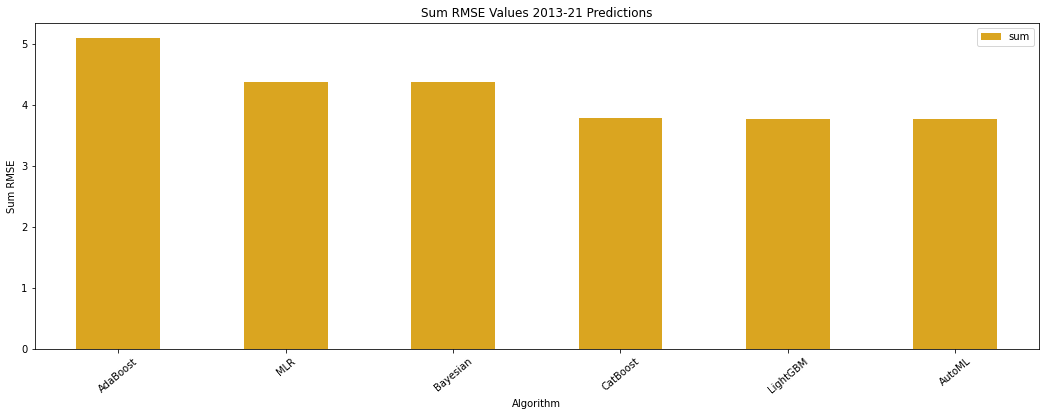

In [414]:
# rmse results
grouped_multiple1 = vis2.groupby(['Algorithm']).agg({'RMSE': ['mean', 'median', 'max', 'sum']})
grouped_multiple1.columns = ['mean','median','max','sum']
grouped_multiple1.reset_index(inplace = True)
distdf = grouped_multiple1.sort_values(by = ['sum'], ascending = False).head(15)
distdf.plot.bar(x = 'Algorithm', y = 'sum', rot = 40, figsize=(18, 6), color='goldenrod', xlabel='Algorithm', ylabel='Sum RMSE', title='Sum RMSE Values 2013-21 Predictions')

<AxesSubplot:title={'center':'Sum MEDAE Values 2013-21 Predictions'}, xlabel='Algorithm', ylabel='Sum MEDAE'>

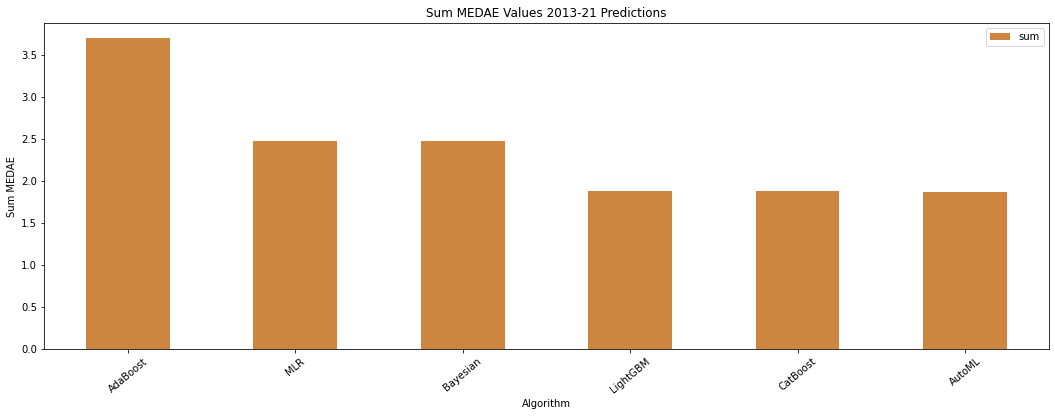

In [415]:
# median results
grouped_multiple2 = vis2.groupby(['Algorithm']).agg({'MEDAE': ['mean', 'median', 'max', 'sum']})
grouped_multiple2.columns = ['mean','median','max','sum']
grouped_multiple2.reset_index(inplace = True)
distdf = grouped_multiple2.sort_values(by = ['sum'], ascending = False).head(15)
distdf.plot.bar(x = 'Algorithm', y = 'sum', rot = 40, figsize=(18, 6), color='peru', xlabel='Algorithm', ylabel='Sum MEDAE', title='Sum MEDAE Values 2013-21 Predictions')

<AxesSubplot:title={'center':'Mean Accuracy Values 2013-21 Predictions'}, xlabel='Algorithm', ylabel='Average Accuracy'>

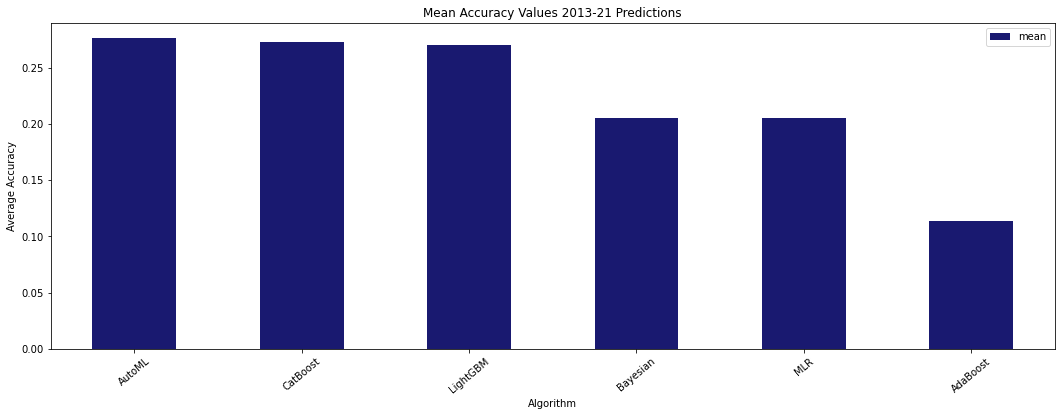

In [416]:
grouped_multiple3 = vis2.groupby(['Algorithm']).agg({'Accuracy': ['mean', 'median', 'max', 'sum']})
grouped_multiple3.columns = ['mean','median','max','sum']
grouped_multiple3.reset_index(inplace = True)
distdf = grouped_multiple3.sort_values(by = ['mean'], ascending = False).head(15)
distdf.plot.bar(x = 'Algorithm', y = 'mean', rot = 40, figsize=(18, 6), color='midnightblue', xlabel='Algorithm', ylabel='Average Accuracy', title='Mean Accuracy Values 2013-21 Predictions')

<AxesSubplot:title={'center':'Sum MSE Values 2013-21 Predictions'}, xlabel='Algorithm', ylabel='Sum MSE'>

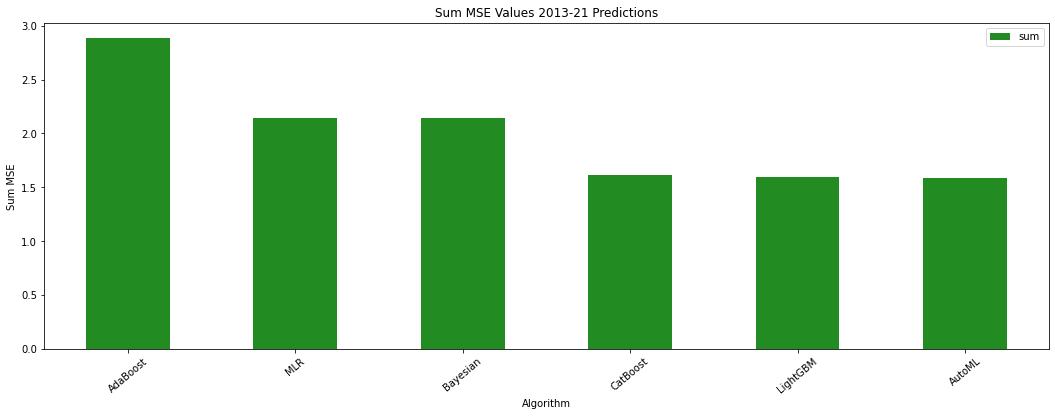

In [417]:
# mse results
grouped_multiple4 = vis2.groupby(['Algorithm']).agg({'MSE': ['mean', 'median', 'max', 'sum']})
grouped_multiple4.columns = ['mean','median','max','sum']
grouped_multiple4.reset_index(inplace = True)
distdf = grouped_multiple4.sort_values(by = ['sum'], ascending = False).head(15)
distdf.plot.bar(x = 'Algorithm', y = 'sum', rot = 40, figsize=(18, 6), color='forestgreen', xlabel='Algorithm', ylabel='Sum MSE', title='Sum MSE Values 2013-21 Predictions')

<AxesSubplot:title={'center':'Mean MAPE Values 2013-21 Predictions'}, xlabel='Algorithm', ylabel='Mean MAPE'>

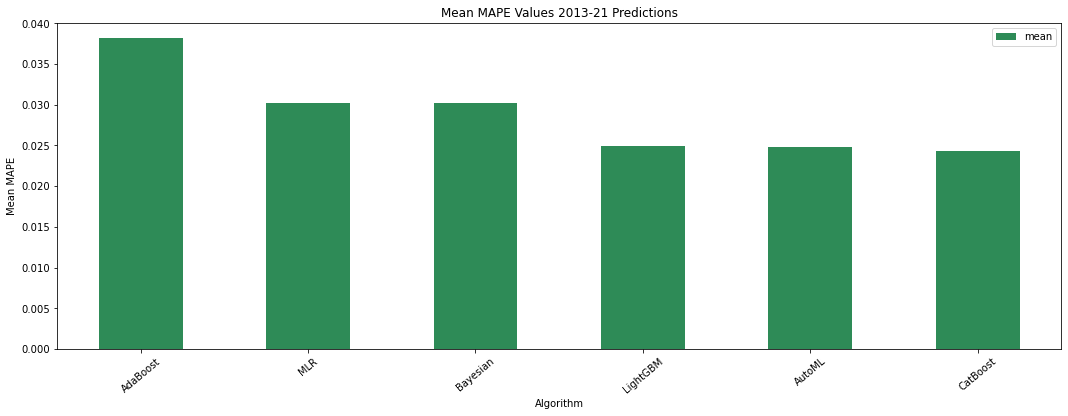

In [418]:
# mape results
grouped_multiple5 = vis2.groupby(['Algorithm']).agg({'MAPE': ['mean', 'median', 'max', 'sum']})
grouped_multiple5.columns = ['mean','median','max','sum']
grouped_multiple5.reset_index(inplace = True)
distdf = grouped_multiple5.sort_values(by = ['mean'], ascending = False).head(15)
distdf.plot.bar(x = 'Algorithm', y = 'mean', rot = 40, figsize=(18, 6), color='seagreen', xlabel='Algorithm', ylabel='Mean MAPE', title='Mean MAPE Values 2013-21 Predictions')

### Key Takeaways from our 3rd trial of experiments
- Accuracy - Our accuracy has improved once again with our basic implementation of the unemployment rate, with the mean accuracy values now around 27.5% in contrast to approximately 26% with just our neighbourhoods. 
- AutoML is now marginally the best performing algorithm now, with the best results in accuracy and MEDAE. CatBoost which as been strong to date is now 2nd with similarly strong results.
- It must be noted throughout our following experiments that as the years pass by there is a definite drop off in predictive accuracy. Our best performing models start at around 33% accuracy but drop to roughly 23% or slightly less when predicting 2013 values for example.

In [420]:
grouped_multiple3

,Algorithm,mean,median,max,sum
0,AdaBoost,0.113871,0.112933,0.182470,1.024836
1,AutoML,0.275769,0.270355,0.337618,2.481918
2,Bayesian,0.205388,0.207138,0.270931,1.848491
3,CatBoost,0.272771,0.270054,0.337486,2.454939
4,LightGBM,0.269915,0.266669,0.329254,2.429237
5,MLR,0.205338,0.207063,0.270710,1.848039
